# **Project — Intent Classification on BANKING77: A Comparative Study of Classical, Embedding-based & Transformer Models**

This project builds and compares three families of models for intent classification on the BANKING77 dataset (13k banking queries, 77 intents).
We implement 3 methods:




1.  Classical bag-of-words models using TF/TF-IDF + Multinomial Naive Bayes.
2.  Embedding-based models using pre-trained Word2Vec sentence vectors + MLP
3.  Transformer-based models (BERT & DistilBERT) fine-tuned end-to-end

We compare performance across all approaches using the same data split and evaluate with macro-F1, revealing a clear progression:
TF/TF-IDF + Multinomial Naive Bayes < Word2Vec + MLP < DistilBERT < BERT, with transformers achieving the highest accuracy at higher computational cost.








# **install libraries**

In [ ]:
!pip install datasets
!pip install pandas
!pip install matplotlib
!pip install  seaborn
!pip install scikit-learn
!pip install gensim
!pip install transformers
!pip install accelerate
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.5 MB/s eta 0:00:00


# **Data visualization**

load dataset Banking77

In [ ]:
from datasets import load_dataset

data = load_dataset('banking77')

# splits: 'train' (~10k) and 'test' (~3k)
train_data = data['train']
test_data = data['test']


labels = train_data.features["label"].names
num_labels = len(labels)

print(f"Train={len(train_data)} Test={len(test_data)} ")


Train=10003 Test=3080 


examples

In [ ]:
print("Example:", train_data[:2])

Example: {'text': ['I am still waiting on my card?', "What can I do if my card still hasn't arrived after 2 weeks?"], 'label': [11, 11]}


labels

In [ ]:
labels

['activate_my_card',
 'age_limit',
 'apple_pay_or_google_pay',
 'atm_support',
 'automatic_top_up',
 'balance_not_updated_after_bank_transfer',
 'balance_not_updated_after_cheque_or_cash_deposit',
 'beneficiary_not_allowed',
 'cancel_transfer',
 'card_about_to_expire',
 'card_acceptance',
 'card_arrival',
 'card_delivery_estimate',
 'card_linking',
 'card_not_working',
 'card_payment_fee_charged',
 'card_payment_not_recognised',
 'card_payment_wrong_exchange_rate',
 'card_swallowed',
 'cash_withdrawal_charge',
 'cash_withdrawal_not_recognised',
 'change_pin',
 'compromised_card',
 'contactless_not_working',
 'country_support',
 'declined_card_payment',
 'declined_cash_withdrawal',
 'declined_transfer',
 'direct_debit_payment_not_recognised',
 'disposable_card_limits',
 'edit_personal_details',
 'exchange_charge',
 'exchange_rate',
 'exchange_via_app',
 'extra_charge_on_statement',
 'failed_transfer',
 'fiat_currency_support',
 'get_disposable_virtual_card',
 'get_physical_card',
 'gett

## data visualization

show the 5 first examples

In [ ]:
import pandas as pd

train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

train_df.head(5)

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11


data distribution

In [ ]:
print(train_df["label"].value_counts())
print(test_df["label"].value_counts())

label
15    187
28    182
6     181
75    180
19    177
     ... 
41     82
18     61
10     59
72     41
23     35
Name: count, Length: 77, dtype: int64
label
11    40
13    40
32    40
17    40
34    40
      ..
19    40
9     40
2     40
69    40
24    40
Name: count, Length: 77, dtype: int64


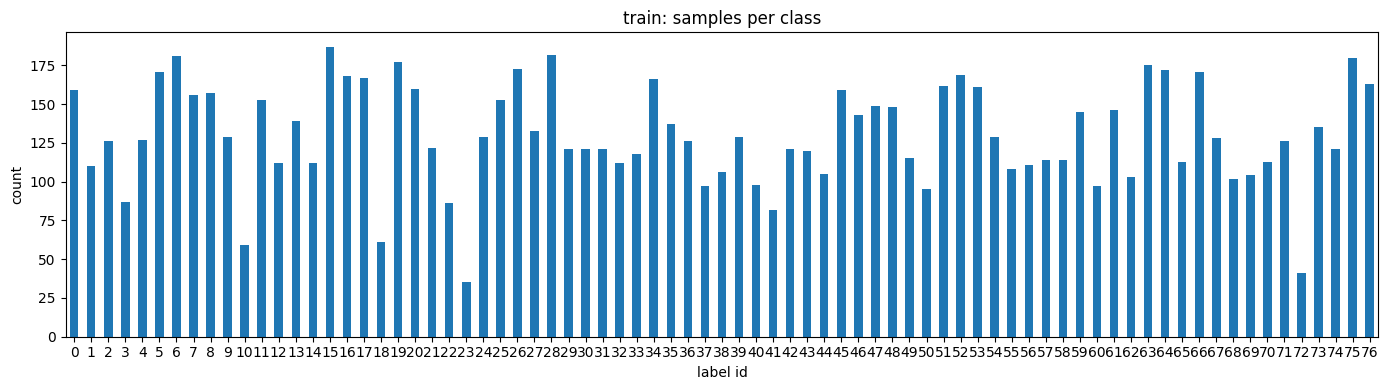

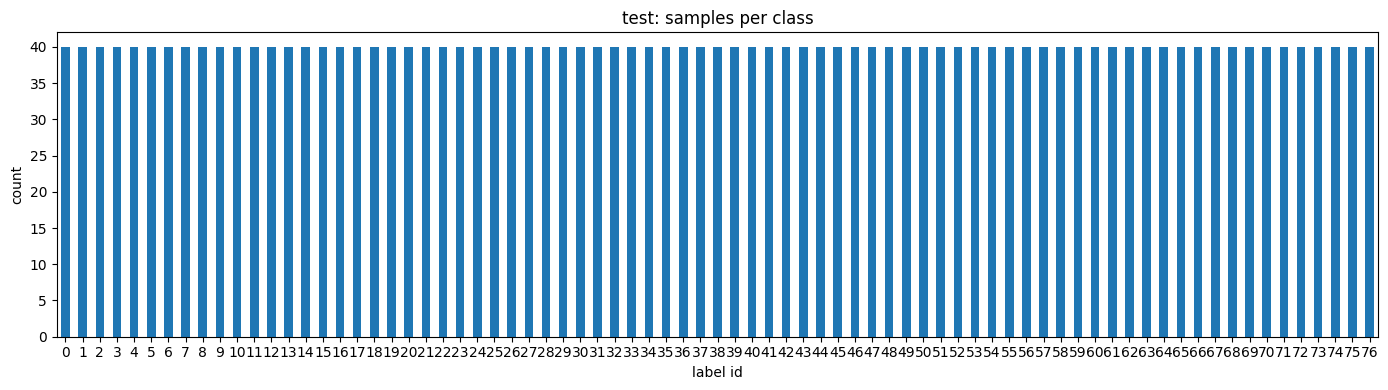

In [ ]:
import matplotlib.pyplot as plt

def plot_label_distribution(df, split_name):
    counts = df["label"].value_counts().sort_index()   # labels 0..76 in order
    plt.figure(figsize=(14,4))
    counts.plot(kind="bar")
    plt.title(f"{split_name}: samples per class")
    plt.xlabel("label id")
    plt.ylabel("count")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_label_distribution(train_df, "train")
plot_label_distribution(test_df, "test")


- Test is perfectly balanced: 40 samples per class.

- Train is imbalanced with moderate variation (30–170 per class) from the random stratified split.



# **First Method**

## TF /TF-IDF + Multinomial Naive Bayes



*   Represent each query as a sparse vector using TF and TF-IDF.
*   Train a Multinomial Naive Bayes classifier on these features.

   → train two models:
 *  TF + Multinomial Naive Bayes
 *  TF-IDF + Multinomial Naive Bayes








## load the dataset

In [ ]:
from datasets import load_dataset

data = load_dataset('banking77')

# splits: 'train' (~10k) and 'test' (~3k)
train_data = data['train']
test_data = data['test']


labels = train_data.features["label"].names
num_labels = len(labels)

print(f"Train={len(train_data)} Test={len(test_data)} ")
print("Example:", train_data[0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/298k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/93.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

Train=10003 Test=3080 
Example: {'text': 'I am still waiting on my card?', 'label': 11}


Remark. We skip lemmatization and heavy cleaning: BANKING77 intents depend on exact phrases (surface n-grams), the texts are already clean, and TF-IDF with n-grams captures the needed signal. Extra normalization risks deleting useful cues with no payoff.

In [ ]:
import pandas as pd

train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

## Training two model with GridSearch


*   Raw TF + Multinomial NB
*   TF-IDF + Multinomial NB



**Raw TF + Multinomial NB**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report


pipe_tf = Pipeline([
    ("tf", CountVectorizer()),
    ("clf", MultinomialNB()),
])

param_grid_tf = {
    "tf__ngram_range": [(1, 1), (1, 2)],
    "tf__min_df": [1, 2, 3],
    "tf__max_df": [1.0, 0.95, 0.90],
    "tf__max_features": [60000],
    "clf__alpha": [0.1, 0.3, 0.5, 1.0, 2.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search_tf = GridSearchCV(
    estimator=pipe_tf,
    param_grid=param_grid_tf,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True,
)




In [ ]:
search_tf.fit(train_df["text"], train_df["label"])

best_tf = search_tf.best_estimator_
print("best configuration: ",search_tf.best_params_)
pred_tf = best_tf.predict(test_df["text"])

prec_macro = precision_score(test_df["label"], pred_tf, average="macro", zero_division=0)
rec_macro  = recall_score(test_df["label"], pred_tf, average="macro", zero_division=0)
f1_macro   = f1_score(test_df["label"], pred_tf, average="macro")

print(
    f"RAW TF + MultinomialNB | "
    f"macro-Precision={prec_macro:.4f}  "
    f"macro-Recall={rec_macro:.4f}  "
    f"macro-F1={f1_macro:.4f}"
)

print(classification_report(test_df["label"], pred_tf, target_names=labels, digits=3))

Fitting 5 folds for each of 90 candidates, totalling 450 fits
best configuration:  {'clf__alpha': 0.1, 'tf__max_df': 1.0, 'tf__max_features': 60000, 'tf__min_df': 2, 'tf__ngram_range': (1, 2)}
RAW TF + MultinomialNB | macro-Precision=0.8713  macro-Recall=0.8653  macro-F1=0.8646
                                                  precision    recall  f1-score   support

                                activate_my_card      0.841     0.925     0.881        40
                                       age_limit      0.976     1.000     0.988        40
                         apple_pay_or_google_pay      0.796     0.975     0.876        40
                                     atm_support      0.900     0.900     0.900        40
                                automatic_top_up      0.921     0.875     0.897        40
         balance_not_updated_after_bank_transfer      0.818     0.675     0.740        40
balance_not_updated_after_cheque_or_cash_deposit      0.864     0.950     0.905        40


**TF-IDF + Multinomial NB**

In [ ]:
from datasets import load_dataset
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, f1_score

pipe_tfidf = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB()),
])

param_grid_tfidf = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__min_df": [1, 2, 3],
    "tfidf__max_df": [1.0, 0.95, 0.90],
    "tfidf__sublinear_tf": [False, True],
    "tfidf__max_features": [60000],
    "clf__alpha": [0.1, 0.3, 0.5, 1.0, 2.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search_tfifd = GridSearchCV(
    estimator=pipe_tfidf,
    param_grid=param_grid_tfidf,
    scoring="f1_macro",   # macro F1 as the tuning objective
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True,           # refit best model according to f1_macro (default, but explicit)
)


In [ ]:
search_tfifd.fit(train_df["text"], train_df["label"])

best_tfidf = search_tfifd.best_estimator_
print("best configuration: ",search_tfifd.best_params_)
pred_tfidf = best_tfidf.predict(test_df["text"])

prec_macro = precision_score(test_df["label"], pred_tfidf, average="macro", zero_division=0)
rec_macro  = recall_score(test_df["label"], pred_tfidf, average="macro", zero_division=0)
f1_macro   = f1_score(test_df["label"], pred_tfidf, average="macro")

print(
    f"TF-IDF+ MultinomialNB | "
    f"macro-Precision={prec_macro:.4f}  "
    f"macro-Recall={rec_macro:.4f}  "
    f"macro-F1={f1_macro:.4f}"
)

print(classification_report(test_df["label"], pred_tfidf, target_names=labels, digits=3))

Fitting 5 folds for each of 180 candidates, totalling 900 fits
best configuration:  {'clf__alpha': 0.1, 'tfidf__max_df': 1.0, 'tfidf__max_features': 60000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1), 'tfidf__sublinear_tf': True}
TF-IDF+ MultinomialNB | macro-Precision=0.8639  macro-Recall=0.8555  macro-F1=0.8548
                                                  precision    recall  f1-score   support

                                activate_my_card      0.884     0.950     0.916        40
                                       age_limit      0.974     0.950     0.962        40
                         apple_pay_or_google_pay      0.889     1.000     0.941        40
                                     atm_support      0.944     0.850     0.895        40
                                automatic_top_up      0.925     0.925     0.925        40
         balance_not_updated_after_bank_transfer      0.707     0.725     0.716        40
balance_not_updated_after_cheque_or_cash_deposit 

## Results

**Raw TF + NB**

*   best configuration:  {'clf__alpha': 0.1, 'tf__max_df': 1.0, 'tf__max_features': 60000, 'tf__min_df': 2, 'tf__ngram_range': (1, 2)}
*  macro-Precision=0.8713 macro-Recall=0.8653  **macro-F1=0.8646 **



**TF-IDF + NB**



*   best configuration:  {'clf__alpha': 0.1, 'tfidf__max_df': 1.0, 'tfidf__max_features': 60000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1), 'tfidf__sublinear_tf': True}
*   macro-Precision=0.8639  macro-Recall=0.8555  **macro-F1=0.8548**



TF > TF-IDF by ~1% macro-F1.

confusion matrix


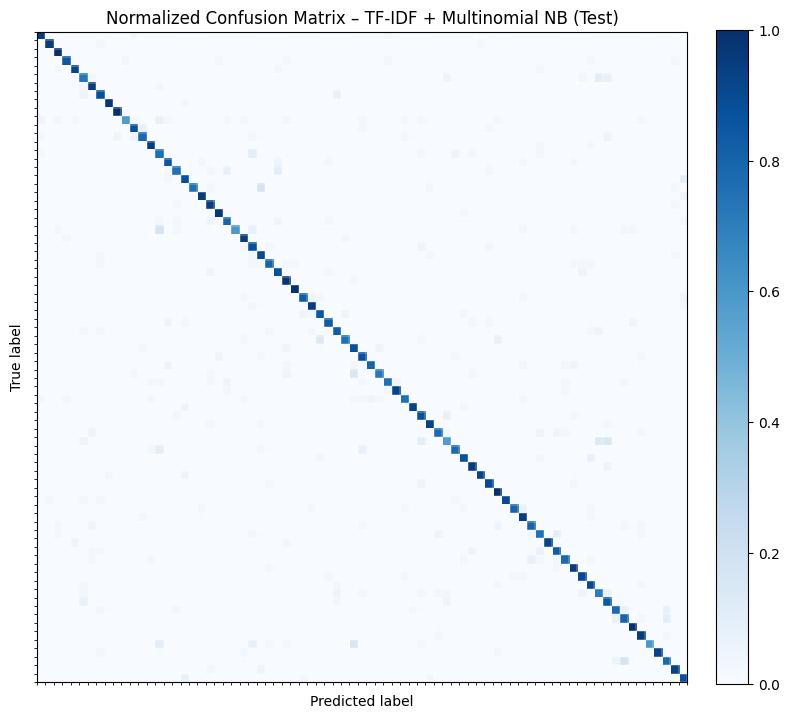

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np



cm_norm = confusion_matrix(
    test_df["label"],
    pred_tfidf ,
    normalize="true",
)

fig, ax = plt.subplots(figsize=(8, 8))

disp = ConfusionMatrixDisplay(cm_norm)
disp.plot(
    include_values=False,
    cmap="Blues",
    ax=ax,
    colorbar=False,
)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-0.5, cm_norm.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, cm_norm.shape[0], 1), minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=0.3)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Normalized Confusion Matrix – TF-IDF + Multinomial NB (Test)")

im = ax.images[0]
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()



# **Second Method**

## Word2Vec Sentence Embeddings + MLP

we use the pretrained **word2vec-google-news-300** model to turn each token into a 300-dimensional embedding. For each query, we take the **mean of all token embeddings** to get a single sentence vector, then feed it to a small **MLP classifier** (FC → ReLU → Dropout → FC).


We also test two OOV strategies:
- **Variant 1:** Replace unknown words with an **UNK** vector.
- **Variant 2:** **Ignore** unknown words when averaging.



## load the data

In [ ]:
from datasets import load_dataset

data = load_dataset('banking77')

# splits: train (10k) and test (3k)
train_data = data['train']
test_data = data['test']


# test_data -> (test_data, valid_data)
SEED = 42
split = test_data.train_test_split(
    test_size=0.50,
    seed=SEED,
    stratify_by_column="label",   #keep class proportions
)

valid_data = split["train"]
test_data = split["test"]


labels = train_data.features["label"].names
num_labels = len(labels)

print(f"Train={len(train_data)}  Valid={len(valid_data)} Test={len(test_data)} ")
print("Example:", train_data[0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/298k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/93.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

Train=10003  Valid=1540 Test=1540 
Example: {'text': 'I am still waiting on my card?', 'label': 11}


## Model word2vec + MLP

preprocessing

In [ ]:
import re


def tokenization(s):
  s= s.lower()
  s = s.replace("’","'").replace("‘","'")
  return re.findall(r"[A-Za-z0-9']+", s)

train_texts=[tokenization(s["text"]) for s in train_data]
valid_texts=[tokenization(s["text"]) for s in valid_data]
test_texts=[tokenization(s["text"]) for s in test_data]

Y_train=[s["label"] for s in train_data]
Y_valid=[s["label"] for s in valid_data]
Y_test=[s["label"] for s in test_data]



load pretrained googlenews word2vec

In [ ]:
import gensim.downloader as api

word2vec=api.load("word2vec-google-news-300")
D=word2vec.vector_size  # which is 300

[==================================================] 100.0% 1662.8/1662.8MB downloaded


**checking OOV**

Compute the out-of-vocabulary (OOV) rate for each split to quantify how many tokens are missing from the Word2Vec vocabulary.

In [ ]:
def oov_rate(texts):
    tot = sum(len(t) for t in texts)
    miss = sum(sum(1 for w in t if w not in word2vec) for t in texts)
    return miss / max(tot, 1)

print("OOV train:", f"{oov_rate(train_texts):.2%}")
print("OOV valid:", f"{oov_rate(valid_texts):.2%}")
print("OOV test :", f"{oov_rate(test_texts):.2%}")


OOV train: 8.80%
OOV valid: 8.75%
OOV test : 8.57%


Inspect the most frequent OOV tokens to understand their nature (e.g., stopwords, typos, rare domain terms).

In [ ]:
from collections import Counter

def oov_list(texts, word2vec):
    oov = []
    for toks in texts:
        for w in toks:
            if w not in word2vec:
                oov.append(w)
    return Counter(oov)

oov_train = oov_list(train_texts, word2vec)
oov_valid = oov_list(valid_texts, word2vec)
oov_test  = oov_list(test_texts,  word2vec)
print(oov_valid.most_common(30))

[('to', 570), ('a', 506), ('and', 165), ('of', 88), ("i'm", 32), ("i've", 23), ('cancelled', 14), ('cheque', 12), ('atms', 11), ("i'd", 4), ('cryptocurrency', 3), ('recognise', 3), ('20', 3), ('100', 3), ("card's", 2), ('kensington', 2), ('30', 2), ('10', 2), ('isnt', 2), ("atm's", 2), ('checque', 1), ('authorise', 1), ('amoutn', 1), ("beneficiary's", 1), ('contanctless', 1), ('ecchange', 1), ('crad', 1), ('interconvert', 1), ('beneficiery', 1), ('referted', 1)]


=> many OOVs are uninformative function words or low-frequency noise.

Sentence representations and OOV variants

- `sent_vec`: averages all token embeddings, replacing unknown words with the `UNK` vector.
- `sent_vec_no_oov`: averages only in-vocabulary tokens, completely ignoring OOV words.

In [ ]:
import numpy as np

def sent_vec(tokens):
    vecs = [(word2vec[w] if w in word2vec else word2vec['UNK']) for w in tokens ]
    return np.mean(vecs, axis=0).astype(np.float32) if vecs else np.zeros(D, dtype=np.float32)

def sent_vec_no_oov(tokens):
    vecs = [word2vec[w] for w in tokens if w in word2vec]
    return np.mean(vecs, axis=0).astype(np.float32) if vecs else np.zeros(D, dtype=np.float32)

# first variant
X_train = np.vstack([sent_vec(t) for t in train_texts])
X_valid = np.vstack([sent_vec(t) for t in valid_texts])
X_test  = np.vstack([sent_vec(t) for t in test_texts])

# second variant
X_train2 = np.vstack([sent_vec_no_oov(t) for t in train_texts])
X_valid2 = np.vstack([sent_vec_no_oov(t) for t in valid_texts])
X_test2  = np.vstack([sent_vec_no_oov(t) for t in test_texts])


building the classifier

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MLPClassifier(nn.Module):
    def __init__(self, in_dim, num_labels, hidden=256, dropout=0.2):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden, num_labels)

    def forward(self, x):
        x = self.fc1(x)   # [B, hidden]
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)    # [B, num_labels]
        return x


build the dataloader for dataset with oov

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

Y_train = np.asarray(Y_train, dtype=np.int64)
Y_valid = np.asarray(Y_valid, dtype=np.int64)
Y_test  = np.asarray(Y_test,  dtype=np.int64)


 # with oov

train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train)),
    batch_size=64, shuffle=True, pin_memory=True
)
valid_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(Y_valid)),
    batch_size=64, shuffle=False, pin_memory=True
)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test)),
    batch_size=64, shuffle=False, pin_memory=True
)





In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLPClassifier(D, num_labels, hidden=256, dropout=0.2)
loss_function=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)

model.to(device)
epochs=15


training and validation funstions

In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def metrics(logits_t: torch.Tensor, labels_t: torch.Tensor):

    y_true = labels_t.numpy()
    y_pred = logits_t.argmax(dim=1).numpy()
    acc  = accuracy_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred, average="macro")
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec     = recall_score(y_true, y_pred, average="macro", zero_division=0)
    return  rec, f1, prec, y_pred, y_true

def train_epoch(model, train_loader, optimizer, loss_function,  device):

  model.train()
  losses=0
  all_logits,all_labels = [],[]
  for x,y in tqdm(train_loader):
    x=x.to(device)
    y=y.to(device)

    logits=model(x)

    optimizer.zero_grad()
    loss=loss_function(logits, y)
    loss.backward()

    optimizer.step()
    losses+=loss.item()

    all_logits.append(logits.detach().cpu())
    all_labels.append(y.detach().cpu())

  all_logits=torch.cat(all_logits,dim=0)
  all_labels=torch.cat(all_labels,dim=0)
  rec, f1, prec,_,_ = metrics(all_logits, all_labels)
  return losses/len(list(train_loader)), rec,f1,prec

def eval_epoch(model,valid_loader,loss_function,device):
  model.eval()
  losses=0
  all_logits, all_labels = [], []
  with torch.no_grad():
    for x,y in valid_loader:
      x=x.to(device)
      y=y.to(device)

      logits=model(x)

      loss=loss_function(logits, y)
      losses+=loss.item()
      all_logits.append(logits.detach().cpu())
      all_labels.append(y.detach().cpu())

    all_logits=torch.cat(all_logits,dim=0)
    all_labels=torch.cat(all_labels,dim=0)
    rec, f1, prec, preds , truths = metrics(all_logits, all_labels)
    return losses/len(list(valid_loader))  , rec, f1, prec,preds,truths




Training

In [ ]:
def train(model, epochs, train_loader,valid_loader,optimizer,loss_function,device ):
  for epoch in range(1, epochs+1):
        train_loss, train_rec, train_f1, train_prec = train_epoch(model,train_loader,optimizer,loss_function,device)
        val_loss, val_rec, val_f1, val_prec,_ ,_= eval_epoch(model,valid_loader,loss_function,device)
        print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}"))
        print((f"Train rec: {train_rec:.3f}, Val rec: {val_rec:.3f}"))
        print((f"Train f1: {train_f1:.3f}, Val f1: {val_f1:.3f}"))
        print((f"Train prec: {train_prec:.3f}, Val prec: {val_prec:.3f}"))

In [ ]:

train(model,epochs,train_loader,valid_loader,optimizer,loss_function,device)




100%|██████████| 157/157 [00:03<00:00, 48.27it/s]


Epoch: 1, Train loss: 3.955, Val loss: 3.325
Train rec: 0.119, Val rec: 0.306
Train f1: 0.108, Val f1: 0.250
Train prec: 0.263, Val prec: 0.350


100%|██████████| 157/157 [00:00<00:00, 173.48it/s]


Epoch: 2, Train loss: 2.665, Val loss: 2.157
Train rec: 0.397, Val rec: 0.567
Train f1: 0.383, Val f1: 0.553
Train prec: 0.434, Val prec: 0.620


100%|██████████| 157/157 [00:00<00:00, 275.87it/s]


Epoch: 3, Train loss: 1.873, Val loss: 1.598
Train rec: 0.548, Val rec: 0.654
Train f1: 0.541, Val f1: 0.636
Train prec: 0.556, Val prec: 0.685


100%|██████████| 157/157 [00:00<00:00, 338.09it/s]


Epoch: 4, Train loss: 1.452, Val loss: 1.279
Train rec: 0.642, Val rec: 0.719
Train f1: 0.640, Val f1: 0.710
Train prec: 0.667, Val prec: 0.750


100%|██████████| 157/157 [00:00<00:00, 314.75it/s]


Epoch: 5, Train loss: 1.204, Val loss: 1.077
Train rec: 0.696, Val rec: 0.758
Train f1: 0.697, Val f1: 0.753
Train prec: 0.717, Val prec: 0.780


100%|██████████| 157/157 [00:00<00:00, 299.64it/s]


Epoch: 6, Train loss: 1.052, Val loss: 0.945
Train rec: 0.728, Val rec: 0.782
Train f1: 0.730, Val f1: 0.779
Train prec: 0.746, Val prec: 0.806


100%|██████████| 157/157 [00:00<00:00, 246.77it/s]


Epoch: 7, Train loss: 0.932, Val loss: 0.841
Train rec: 0.758, Val rec: 0.795
Train f1: 0.761, Val f1: 0.792
Train prec: 0.774, Val prec: 0.812


100%|██████████| 157/157 [00:00<00:00, 157.85it/s]


Epoch: 8, Train loss: 0.847, Val loss: 0.773
Train rec: 0.781, Val rec: 0.806
Train f1: 0.784, Val f1: 0.805
Train prec: 0.793, Val prec: 0.827


100%|██████████| 157/157 [00:01<00:00, 154.27it/s]


Epoch: 9, Train loss: 0.777, Val loss: 0.709
Train rec: 0.799, Val rec: 0.829
Train f1: 0.801, Val f1: 0.828
Train prec: 0.809, Val prec: 0.842


100%|██████████| 157/157 [00:00<00:00, 239.45it/s]


Epoch: 10, Train loss: 0.731, Val loss: 0.670
Train rec: 0.807, Val rec: 0.844
Train f1: 0.810, Val f1: 0.843
Train prec: 0.817, Val prec: 0.852


100%|██████████| 157/157 [00:00<00:00, 344.03it/s]


Epoch: 11, Train loss: 0.685, Val loss: 0.639
Train rec: 0.820, Val rec: 0.845
Train f1: 0.822, Val f1: 0.845
Train prec: 0.827, Val prec: 0.860


100%|██████████| 157/157 [00:00<00:00, 338.44it/s]


Epoch: 12, Train loss: 0.642, Val loss: 0.610
Train rec: 0.831, Val rec: 0.849
Train f1: 0.833, Val f1: 0.848
Train prec: 0.839, Val prec: 0.859


100%|██████████| 157/157 [00:00<00:00, 242.39it/s]


Epoch: 13, Train loss: 0.610, Val loss: 0.582
Train rec: 0.840, Val rec: 0.860
Train f1: 0.841, Val f1: 0.860
Train prec: 0.845, Val prec: 0.874


100%|██████████| 157/157 [00:00<00:00, 192.55it/s]


Epoch: 14, Train loss: 0.582, Val loss: 0.556
Train rec: 0.843, Val rec: 0.861
Train f1: 0.845, Val f1: 0.861
Train prec: 0.849, Val prec: 0.872


100%|██████████| 157/157 [00:00<00:00, 219.08it/s]


Epoch: 15, Train loss: 0.559, Val loss: 0.535
Train rec: 0.852, Val rec: 0.865
Train f1: 0.854, Val f1: 0.865
Train prec: 0.856, Val prec: 0.876


Testing

In [ ]:
def test(model, test_loader,loss_function ):
        test_loss, rec, f1, prec,preds,truths = eval_epoch(model,test_loader,loss_function,device)
        print((f" test loss: {test_loss:.3f}, rec: {rec:.3f}, f1-score: {f1:.3f}, precision: {prec:.3f}"))
        return preds, truths


In [ ]:

preds,truths=test(model,test_loader,loss_function)

 test loss: 0.542, rec: 0.854, f1-score: 0.854, precision: 0.862


confusion matrix

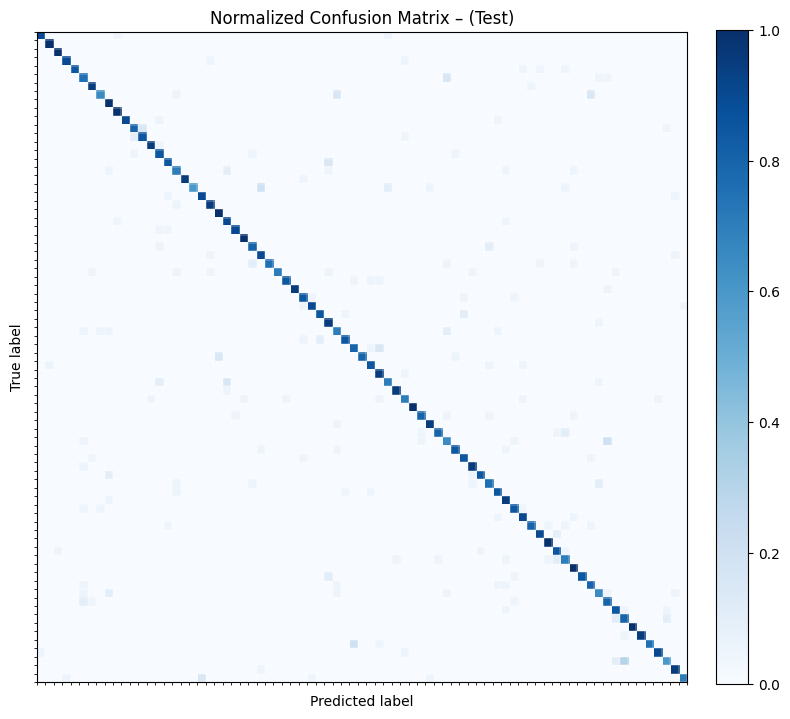

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



cm_norm = confusion_matrix(
    truths,
    preds,

    normalize="true",
)

fig, ax = plt.subplots(figsize=(8, 8))

disp = ConfusionMatrixDisplay(cm_norm)
disp.plot(
    include_values=False,
    cmap="Blues",
    ax=ax,
    colorbar=False,
)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-0.5, cm_norm.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, cm_norm.shape[0], 1), minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=0.3)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Normalized Confusion Matrix – (Test)")

im = ax.images[0]
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

Hyperparameter tuning to find the optimal configuration.

In [ ]:
import itertools

def make_loaders(Xtr, Ytr, Xva, Yva,Xte,Yte, batch_size):
    tr_loader = DataLoader(TensorDataset(torch.from_numpy(Xtr), torch.from_numpy(np.array(Ytr, dtype=np.int64))),
                           batch_size=batch_size, shuffle=True,  pin_memory=True)
    va_loader = DataLoader(TensorDataset(torch.from_numpy(Xva), torch.from_numpy(np.array(Yva, dtype=np.int64))),
                           batch_size=max(256, batch_size), shuffle=False, pin_memory=True)
    te_loader = DataLoader(TensorDataset(torch.from_numpy(Xte), torch.from_numpy(np.array(Yte, dtype=np.int64))),
                           batch_size=max(256, batch_size), shuffle=False, pin_memory=True)
    return tr_loader, va_loader, te_loader

search_space = {
    "hidden":          [128, 256, 512],
    "dropout":         [0.1, 0.2, 0.3],
    "batch_size":      [64, 128, 256],
    "lr":              [3e-4, 1e-3],
    "weight_decay":    [0.0, 1e-4],
    "label_smoothing": [0.0, 0.1],
}

FIXED_EPOCHS   = 15
FIXED_PATIENCE = 5
FIXED_SEED     = 42


def run_config(cfg):
    # fixed seed for determinism
    torch.manual_seed(cfg["seed"])
    np.random.seed(cfg["seed"])
    torch.cuda.manual_seed(cfg["seed"])
    random.seed(cfg["seed"])

    model = MLPClassifier(D, num_labels,
                          hidden=cfg["hidden"],
                          dropout=cfg["dropout"]).to(device)

    loss_fn = nn.CrossEntropyLoss(label_smoothing=cfg["label_smoothing"])
    opt = torch.optim.AdamW(
        model.parameters(),
        lr=cfg["lr"],
        weight_decay=cfg["weight_decay"],
    )

    tr_loader, va_loader, te_loader = make_loaders(
        X_train, Y_train,
        X_valid, Y_valid,
        X_test, Y_test,
        cfg["batch_size"],
    )

    best_f1, best_state, bad = -1.0, None, 0
    history = []

    for ep in range(1, cfg["epochs"] + 1):
        tr = train_epoch(model, tr_loader, opt, loss_fn, device)
        va = eval_epoch(model, va_loader, loss_fn, device)
        history.append((tr, va))

        # track best on validation macro-F1 ( va[2] is macro-F1)
        if va[2] > best_f1:
            best_f1 = va[2]
            best_state = {k: v.detach().cpu().clone()
                          for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= cfg["patience"]:
                break

    return best_f1, best_state, history


keys = list(search_space.keys())

configs = []
for values in itertools.product(*(search_space[k] for k in keys)):
    cfg = dict(zip(keys, values))
    cfg["epochs"]   = FIXED_EPOCHS
    cfg["patience"] = FIXED_PATIENCE
    cfg["seed"]     = FIXED_SEED
    configs.append(cfg)

print("Total configs:", len(configs))


Total configs: 216


In [ ]:
import random

results = []

for i, cfg in enumerate(configs, 1):
    print("=" * 80)
    print(f"Running config {i}/{len(configs)}: {cfg}")
    best_f1, best_state, hist = run_config(cfg)
    results.append((best_f1, cfg, best_state))
    print(f"  --> best val F1={best_f1:.4f}")

# pick the best config
best_f1, best_cfg, best_state = max(results, key=lambda x: x[0])
print("\nBest config:", best_cfg, "Val F1:", f"{best_f1:.4f}")


Running config 1/216: {'hidden': 128, 'dropout': 0.1, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 496.38it/s]


  --> best val F1=0.6716
Running config 2/216: {'hidden': 128, 'dropout': 0.1, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 413.38it/s]


  --> best val F1=0.6844
Running config 3/216: {'hidden': 128, 'dropout': 0.1, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 453.03it/s]


  --> best val F1=0.6722
Running config 4/216: {'hidden': 128, 'dropout': 0.1, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:01<00:00, 156.67it/s]


  --> best val F1=0.6844
Running config 5/216: {'hidden': 128, 'dropout': 0.1, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 460.23it/s]


  --> best val F1=0.8422
Running config 6/216: {'hidden': 128, 'dropout': 0.1, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 270.05it/s]


  --> best val F1=0.8557
Running config 7/216: {'hidden': 128, 'dropout': 0.1, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 471.37it/s]


  --> best val F1=0.8422
Running config 8/216: {'hidden': 128, 'dropout': 0.1, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 410.46it/s]


  --> best val F1=0.8565
Running config 9/216: {'hidden': 128, 'dropout': 0.1, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 396.68it/s]


  --> best val F1=0.5746
Running config 10/216: {'hidden': 128, 'dropout': 0.1, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 327.28it/s]


  --> best val F1=0.5908
Running config 11/216: {'hidden': 128, 'dropout': 0.1, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 395.31it/s]


  --> best val F1=0.5746
Running config 12/216: {'hidden': 128, 'dropout': 0.1, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 328.76it/s]


  --> best val F1=0.5908
Running config 13/216: {'hidden': 128, 'dropout': 0.1, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 382.92it/s]


  --> best val F1=0.8019
Running config 14/216: {'hidden': 128, 'dropout': 0.1, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 345.93it/s]


  --> best val F1=0.8224
Running config 15/216: {'hidden': 128, 'dropout': 0.1, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 288.17it/s]


  --> best val F1=0.8019
Running config 16/216: {'hidden': 128, 'dropout': 0.1, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 341.92it/s]


  --> best val F1=0.8224
Running config 17/216: {'hidden': 128, 'dropout': 0.1, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 297.71it/s]


  --> best val F1=0.4210
Running config 18/216: {'hidden': 128, 'dropout': 0.1, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 262.18it/s]


  --> best val F1=0.4372
Running config 19/216: {'hidden': 128, 'dropout': 0.1, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 290.79it/s]


  --> best val F1=0.4210
Running config 20/216: {'hidden': 128, 'dropout': 0.1, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 199.26it/s]


  --> best val F1=0.4372
Running config 21/216: {'hidden': 128, 'dropout': 0.1, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 288.57it/s]


  --> best val F1=0.7225
Running config 22/216: {'hidden': 128, 'dropout': 0.1, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 215.52it/s]


  --> best val F1=0.7514
Running config 23/216: {'hidden': 128, 'dropout': 0.1, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 267.98it/s]


  --> best val F1=0.7225
Running config 24/216: {'hidden': 128, 'dropout': 0.1, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 259.92it/s]


  --> best val F1=0.7514
Running config 25/216: {'hidden': 128, 'dropout': 0.2, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 489.65it/s]


  --> best val F1=0.6659
Running config 26/216: {'hidden': 128, 'dropout': 0.2, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 413.56it/s]


  --> best val F1=0.6798
Running config 27/216: {'hidden': 128, 'dropout': 0.2, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 484.27it/s]


  --> best val F1=0.6659
Running config 28/216: {'hidden': 128, 'dropout': 0.2, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 342.15it/s]


  --> best val F1=0.6798
Running config 29/216: {'hidden': 128, 'dropout': 0.2, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 486.91it/s]


  --> best val F1=0.8390
Running config 30/216: {'hidden': 128, 'dropout': 0.2, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 398.53it/s]


  --> best val F1=0.8544
Running config 31/216: {'hidden': 128, 'dropout': 0.2, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 381.85it/s]


  --> best val F1=0.8385
Running config 32/216: {'hidden': 128, 'dropout': 0.2, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 387.72it/s]


  --> best val F1=0.8545
Running config 33/216: {'hidden': 128, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 382.36it/s]


  --> best val F1=0.5700
Running config 34/216: {'hidden': 128, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 337.76it/s]


  --> best val F1=0.5753
Running config 35/216: {'hidden': 128, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 313.02it/s]


  --> best val F1=0.5700
Running config 36/216: {'hidden': 128, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 341.32it/s]


  --> best val F1=0.5753
Running config 37/216: {'hidden': 128, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 307.15it/s]


  --> best val F1=0.7967
Running config 38/216: {'hidden': 128, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 346.17it/s]


  --> best val F1=0.8132
Running config 39/216: {'hidden': 128, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 399.52it/s]


  --> best val F1=0.7967
Running config 40/216: {'hidden': 128, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 342.57it/s]


  --> best val F1=0.8132
Running config 41/216: {'hidden': 128, 'dropout': 0.2, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 284.98it/s]


  --> best val F1=0.4081
Running config 42/216: {'hidden': 128, 'dropout': 0.2, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 266.30it/s]


  --> best val F1=0.4234
Running config 43/216: {'hidden': 128, 'dropout': 0.2, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 291.21it/s]


  --> best val F1=0.4081
Running config 44/216: {'hidden': 128, 'dropout': 0.2, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 261.40it/s]


  --> best val F1=0.4234
Running config 45/216: {'hidden': 128, 'dropout': 0.2, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 294.45it/s]


  --> best val F1=0.7150
Running config 46/216: {'hidden': 128, 'dropout': 0.2, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 262.57it/s]


  --> best val F1=0.7417
Running config 47/216: {'hidden': 128, 'dropout': 0.2, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 201.40it/s]


  --> best val F1=0.7150
Running config 48/216: {'hidden': 128, 'dropout': 0.2, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 269.19it/s]


  --> best val F1=0.7417
Running config 49/216: {'hidden': 128, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 368.09it/s]


  --> best val F1=0.6512
Running config 50/216: {'hidden': 128, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 402.35it/s]


  --> best val F1=0.6657
Running config 51/216: {'hidden': 128, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 469.98it/s]


  --> best val F1=0.6512
Running config 52/216: {'hidden': 128, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 310.41it/s]


  --> best val F1=0.6657
Running config 53/216: {'hidden': 128, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 462.52it/s]


  --> best val F1=0.8312
Running config 54/216: {'hidden': 128, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 395.66it/s]


  --> best val F1=0.8431
Running config 55/216: {'hidden': 128, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 452.92it/s]


  --> best val F1=0.8312
Running config 56/216: {'hidden': 128, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 395.39it/s]


  --> best val F1=0.8444
Running config 57/216: {'hidden': 128, 'dropout': 0.3, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 289.93it/s]


  --> best val F1=0.5496
Running config 58/216: {'hidden': 128, 'dropout': 0.3, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 338.77it/s]


  --> best val F1=0.5612
Running config 59/216: {'hidden': 128, 'dropout': 0.3, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 277.88it/s]


  --> best val F1=0.5496
Running config 60/216: {'hidden': 128, 'dropout': 0.3, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 340.08it/s]


  --> best val F1=0.5612
Running config 61/216: {'hidden': 128, 'dropout': 0.3, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 388.53it/s]


  --> best val F1=0.7835
Running config 62/216: {'hidden': 128, 'dropout': 0.3, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 336.62it/s]


  --> best val F1=0.8031
Running config 63/216: {'hidden': 128, 'dropout': 0.3, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 392.68it/s]


  --> best val F1=0.7828
Running config 64/216: {'hidden': 128, 'dropout': 0.3, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 313.74it/s]


  --> best val F1=0.8039
Running config 65/216: {'hidden': 128, 'dropout': 0.3, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 293.66it/s]


  --> best val F1=0.3945
Running config 66/216: {'hidden': 128, 'dropout': 0.3, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 193.56it/s]


  --> best val F1=0.4122
Running config 67/216: {'hidden': 128, 'dropout': 0.3, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 265.36it/s]


  --> best val F1=0.3945
Running config 68/216: {'hidden': 128, 'dropout': 0.3, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 258.93it/s]


  --> best val F1=0.4122
Running config 69/216: {'hidden': 128, 'dropout': 0.3, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 281.31it/s]


  --> best val F1=0.7115
Running config 70/216: {'hidden': 128, 'dropout': 0.3, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 239.59it/s]


  --> best val F1=0.7261
Running config 71/216: {'hidden': 128, 'dropout': 0.3, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 283.42it/s]


  --> best val F1=0.7116
Running config 72/216: {'hidden': 128, 'dropout': 0.3, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 241.34it/s]


  --> best val F1=0.7261
Running config 73/216: {'hidden': 256, 'dropout': 0.1, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 453.07it/s]


  --> best val F1=0.7573
Running config 74/216: {'hidden': 256, 'dropout': 0.1, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 392.22it/s]


  --> best val F1=0.7798
Running config 75/216: {'hidden': 256, 'dropout': 0.1, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 449.23it/s]


  --> best val F1=0.7573
Running config 76/216: {'hidden': 256, 'dropout': 0.1, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 309.62it/s]


  --> best val F1=0.7798
Running config 77/216: {'hidden': 256, 'dropout': 0.1, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 435.36it/s]


  --> best val F1=0.8674
Running config 78/216: {'hidden': 256, 'dropout': 0.1, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 396.47it/s]


  --> best val F1=0.8756
Running config 79/216: {'hidden': 256, 'dropout': 0.1, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 366.27it/s]


  --> best val F1=0.8674
Running config 80/216: {'hidden': 256, 'dropout': 0.1, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 372.06it/s]


  --> best val F1=0.8743
Running config 81/216: {'hidden': 256, 'dropout': 0.1, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 373.81it/s]


  --> best val F1=0.6776
Running config 82/216: {'hidden': 256, 'dropout': 0.1, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 333.40it/s]


  --> best val F1=0.6868
Running config 83/216: {'hidden': 256, 'dropout': 0.1, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 342.34it/s]


  --> best val F1=0.6776
Running config 84/216: {'hidden': 256, 'dropout': 0.1, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 328.97it/s]


  --> best val F1=0.6868
Running config 85/216: {'hidden': 256, 'dropout': 0.1, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 265.87it/s]


  --> best val F1=0.8439
Running config 86/216: {'hidden': 256, 'dropout': 0.1, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 328.80it/s]


  --> best val F1=0.8618
Running config 87/216: {'hidden': 256, 'dropout': 0.1, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 285.62it/s]


  --> best val F1=0.8432
Running config 88/216: {'hidden': 256, 'dropout': 0.1, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 328.26it/s]


  --> best val F1=0.8618
Running config 89/216: {'hidden': 256, 'dropout': 0.1, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 281.70it/s]


  --> best val F1=0.5575
Running config 90/216: {'hidden': 256, 'dropout': 0.1, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 260.20it/s]


  --> best val F1=0.5803
Running config 91/216: {'hidden': 256, 'dropout': 0.1, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 281.88it/s]


  --> best val F1=0.5569
Running config 92/216: {'hidden': 256, 'dropout': 0.1, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 174.71it/s]


  --> best val F1=0.5803
Running config 93/216: {'hidden': 256, 'dropout': 0.1, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 284.20it/s]


  --> best val F1=0.7959
Running config 94/216: {'hidden': 256, 'dropout': 0.1, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 252.59it/s]


  --> best val F1=0.8187
Running config 95/216: {'hidden': 256, 'dropout': 0.1, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 281.38it/s]


  --> best val F1=0.7959
Running config 96/216: {'hidden': 256, 'dropout': 0.1, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 255.57it/s]


  --> best val F1=0.8187
Running config 97/216: {'hidden': 256, 'dropout': 0.2, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 460.19it/s]


  --> best val F1=0.7482
Running config 98/216: {'hidden': 256, 'dropout': 0.2, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 370.33it/s]


  --> best val F1=0.7680
Running config 99/216: {'hidden': 256, 'dropout': 0.2, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 443.89it/s]


  --> best val F1=0.7482
Running config 100/216: {'hidden': 256, 'dropout': 0.2, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 383.18it/s]


  --> best val F1=0.7680
Running config 101/216: {'hidden': 256, 'dropout': 0.2, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 464.68it/s]


  --> best val F1=0.8678
Running config 102/216: {'hidden': 256, 'dropout': 0.2, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 373.00it/s]


  --> best val F1=0.8708
Running config 103/216: {'hidden': 256, 'dropout': 0.2, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 440.46it/s]


  --> best val F1=0.8679
Running config 104/216: {'hidden': 256, 'dropout': 0.2, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 373.44it/s]


  --> best val F1=0.8715
Running config 105/216: {'hidden': 256, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 390.47it/s]


  --> best val F1=0.6636
Running config 106/216: {'hidden': 256, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 334.11it/s]


  --> best val F1=0.6763
Running config 107/216: {'hidden': 256, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 369.99it/s]


  --> best val F1=0.6636
Running config 108/216: {'hidden': 256, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 326.62it/s]


  --> best val F1=0.6763
Running config 109/216: {'hidden': 256, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 376.86it/s]


  --> best val F1=0.8438
Running config 110/216: {'hidden': 256, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 320.57it/s]


  --> best val F1=0.8599
Running config 111/216: {'hidden': 256, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 367.19it/s]


  --> best val F1=0.8437
Running config 112/216: {'hidden': 256, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 316.67it/s]


  --> best val F1=0.8599
Running config 113/216: {'hidden': 256, 'dropout': 0.2, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 207.52it/s]


  --> best val F1=0.5543
Running config 114/216: {'hidden': 256, 'dropout': 0.2, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 241.78it/s]


  --> best val F1=0.5701
Running config 115/216: {'hidden': 256, 'dropout': 0.2, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 278.84it/s]


  --> best val F1=0.5543
Running config 116/216: {'hidden': 256, 'dropout': 0.2, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 236.90it/s]


  --> best val F1=0.5701
Running config 117/216: {'hidden': 256, 'dropout': 0.2, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 281.97it/s]


  --> best val F1=0.7946
Running config 118/216: {'hidden': 256, 'dropout': 0.2, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 255.06it/s]


  --> best val F1=0.8136
Running config 119/216: {'hidden': 256, 'dropout': 0.2, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 269.69it/s]


  --> best val F1=0.7946
Running config 120/216: {'hidden': 256, 'dropout': 0.2, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 246.49it/s]


  --> best val F1=0.8136
Running config 121/216: {'hidden': 256, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 455.86it/s]


  --> best val F1=0.7324
Running config 122/216: {'hidden': 256, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 310.01it/s]


  --> best val F1=0.7563
Running config 123/216: {'hidden': 256, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 459.44it/s]


  --> best val F1=0.7310
Running config 124/216: {'hidden': 256, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 390.46it/s]


  --> best val F1=0.7563
Running config 125/216: {'hidden': 256, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 363.35it/s]


  --> best val F1=0.8607
Running config 126/216: {'hidden': 256, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 393.72it/s]


  --> best val F1=0.8675
Running config 127/216: {'hidden': 256, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 448.69it/s]


  --> best val F1=0.8620
Running config 128/216: {'hidden': 256, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 283.25it/s]


  --> best val F1=0.8669
Running config 129/216: {'hidden': 256, 'dropout': 0.3, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 383.02it/s]


  --> best val F1=0.6562
Running config 130/216: {'hidden': 256, 'dropout': 0.3, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 240.06it/s]


  --> best val F1=0.6696
Running config 131/216: {'hidden': 256, 'dropout': 0.3, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 378.95it/s]


  --> best val F1=0.6569
Running config 132/216: {'hidden': 256, 'dropout': 0.3, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 278.70it/s]


  --> best val F1=0.6696
Running config 133/216: {'hidden': 256, 'dropout': 0.3, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 382.59it/s]


  --> best val F1=0.8401
Running config 134/216: {'hidden': 256, 'dropout': 0.3, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 299.60it/s]


  --> best val F1=0.8522
Running config 135/216: {'hidden': 256, 'dropout': 0.3, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 380.48it/s]


  --> best val F1=0.8401
Running config 136/216: {'hidden': 256, 'dropout': 0.3, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 313.49it/s]


  --> best val F1=0.8522
Running config 137/216: {'hidden': 256, 'dropout': 0.3, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 284.38it/s]


  --> best val F1=0.5385
Running config 138/216: {'hidden': 256, 'dropout': 0.3, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 256.97it/s]


  --> best val F1=0.5538
Running config 139/216: {'hidden': 256, 'dropout': 0.3, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 196.79it/s]


  --> best val F1=0.5385
Running config 140/216: {'hidden': 256, 'dropout': 0.3, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 216.87it/s]


  --> best val F1=0.5534
Running config 141/216: {'hidden': 256, 'dropout': 0.3, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 284.12it/s]


  --> best val F1=0.7832
Running config 142/216: {'hidden': 256, 'dropout': 0.3, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 175.78it/s]


  --> best val F1=0.8061
Running config 143/216: {'hidden': 256, 'dropout': 0.3, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 257.41it/s]


  --> best val F1=0.7832
Running config 144/216: {'hidden': 256, 'dropout': 0.3, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 261.07it/s]


  --> best val F1=0.8061
Running config 145/216: {'hidden': 512, 'dropout': 0.1, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 443.62it/s]


  --> best val F1=0.8003
Running config 146/216: {'hidden': 512, 'dropout': 0.1, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 390.66it/s]


  --> best val F1=0.8222
Running config 147/216: {'hidden': 512, 'dropout': 0.1, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 445.49it/s]


  --> best val F1=0.7996
Running config 148/216: {'hidden': 512, 'dropout': 0.1, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 381.67it/s]


  --> best val F1=0.8222
Running config 149/216: {'hidden': 512, 'dropout': 0.1, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 433.92it/s]


  --> best val F1=0.8783
Running config 150/216: {'hidden': 512, 'dropout': 0.1, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 364.38it/s]


  --> best val F1=0.8873
Running config 151/216: {'hidden': 512, 'dropout': 0.1, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 423.24it/s]


  --> best val F1=0.8777
Running config 152/216: {'hidden': 512, 'dropout': 0.1, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 375.56it/s]


  --> best val F1=0.8867
Running config 153/216: {'hidden': 512, 'dropout': 0.1, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 321.07it/s]


  --> best val F1=0.7512
Running config 154/216: {'hidden': 512, 'dropout': 0.1, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 303.97it/s]


  --> best val F1=0.7746
Running config 155/216: {'hidden': 512, 'dropout': 0.1, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 356.38it/s]


  --> best val F1=0.7512
Running config 156/216: {'hidden': 512, 'dropout': 0.1, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 312.36it/s]


  --> best val F1=0.7746
Running config 157/216: {'hidden': 512, 'dropout': 0.1, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 332.35it/s]


  --> best val F1=0.8632
Running config 158/216: {'hidden': 512, 'dropout': 0.1, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 314.67it/s]


  --> best val F1=0.8704
Running config 159/216: {'hidden': 512, 'dropout': 0.1, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 368.72it/s]


  --> best val F1=0.8632
Running config 160/216: {'hidden': 512, 'dropout': 0.1, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 310.85it/s]


  --> best val F1=0.8708
Running config 161/216: {'hidden': 512, 'dropout': 0.1, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 272.21it/s]


  --> best val F1=0.6463
Running config 162/216: {'hidden': 512, 'dropout': 0.1, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 183.08it/s]


  --> best val F1=0.6685
Running config 163/216: {'hidden': 512, 'dropout': 0.1, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 251.17it/s]


  --> best val F1=0.6463
Running config 164/216: {'hidden': 512, 'dropout': 0.1, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 253.92it/s]


  --> best val F1=0.6685
Running config 165/216: {'hidden': 512, 'dropout': 0.1, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 263.53it/s]


  --> best val F1=0.8303
Running config 166/216: {'hidden': 512, 'dropout': 0.1, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 242.78it/s]


  --> best val F1=0.8508
Running config 167/216: {'hidden': 512, 'dropout': 0.1, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 278.28it/s]


  --> best val F1=0.8302
Running config 168/216: {'hidden': 512, 'dropout': 0.1, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 244.49it/s]


  --> best val F1=0.8508
Running config 169/216: {'hidden': 512, 'dropout': 0.2, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 390.76it/s]


  --> best val F1=0.7969
Running config 170/216: {'hidden': 512, 'dropout': 0.2, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 371.63it/s]


  --> best val F1=0.8193
Running config 171/216: {'hidden': 512, 'dropout': 0.2, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 436.71it/s]


  --> best val F1=0.7963
Running config 172/216: {'hidden': 512, 'dropout': 0.2, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 306.13it/s]


  --> best val F1=0.8186
Running config 173/216: {'hidden': 512, 'dropout': 0.2, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 433.77it/s]


  --> best val F1=0.8790
Running config 174/216: {'hidden': 512, 'dropout': 0.2, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 366.39it/s]


  --> best val F1=0.8847
Running config 175/216: {'hidden': 512, 'dropout': 0.2, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 411.48it/s]


  --> best val F1=0.8776
Running config 176/216: {'hidden': 512, 'dropout': 0.2, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 370.40it/s]


  --> best val F1=0.8838
Running config 177/216: {'hidden': 512, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 364.46it/s]


  --> best val F1=0.7450
Running config 178/216: {'hidden': 512, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 320.89it/s]


  --> best val F1=0.7677
Running config 179/216: {'hidden': 512, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 354.98it/s]


  --> best val F1=0.7444
Running config 180/216: {'hidden': 512, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 315.74it/s]


  --> best val F1=0.7677
Running config 181/216: {'hidden': 512, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 343.75it/s]


  --> best val F1=0.8605
Running config 182/216: {'hidden': 512, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 311.81it/s]


  --> best val F1=0.8684
Running config 183/216: {'hidden': 512, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 347.81it/s]


  --> best val F1=0.8612
Running config 184/216: {'hidden': 512, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 314.15it/s]


  --> best val F1=0.8684
Running config 185/216: {'hidden': 512, 'dropout': 0.2, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 191.46it/s]


  --> best val F1=0.6393
Running config 186/216: {'hidden': 512, 'dropout': 0.2, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 229.39it/s]


  --> best val F1=0.6582
Running config 187/216: {'hidden': 512, 'dropout': 0.2, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 192.32it/s]


  --> best val F1=0.6393
Running config 188/216: {'hidden': 512, 'dropout': 0.2, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 249.40it/s]


  --> best val F1=0.6574
Running config 189/216: {'hidden': 512, 'dropout': 0.2, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 275.04it/s]


  --> best val F1=0.8246
Running config 190/216: {'hidden': 512, 'dropout': 0.2, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 249.06it/s]


  --> best val F1=0.8467
Running config 191/216: {'hidden': 512, 'dropout': 0.2, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 277.12it/s]


  --> best val F1=0.8239
Running config 192/216: {'hidden': 512, 'dropout': 0.2, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 241.57it/s]


  --> best val F1=0.8467
Running config 193/216: {'hidden': 512, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 440.31it/s]


  --> best val F1=0.7910
Running config 194/216: {'hidden': 512, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 385.16it/s]


  --> best val F1=0.8124
Running config 195/216: {'hidden': 512, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 365.10it/s]


  --> best val F1=0.7910
Running config 196/216: {'hidden': 512, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 372.82it/s]


  --> best val F1=0.8109
Running config 197/216: {'hidden': 512, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 436.53it/s]


  --> best val F1=0.8745
Running config 198/216: {'hidden': 512, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 282.01it/s]


  --> best val F1=0.8794
Running config 199/216: {'hidden': 512, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 439.94it/s]


  --> best val F1=0.8739
Running config 200/216: {'hidden': 512, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 157/157 [00:00<00:00, 362.30it/s]


  --> best val F1=0.8795
Running config 201/216: {'hidden': 512, 'dropout': 0.3, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 359.14it/s]


  --> best val F1=0.7401
Running config 202/216: {'hidden': 512, 'dropout': 0.3, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 322.96it/s]


  --> best val F1=0.7563
Running config 203/216: {'hidden': 512, 'dropout': 0.3, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 365.63it/s]


  --> best val F1=0.7393
Running config 204/216: {'hidden': 512, 'dropout': 0.3, 'batch_size': 128, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 319.69it/s]


  --> best val F1=0.7554
Running config 205/216: {'hidden': 512, 'dropout': 0.3, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 347.12it/s]


  --> best val F1=0.8586
Running config 206/216: {'hidden': 512, 'dropout': 0.3, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 298.49it/s]


  --> best val F1=0.8654
Running config 207/216: {'hidden': 512, 'dropout': 0.3, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 361.30it/s]


  --> best val F1=0.8592
Running config 208/216: {'hidden': 512, 'dropout': 0.3, 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 79/79 [00:00<00:00, 323.84it/s]


  --> best val F1=0.8669
Running config 209/216: {'hidden': 512, 'dropout': 0.3, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 271.52it/s]


  --> best val F1=0.6319
Running config 210/216: {'hidden': 512, 'dropout': 0.3, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 166.06it/s]


  --> best val F1=0.6498
Running config 211/216: {'hidden': 512, 'dropout': 0.3, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 273.52it/s]


  --> best val F1=0.6319
Running config 212/216: {'hidden': 512, 'dropout': 0.3, 'batch_size': 256, 'lr': 0.0003, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 246.37it/s]


  --> best val F1=0.6498
Running config 213/216: {'hidden': 512, 'dropout': 0.3, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 277.82it/s]


  --> best val F1=0.8227
Running config 214/216: {'hidden': 512, 'dropout': 0.3, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 253.40it/s]


  --> best val F1=0.8412
Running config 215/216: {'hidden': 512, 'dropout': 0.3, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 204.18it/s]


  --> best val F1=0.8227
Running config 216/216: {'hidden': 512, 'dropout': 0.3, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42}


100%|██████████| 40/40 [00:00<00:00, 245.49it/s]


  --> best val F1=0.8405

Best config: {'hidden': 512, 'dropout': 0.1, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.0, 'label_smoothing': 0.1, 'epochs': 15, 'patience': 5, 'seed': 42} Val F1: 0.8873


Trainig the best configuration

In [ ]:
torch.manual_seed(int(best_cfg["seed"])); np.random.seed(int(best_cfg["seed"]))
model = MLPClassifier(D, num_labels, hidden=best_cfg["hidden"], dropout=best_cfg["dropout"]).to(device)
loss_function = nn.CrossEntropyLoss(label_smoothing=best_cfg["label_smoothing"])
optimizer = torch.optim.AdamW(model.parameters(), lr=best_cfg["lr"], weight_decay=best_cfg["weight_decay"])

tr_loader, va_loader,te_loader= make_loaders(X_train, Y_train, X_valid, Y_valid,X_test,Y_test, cfg["batch_size"])





In [ ]:
train(model,30,tr_loader,va_loader,optimizer,loss_function,device)

100%|██████████| 40/40 [00:00<00:00, 260.32it/s]


Epoch: 1, Train loss: 4.209, Val loss: 4.029
Train rec: 0.089, Val rec: 0.167
Train f1: 0.071, Val f1: 0.132
Train prec: 0.207, Val prec: 0.265


100%|██████████| 40/40 [00:00<00:00, 259.15it/s]


Epoch: 2, Train loss: 3.661, Val loss: 3.334
Train rec: 0.264, Val rec: 0.380
Train f1: 0.244, Val f1: 0.334
Train prec: 0.393, Val prec: 0.419


100%|██████████| 40/40 [00:00<00:00, 256.06it/s]


Epoch: 3, Train loss: 2.977, Val loss: 2.764
Train rec: 0.427, Val rec: 0.536
Train f1: 0.411, Val f1: 0.508
Train prec: 0.489, Val prec: 0.582


100%|██████████| 40/40 [00:00<00:00, 262.83it/s]


Epoch: 4, Train loss: 2.526, Val loss: 2.433
Train rec: 0.534, Val rec: 0.605
Train f1: 0.524, Val f1: 0.595
Train prec: 0.567, Val prec: 0.675


100%|██████████| 40/40 [00:00<00:00, 261.93it/s]


Epoch: 5, Train loss: 2.243, Val loss: 2.180
Train rec: 0.612, Val rec: 0.673
Train f1: 0.608, Val f1: 0.655
Train prec: 0.647, Val prec: 0.712


100%|██████████| 40/40 [00:00<00:00, 243.73it/s]


Epoch: 6, Train loss: 2.046, Val loss: 1.989
Train rec: 0.679, Val rec: 0.723
Train f1: 0.679, Val f1: 0.712
Train prec: 0.702, Val prec: 0.758


100%|██████████| 40/40 [00:00<00:00, 255.99it/s]


Epoch: 7, Train loss: 1.916, Val loss: 1.851
Train rec: 0.715, Val rec: 0.761
Train f1: 0.716, Val f1: 0.756
Train prec: 0.743, Val prec: 0.781


100%|██████████| 40/40 [00:00<00:00, 262.03it/s]


Epoch: 8, Train loss: 1.818, Val loss: 1.783
Train rec: 0.744, Val rec: 0.771
Train f1: 0.748, Val f1: 0.765
Train prec: 0.771, Val prec: 0.796


100%|██████████| 40/40 [00:00<00:00, 257.19it/s]


Epoch: 9, Train loss: 1.745, Val loss: 1.692
Train rec: 0.770, Val rec: 0.800
Train f1: 0.774, Val f1: 0.798
Train prec: 0.792, Val prec: 0.814


100%|██████████| 40/40 [00:00<00:00, 241.87it/s]


Epoch: 10, Train loss: 1.691, Val loss: 1.626
Train rec: 0.788, Val rec: 0.819
Train f1: 0.792, Val f1: 0.818
Train prec: 0.806, Val prec: 0.831


100%|██████████| 40/40 [00:00<00:00, 257.15it/s]


Epoch: 11, Train loss: 1.642, Val loss: 1.589
Train rec: 0.803, Val rec: 0.812
Train f1: 0.806, Val f1: 0.810
Train prec: 0.815, Val prec: 0.834


100%|██████████| 40/40 [00:00<00:00, 257.48it/s]


Epoch: 12, Train loss: 1.598, Val loss: 1.543
Train rec: 0.815, Val rec: 0.831
Train f1: 0.818, Val f1: 0.831
Train prec: 0.828, Val prec: 0.848


100%|██████████| 40/40 [00:00<00:00, 260.14it/s]


Epoch: 13, Train loss: 1.568, Val loss: 1.506
Train rec: 0.825, Val rec: 0.843
Train f1: 0.829, Val f1: 0.841
Train prec: 0.837, Val prec: 0.854


100%|██████████| 40/40 [00:00<00:00, 254.51it/s]


Epoch: 14, Train loss: 1.534, Val loss: 1.493
Train rec: 0.836, Val rec: 0.845
Train f1: 0.838, Val f1: 0.844
Train prec: 0.848, Val prec: 0.857


100%|██████████| 40/40 [00:00<00:00, 253.44it/s]


Epoch: 15, Train loss: 1.505, Val loss: 1.457
Train rec: 0.843, Val rec: 0.851
Train f1: 0.845, Val f1: 0.851
Train prec: 0.852, Val prec: 0.863


100%|██████████| 40/40 [00:00<00:00, 263.45it/s]


Epoch: 16, Train loss: 1.482, Val loss: 1.439
Train rec: 0.848, Val rec: 0.856
Train f1: 0.851, Val f1: 0.855
Train prec: 0.858, Val prec: 0.869


100%|██████████| 40/40 [00:00<00:00, 227.49it/s]


Epoch: 17, Train loss: 1.462, Val loss: 1.422
Train rec: 0.854, Val rec: 0.858
Train f1: 0.856, Val f1: 0.857
Train prec: 0.864, Val prec: 0.869


100%|██████████| 40/40 [00:00<00:00, 256.76it/s]


Epoch: 18, Train loss: 1.440, Val loss: 1.406
Train rec: 0.861, Val rec: 0.859
Train f1: 0.863, Val f1: 0.859
Train prec: 0.869, Val prec: 0.867


100%|██████████| 40/40 [00:00<00:00, 252.75it/s]


Epoch: 19, Train loss: 1.419, Val loss: 1.391
Train rec: 0.865, Val rec: 0.860
Train f1: 0.867, Val f1: 0.860
Train prec: 0.872, Val prec: 0.872


100%|██████████| 40/40 [00:00<00:00, 260.95it/s]


Epoch: 20, Train loss: 1.405, Val loss: 1.378
Train rec: 0.871, Val rec: 0.869
Train f1: 0.873, Val f1: 0.868
Train prec: 0.878, Val prec: 0.880


100%|██████████| 40/40 [00:00<00:00, 251.56it/s]


Epoch: 21, Train loss: 1.390, Val loss: 1.373
Train rec: 0.875, Val rec: 0.866
Train f1: 0.876, Val f1: 0.864
Train prec: 0.880, Val prec: 0.876


100%|██████████| 40/40 [00:00<00:00, 259.55it/s]


Epoch: 22, Train loss: 1.378, Val loss: 1.355
Train rec: 0.875, Val rec: 0.868
Train f1: 0.876, Val f1: 0.867
Train prec: 0.880, Val prec: 0.877


100%|██████████| 40/40 [00:00<00:00, 263.94it/s]


Epoch: 23, Train loss: 1.364, Val loss: 1.349
Train rec: 0.877, Val rec: 0.873
Train f1: 0.879, Val f1: 0.872
Train prec: 0.883, Val prec: 0.880


100%|██████████| 40/40 [00:00<00:00, 179.67it/s]


Epoch: 24, Train loss: 1.345, Val loss: 1.336
Train rec: 0.883, Val rec: 0.873
Train f1: 0.885, Val f1: 0.872
Train prec: 0.889, Val prec: 0.883


100%|██████████| 40/40 [00:00<00:00, 200.64it/s]


Epoch: 25, Train loss: 1.340, Val loss: 1.335
Train rec: 0.887, Val rec: 0.868
Train f1: 0.889, Val f1: 0.868
Train prec: 0.893, Val prec: 0.878


100%|██████████| 40/40 [00:00<00:00, 194.75it/s]


Epoch: 26, Train loss: 1.334, Val loss: 1.324
Train rec: 0.887, Val rec: 0.873
Train f1: 0.888, Val f1: 0.873
Train prec: 0.893, Val prec: 0.882


100%|██████████| 40/40 [00:00<00:00, 181.60it/s]


Epoch: 27, Train loss: 1.327, Val loss: 1.308
Train rec: 0.890, Val rec: 0.875
Train f1: 0.892, Val f1: 0.875
Train prec: 0.896, Val prec: 0.886


100%|██████████| 40/40 [00:00<00:00, 189.29it/s]


Epoch: 28, Train loss: 1.310, Val loss: 1.299
Train rec: 0.892, Val rec: 0.885
Train f1: 0.893, Val f1: 0.885
Train prec: 0.897, Val prec: 0.893


100%|██████████| 40/40 [00:00<00:00, 243.17it/s]


Epoch: 29, Train loss: 1.304, Val loss: 1.293
Train rec: 0.896, Val rec: 0.882
Train f1: 0.898, Val f1: 0.882
Train prec: 0.901, Val prec: 0.891


100%|██████████| 40/40 [00:00<00:00, 257.40it/s]


Epoch: 30, Train loss: 1.292, Val loss: 1.290
Train rec: 0.899, Val rec: 0.884
Train f1: 0.900, Val f1: 0.884
Train prec: 0.903, Val prec: 0.894


Testing the best configuration

In [ ]:
preds,truths=test(model,test_loader,loss_function)

 test loss: 1.332, rec: 0.875, f1-score: 0.875, precision: 0.886


confusion matrix

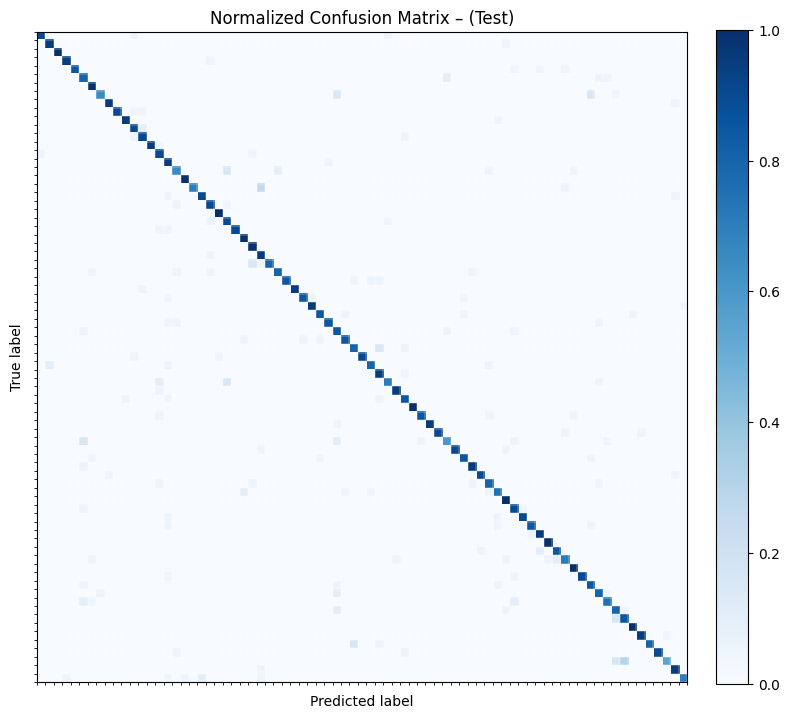

In [ ]:

cm_norm = confusion_matrix(
    truths,
    preds,
    normalize="true",
)

fig, ax = plt.subplots(figsize=(8, 8))  # smaller

disp = ConfusionMatrixDisplay(cm_norm)
disp.plot(
    include_values=False,
    cmap="Blues",
    ax=ax,
    colorbar=False,
)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-0.5, cm_norm.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, cm_norm.shape[0], 1), minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=0.3)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Normalized Confusion Matrix – (Test)")

im = ax.images[0]
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

Training themodel with no-OOV embeddings (variant 2) with the selected best hyperparameters.

In [ ]:
torch.manual_seed(int(best_cfg["seed"])); np.random.seed(int(best_cfg["seed"]))
model = MLPClassifier(D, num_labels, hidden=best_cfg["hidden"], dropout=best_cfg["dropout"]).to(device)
loss_function = nn.CrossEntropyLoss(label_smoothing=best_cfg["label_smoothing"])
optimizer = torch.optim.AdamW(model.parameters(), lr=best_cfg["lr"], weight_decay=best_cfg["weight_decay"])

tr_loader2, va_loader2,te_loader2= make_loaders(X_train2, Y_train, X_valid2, Y_valid,X_test2,Y_test, cfg["batch_size"])

In [ ]:
train(model,30,tr_loader2,va_loader2,optimizer,loss_function,device)

100%|██████████| 40/40 [00:00<00:00, 257.96it/s]


Epoch: 1, Train loss: 4.197, Val loss: 3.991
Train rec: 0.107, Val rec: 0.227
Train f1: 0.093, Val f1: 0.193
Train prec: 0.253, Val prec: 0.345


100%|██████████| 40/40 [00:00<00:00, 263.40it/s]


Epoch: 2, Train loss: 3.587, Val loss: 3.225
Train rec: 0.307, Val rec: 0.437
Train f1: 0.284, Val f1: 0.386
Train prec: 0.448, Val prec: 0.481


100%|██████████| 40/40 [00:00<00:00, 241.27it/s]


Epoch: 3, Train loss: 2.862, Val loss: 2.638
Train rec: 0.468, Val rec: 0.568
Train f1: 0.453, Val f1: 0.536
Train prec: 0.524, Val prec: 0.604


100%|██████████| 40/40 [00:00<00:00, 245.38it/s]


Epoch: 4, Train loss: 2.413, Val loss: 2.315
Train rec: 0.573, Val rec: 0.637
Train f1: 0.563, Val f1: 0.621
Train prec: 0.613, Val prec: 0.691


100%|██████████| 40/40 [00:00<00:00, 264.49it/s]


Epoch: 5, Train loss: 2.142, Val loss: 2.072
Train rec: 0.642, Val rec: 0.701
Train f1: 0.637, Val f1: 0.683
Train prec: 0.695, Val prec: 0.743


100%|██████████| 40/40 [00:00<00:00, 266.98it/s]


Epoch: 6, Train loss: 1.961, Val loss: 1.896
Train rec: 0.699, Val rec: 0.745
Train f1: 0.698, Val f1: 0.735
Train prec: 0.736, Val prec: 0.782


100%|██████████| 40/40 [00:00<00:00, 264.06it/s]


Epoch: 7, Train loss: 1.846, Val loss: 1.776
Train rec: 0.733, Val rec: 0.773
Train f1: 0.733, Val f1: 0.768
Train prec: 0.757, Val prec: 0.790


100%|██████████| 40/40 [00:00<00:00, 245.80it/s]


Epoch: 8, Train loss: 1.754, Val loss: 1.712
Train rec: 0.762, Val rec: 0.790
Train f1: 0.765, Val f1: 0.784
Train prec: 0.786, Val prec: 0.811


100%|██████████| 40/40 [00:00<00:00, 261.58it/s]


Epoch: 9, Train loss: 1.690, Val loss: 1.634
Train rec: 0.785, Val rec: 0.816
Train f1: 0.789, Val f1: 0.814
Train prec: 0.804, Val prec: 0.831


100%|██████████| 40/40 [00:00<00:00, 264.34it/s]


Epoch: 10, Train loss: 1.641, Val loss: 1.574
Train rec: 0.805, Val rec: 0.824
Train f1: 0.808, Val f1: 0.822
Train prec: 0.820, Val prec: 0.836


100%|██████████| 40/40 [00:00<00:00, 267.66it/s]


Epoch: 11, Train loss: 1.596, Val loss: 1.542
Train rec: 0.817, Val rec: 0.826
Train f1: 0.820, Val f1: 0.824
Train prec: 0.828, Val prec: 0.846


100%|██████████| 40/40 [00:00<00:00, 272.43it/s]


Epoch: 12, Train loss: 1.555, Val loss: 1.502
Train rec: 0.822, Val rec: 0.839
Train f1: 0.824, Val f1: 0.839
Train prec: 0.833, Val prec: 0.855


100%|██████████| 40/40 [00:00<00:00, 269.05it/s]


Epoch: 13, Train loss: 1.529, Val loss: 1.469
Train rec: 0.834, Val rec: 0.847
Train f1: 0.837, Val f1: 0.846
Train prec: 0.845, Val prec: 0.859


100%|██████████| 40/40 [00:00<00:00, 265.38it/s]


Epoch: 14, Train loss: 1.497, Val loss: 1.459
Train rec: 0.845, Val rec: 0.849
Train f1: 0.847, Val f1: 0.848
Train prec: 0.855, Val prec: 0.861


100%|██████████| 40/40 [00:00<00:00, 244.93it/s]


Epoch: 15, Train loss: 1.469, Val loss: 1.427
Train rec: 0.849, Val rec: 0.855
Train f1: 0.851, Val f1: 0.854
Train prec: 0.857, Val prec: 0.865


100%|██████████| 40/40 [00:00<00:00, 257.11it/s]


Epoch: 16, Train loss: 1.449, Val loss: 1.412
Train rec: 0.854, Val rec: 0.862
Train f1: 0.856, Val f1: 0.862
Train prec: 0.863, Val prec: 0.874


100%|██████████| 40/40 [00:00<00:00, 258.30it/s]


Epoch: 17, Train loss: 1.430, Val loss: 1.398
Train rec: 0.863, Val rec: 0.859
Train f1: 0.865, Val f1: 0.859
Train prec: 0.871, Val prec: 0.869


100%|██████████| 40/40 [00:00<00:00, 244.94it/s]


Epoch: 18, Train loss: 1.409, Val loss: 1.382
Train rec: 0.866, Val rec: 0.864
Train f1: 0.868, Val f1: 0.863
Train prec: 0.874, Val prec: 0.872


100%|██████████| 40/40 [00:00<00:00, 259.50it/s]


Epoch: 19, Train loss: 1.389, Val loss: 1.368
Train rec: 0.873, Val rec: 0.862
Train f1: 0.874, Val f1: 0.862
Train prec: 0.878, Val prec: 0.875


100%|██████████| 40/40 [00:00<00:00, 259.08it/s]


Epoch: 20, Train loss: 1.376, Val loss: 1.358
Train rec: 0.876, Val rec: 0.871
Train f1: 0.877, Val f1: 0.871
Train prec: 0.882, Val prec: 0.881


100%|██████████| 40/40 [00:00<00:00, 254.68it/s]


Epoch: 21, Train loss: 1.363, Val loss: 1.354
Train rec: 0.880, Val rec: 0.868
Train f1: 0.882, Val f1: 0.867
Train prec: 0.886, Val prec: 0.878


100%|██████████| 40/40 [00:00<00:00, 260.71it/s]


Epoch: 22, Train loss: 1.350, Val loss: 1.335
Train rec: 0.882, Val rec: 0.870
Train f1: 0.883, Val f1: 0.870
Train prec: 0.887, Val prec: 0.879


100%|██████████| 40/40 [00:00<00:00, 262.14it/s]


Epoch: 23, Train loss: 1.336, Val loss: 1.332
Train rec: 0.884, Val rec: 0.876
Train f1: 0.886, Val f1: 0.875
Train prec: 0.890, Val prec: 0.882


100%|██████████| 40/40 [00:00<00:00, 255.33it/s]


Epoch: 24, Train loss: 1.318, Val loss: 1.321
Train rec: 0.889, Val rec: 0.879
Train f1: 0.891, Val f1: 0.879
Train prec: 0.896, Val prec: 0.888


100%|██████████| 40/40 [00:00<00:00, 236.26it/s]


Epoch: 25, Train loss: 1.313, Val loss: 1.317
Train rec: 0.889, Val rec: 0.879
Train f1: 0.891, Val f1: 0.879
Train prec: 0.896, Val prec: 0.888


100%|██████████| 40/40 [00:00<00:00, 257.29it/s]


Epoch: 26, Train loss: 1.305, Val loss: 1.308
Train rec: 0.894, Val rec: 0.877
Train f1: 0.896, Val f1: 0.876
Train prec: 0.900, Val prec: 0.886


100%|██████████| 40/40 [00:00<00:00, 259.44it/s]


Epoch: 27, Train loss: 1.300, Val loss: 1.294
Train rec: 0.894, Val rec: 0.878
Train f1: 0.896, Val f1: 0.877
Train prec: 0.900, Val prec: 0.888


100%|██████████| 40/40 [00:00<00:00, 252.78it/s]


Epoch: 28, Train loss: 1.284, Val loss: 1.284
Train rec: 0.897, Val rec: 0.887
Train f1: 0.899, Val f1: 0.886
Train prec: 0.903, Val prec: 0.896


100%|██████████| 40/40 [00:00<00:00, 242.43it/s]


Epoch: 29, Train loss: 1.277, Val loss: 1.280
Train rec: 0.903, Val rec: 0.881
Train f1: 0.905, Val f1: 0.880
Train prec: 0.908, Val prec: 0.888


100%|██████████| 40/40 [00:00<00:00, 259.74it/s]


Epoch: 30, Train loss: 1.265, Val loss: 1.277
Train rec: 0.906, Val rec: 0.886
Train f1: 0.907, Val f1: 0.886
Train prec: 0.910, Val prec: 0.896


testing

In [ ]:
preds,truths=test(model,te_loader2,loss_function)

 test loss: 1.282, rec: 0.879, f1-score: 0.879, precision: 0.889


confusion matrix

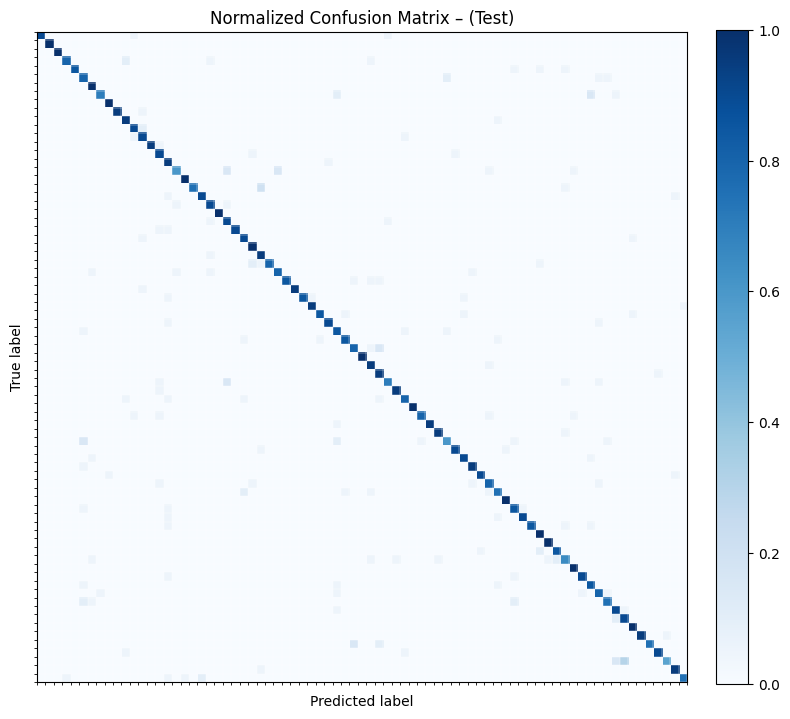

In [ ]:
cm_norm = confusion_matrix(
    truths,
    preds,
    normalize="true",
)

fig, ax = plt.subplots(figsize=(8, 8))

disp = ConfusionMatrixDisplay(cm_norm)
disp.plot(
    include_values=False,
    cmap="Blues",
    ax=ax,
    colorbar=False,
)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-0.5, cm_norm.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, cm_norm.shape[0], 1), minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=0.3)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Normalized Confusion Matrix – (Test)")

im = ax.images[0]
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## Final Performance Summary


*  Variant 1: With OOV (UNK replacement) : macro-F1 ≈ 0.875
*  Variant 2: Ignore OOV tokens : macro-F1 ≈ 0.879 (best Variant)


   → Ignore OOV > Replace OOV with UNK :

*  Slightly better because removing unknown tokens avoids noise in the averaged embedding.
*  Difference is very small because dataset is short and OOV rate is low.




# **Third method**

## Fine-Tuned Transformer Encoders (BERT / DistilBERT)





*   Use pretrained bert-base-uncased and distilbert-base-uncased as contextual encoders. And tokens are embedded with self-attention → representations depend on surrounding context, not isolated words.
*  Sentence vector computed using two pooling strategies:
     - CLS pooling: use the final CLS token as sequence representation.
     - Mean pooling: average all token embeddings.

*   LA linear classification layer outputs logits over the 77 intent classes.
*  Entire model is fine-tuned (encoder + head) using AdamW, with hyperparameters selected via validation macro-F1.






## load the dataset

In [ ]:
from datasets import load_dataset

data = load_dataset('banking77')

# splits: train (10k) and test (3k)
train_data = data['train']
test_data = data['test']


# test_data -> (test_data, valid_data)
SEED = 42
split = test_data.train_test_split(
    test_size=0.50,
    seed=SEED,
    stratify_by_column="label",   #keep class proportions
)

valid_data = split["train"]
test_data = split["test"]


labels = train_data.features["label"].names
num_labels = len(labels)

print(f"Train={len(train_data)}  Valid={len(valid_data)} Test={len(test_data)} ")
print("Example:", train_data[0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/298k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/93.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

Train=10003  Valid=1540 Test=1540 
Example: {'text': 'I am still waiting on my card?', 'label': 11}


## Distelbert (CLS pooling)

model's tokenizer and preprocessing

In [ ]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

def num_tokens(txt: str) -> int:
    # count *model tokens* including [CLS]/[SEP] etc.
    return len(tokenizer(txt, add_special_tokens=True, truncation=False)["input_ids"])

# compute lengths for each split
lens_train = [num_tokens(r["text"]) for r in train_data]
lens_valid = [num_tokens(r["text"]) for r in valid_data]
lens_test  = [num_tokens(r["text"]) for r in test_data]


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
import numpy as np

def describe(name, arr):
    a = np.array(arr)
    print(f"{name:8s} | n={len(a):5d}  mean={a.mean():5.1f}  p90={np.percentile(a,90):4.0f}  "
          f"p95={np.percentile(a,95):4.0f}  p99={np.percentile(a,99):4.0f}  max={a.max():4d}")

describe("train", lens_train)
describe("valid", lens_valid)
describe("test",  lens_test)

train    | n=10003  mean= 16.2  p90=  28  p95=  37  p99=  53  max=  98
valid    | n= 1540  mean= 15.0  p90=  23  p95=  30  p99=  46  max=  82
test     | n= 1540  mean= 15.1  p90=  24  p95=  32  p99=  49  max=  81


In [ ]:
from transformers import  DataCollatorWithPadding
from datasets import  DatasetDict

def preprocessing(data):
  return tokenizer(data["text"], truncation=True,max_length=64)

ds = DatasetDict({"train": train_data, "validation": valid_data, "test": test_data})
enc = ds.map(preprocessing, batched=True, remove_columns=["text"])
collator = DataCollatorWithPadding(tokenizer)


Map:   0%|          | 0/10003 [00:00<?, ? examples/s]

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

dataloaders

In [ ]:
import torch
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(enc["train"], batch_size=64, shuffle=True,  collate_fn=collator, pin_memory=True)
valid_loader = DataLoader(enc["validation"], batch_size=64, shuffle=False, collate_fn=collator, pin_memory=True)
test_loader  = DataLoader(enc["test"], batch_size=64, shuffle=False, collate_fn=collator, pin_memory=True)




Model

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel


class Model(nn.Module):
  """
  distilbert/ bert+ small head
  pooling strategy: cls or mean
  """
  def __init__(self,model_name,num_labels,pooling="cls"):
    super().__init__()
    self.pooling=pooling
    self.model=AutoModel.from_pretrained(model_name)
    self.hidden_size=self.model.config.hidden_size  #768
    self.head=nn.Linear(self.hidden_size,num_labels)

  def forward(self,x):
    out = self.model(input_ids=x["input_ids"],attention_mask=x["attention_mask"],return_dict=True)
    H= out.last_hidden_state # [B,T,H]
    if self.pooling == "cls":
      return self.head(H[:,0])

    mask=x['attention_mask'].unsqueeze(-1).float() # [B,T,1]
    out= (H * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6) # [B,H]
    return self.head(out)



Train and validation functions

In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch
import torch.nn as nn

def metrics(logits_t: torch.Tensor, labels_t: torch.Tensor):
    y_true = labels_t.numpy()
    y_pred = logits_t.argmax(dim=1).numpy()
    acc  = accuracy_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred, average="macro")
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
    return rec, f1, prec, y_pred, y_true

def train_epoch(model, train_loader, optimizer, scheduler, loss_fn, device, max_grad_norm=1.0):
    model.train()
    total_loss = 0.0
    all_logits, all_labels = [], []
    for batch in tqdm(train_loader):
        labels = batch["labels"].to(device, non_blocking=True)
        inputs = {
            "input_ids": batch["input_ids"].to(device, non_blocking=True),
            "attention_mask": batch["attention_mask"].to(device, non_blocking=True),
        }

        optimizer.zero_grad(set_to_none=True)
        logits = model(inputs)
        loss = loss_fn(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        all_logits.append(logits.detach().cpu())
        all_labels.append(labels.detach().cpu())

    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    rec, f1, prec,_,_ = metrics(all_logits, all_labels)
    return total_loss / len(train_loader), rec, f1, prec

def eval_epoch(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    all_logits, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(loader):
            labels = batch["labels"].to(device, non_blocking=True)
            inputs = {
                "input_ids": batch["input_ids"].to(device, non_blocking=True),
                "attention_mask": batch["attention_mask"].to(device, non_blocking=True),
            }
            logits = model(inputs)
            loss = loss_fn(logits, labels)

            total_loss += loss.item()
            all_logits.append(logits.cpu())
            all_labels.append(labels.cpu())

    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    rec, f1, prec,_,_ = metrics(all_logits, all_labels)
    return total_loss / len(loader), rec, f1, prec


building the first model distilbert to train it for 15epochs before doing hyperparameters tuning

In [ ]:
from transformers import get_linear_schedule_with_warmup


model_name = "distilbert-base-uncased"
model = Model(model_name, num_labels, pooling="cls").to(device)
print(device)
loss_function=nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
epochs= 15
total_steps = epochs * len(train_loader)
warmup_steps= int(total_steps*0.06)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

print(f"Device: {device} | steps/epoch: {len(train_loader)} | total_steps: {total_steps} | warmup: {warmup_steps}")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

cuda
Device: cuda | steps/epoch: 157 | total_steps: 2355 | warmup: 141


Training

In [ ]:
def train(model, epochs, train_loader,valid_loader,optimizer,scheduler,loss_function,device ):
  for epoch in range(1, epochs+1):
        train_loss, train_rec, train_f1, train_prec = train_epoch(model,train_loader,optimizer,scheduler,loss_function,device)
        val_loss, val_rec, val_f1, val_prec = eval_epoch(model,valid_loader,loss_function,device)
        print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}"))
        print((f"Train rec: {train_rec:.3f}, Val rec: {val_rec:.3f}"))
        print((f"Train f1: {train_f1:.3f}, Val f1: {val_f1:.3f}"))
        print((f"Train prec: {train_prec:.3f}, Val prec: {val_prec:.3f}"))
  return val_rec, val_f1, val_prec

In [ ]:
train(model,epochs,train_loader,valid_loader,optimizer,scheduler,loss_function,device)




100%|██████████| 25/25 [00:01<00:00, 13.07it/s]


Epoch: 1, Train loss: 3.930, Val loss: 2.587
Train rec: 0.154, Val rec: 0.581
Train f1: 0.170, Val f1: 0.524
Train prec: 0.366, Val prec: 0.601


100%|██████████| 25/25 [00:02<00:00, 11.93it/s]


Epoch: 2, Train loss: 1.656, Val loss: 0.995
Train rec: 0.715, Val rec: 0.801
Train f1: 0.710, Val f1: 0.791
Train prec: 0.750, Val prec: 0.826


100%|██████████| 25/25 [00:02<00:00, 12.15it/s]


Epoch: 3, Train loss: 0.750, Val loss: 0.612
Train rec: 0.864, Val rec: 0.876
Train f1: 0.867, Val f1: 0.876
Train prec: 0.881, Val prec: 0.892


100%|██████████| 25/25 [00:02<00:00, 11.66it/s]


Epoch: 4, Train loss: 0.453, Val loss: 0.462
Train rec: 0.914, Val rec: 0.900
Train f1: 0.916, Val f1: 0.899
Train prec: 0.921, Val prec: 0.906


100%|██████████| 25/25 [00:02<00:00, 11.67it/s]


Epoch: 5, Train loss: 0.306, Val loss: 0.393
Train rec: 0.942, Val rec: 0.914
Train f1: 0.944, Val f1: 0.913
Train prec: 0.946, Val prec: 0.922


100%|██████████| 25/25 [00:02<00:00, 11.52it/s]


Epoch: 6, Train loss: 0.219, Val loss: 0.383
Train rec: 0.959, Val rec: 0.912
Train f1: 0.960, Val f1: 0.913
Train prec: 0.962, Val prec: 0.922


100%|██████████| 25/25 [00:02<00:00, 11.53it/s]


Epoch: 7, Train loss: 0.163, Val loss: 0.358
Train rec: 0.972, Val rec: 0.919
Train f1: 0.973, Val f1: 0.919
Train prec: 0.974, Val prec: 0.926


100%|██████████| 25/25 [00:02<00:00, 11.33it/s]


Epoch: 8, Train loss: 0.121, Val loss: 0.364
Train rec: 0.983, Val rec: 0.916
Train f1: 0.983, Val f1: 0.915
Train prec: 0.984, Val prec: 0.922


100%|██████████| 25/25 [00:02<00:00, 11.39it/s]


Epoch: 9, Train loss: 0.091, Val loss: 0.344
Train rec: 0.988, Val rec: 0.919
Train f1: 0.989, Val f1: 0.919
Train prec: 0.989, Val prec: 0.928


100%|██████████| 25/25 [00:02<00:00, 11.42it/s]


Epoch: 10, Train loss: 0.073, Val loss: 0.353
Train rec: 0.991, Val rec: 0.924
Train f1: 0.991, Val f1: 0.924
Train prec: 0.991, Val prec: 0.930


100%|██████████| 25/25 [00:02<00:00, 11.42it/s]


Epoch: 11, Train loss: 0.060, Val loss: 0.361
Train rec: 0.993, Val rec: 0.921
Train f1: 0.993, Val f1: 0.921
Train prec: 0.993, Val prec: 0.930


100%|██████████| 25/25 [00:02<00:00, 11.36it/s]


Epoch: 12, Train loss: 0.047, Val loss: 0.345
Train rec: 0.996, Val rec: 0.927
Train f1: 0.997, Val f1: 0.927
Train prec: 0.997, Val prec: 0.933


100%|██████████| 25/25 [00:02<00:00, 11.39it/s]


Epoch: 13, Train loss: 0.040, Val loss: 0.341
Train rec: 0.997, Val rec: 0.925
Train f1: 0.996, Val f1: 0.924
Train prec: 0.996, Val prec: 0.931


100%|██████████| 25/25 [00:02<00:00, 11.37it/s]


Epoch: 14, Train loss: 0.037, Val loss: 0.344
Train rec: 0.998, Val rec: 0.927
Train f1: 0.998, Val f1: 0.926
Train prec: 0.997, Val prec: 0.933


100%|██████████| 25/25 [00:02<00:00, 11.32it/s]

Epoch: 15, Train loss: 0.033, Val loss: 0.343
Train rec: 0.998, Val rec: 0.925
Train f1: 0.998, Val f1: 0.925
Train prec: 0.997, Val prec: 0.932


(0.9253246753246755, 0.9249488422319174, 0.9315442910841866)

Testing

In [ ]:
@torch.no_grad()
def evaluate(model, test_loader, device):
    model.eval()
    all_logits  = []
    all_labels = []

    for batch in test_loader:
        labels = batch["labels"].to(device, non_blocking=True)
        inputs = {
                "input_ids": batch["input_ids"].to(device, non_blocking=True),
                "attention_mask": batch["attention_mask"].to(device, non_blocking=True),
            }

        logits = model(inputs)          # [B, num_labels]



        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())

    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    rec, f1, prec,preds,truths = metrics(all_logits, all_labels)
    return rec, f1,prec,preds,truths

In [ ]:
def test(model, test_loader ,device):
        rec, f1, prec,preds,truths = evaluate(model,test_loader,device)
        print((f"  recall: {rec:.3f}, f1-score: {f1:.3f}, precision: {prec:.3f}"))
        return preds,truths

In [ ]:
preds,truths=test(model,test_loader,device)


  recall: 0.932, f1-score: 0.932, precision: 0.935


Tuning hyperparameters

In [ ]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
import torch, itertools
import torch.nn as nn

model_name = "distilbert-base-uncased"

def run_experiment(config,model_name,pooling, train_loader, valid_loader, num_labels, device,return_model=False):
    """
    config: dict with keys: lr, weight_decay, warmup_ratio, epochs
    returns: dict with val metrics + config
    """

    #model instance
    model = Model(model_name, num_labels, pooling=pooling).to(device)

    loss_function = nn.CrossEntropyLoss()
    optimizer = AdamW(
        model.parameters(),
        lr=config["lr"],
        weight_decay=config["weight_decay"],
    )

    epochs = config["epochs"]
    total_steps  = epochs * len(train_loader)
    warmup_steps = int(total_steps * config["warmup_ratio"])

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    print(
        f"[CONFIG] lr={config['lr']} | wd={config['weight_decay']} | "
        f"warmup={config['warmup_ratio']} | epochs={epochs}"
    )

    # return best val metrics
    best_val_acc, best_val_prec, best_val_f1 = train(
        model,
        epochs,
        train_loader,
        valid_loader,
        optimizer,
        scheduler,
        loss_function,
        device
    )

    torch.cuda.empty_cache()
    result = {
        ""
        "config": config,
        "best_val_acc": best_val_acc,
        "best_val_f1": best_val_f1,
    }

    if return_model:
        result["model"] = model


    if not return_model and torch.cuda.is_available():
        torch.cuda.empty_cache()

    return result


In [ ]:
search_space = {
    "lr": [1e-5, 2e-5, 3e-5],
    "weight_decay": [0.0, 0.01],
    "warmup_ratio": [0.0, 0.06, 0.1],
    "batch_size": [64,128, 256],
    "epochs": [5],  # because of limited resources
}

configs = []
for lr, wd, wr, bs, ep in itertools.product(
    search_space["lr"],
    search_space["weight_decay"],
    search_space["warmup_ratio"],
    search_space["batch_size"],
    search_space["epochs"],
):
    configs.append({
        "lr": lr,
        "weight_decay": wd,
        "warmup_ratio": wr,
        "batch_size": bs,
        "epochs": ep,
    })

print("Total configs:", len(configs))

all_results = []
best_result = None

for i, cfg in enumerate(configs, 1):
    print("=" * 80)
    print(f"Running config {i}/{len(configs)}: {cfg}")
    # data loaders
    train_loader = DataLoader(enc["train"], batch_size=cfg['batch_size'], shuffle=True,  collate_fn=collator, pin_memory=True)
    valid_loader = DataLoader(enc["validation"], batch_size=cfg['batch_size'], shuffle=False, collate_fn=collator, pin_memory=True)
    test_loader  = DataLoader(enc["test"], batch_size=cfg['batch_size'], shuffle=False, collate_fn=collator, pin_memory=True)

    # training
    result = run_experiment(cfg,model_name,"cls", train_loader, valid_loader, num_labels, device)
    all_results.append(result)

    if best_result is None or result["best_val_f1"] > best_result["best_val_f1"]:
        best_result = result
        print(f"--> New best F1: {best_result['best_val_f1']:.4f}")

print("\n===== SEARCH DONE =====")
print("Best config:", best_result["config"])
print(
    f"Best val acc: {best_result['best_val_acc']:.4f} | "
    f"Best val macro-F1: {best_result['best_val_f1']:.4f}"
)


Total configs: 54
Running config 1/54: {'lr': 1e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.0, 'batch_size': 64, 'epochs': 5}
[CONFIG] lr=1e-05 | wd=0.0 | warmup=0.0 | epochs=5


100%|██████████| 25/25 [00:01<00:00, 13.36it/s]


Epoch: 1, Train loss: 3.912, Val loss: 3.104
Train rec: 0.163, Val rec: 0.447
Train f1: 0.165, Val f1: 0.412
Train prec: 0.327, Val prec: 0.513


100%|██████████| 25/25 [00:02<00:00, 12.24it/s]


Epoch: 2, Train loss: 2.551, Val loss: 2.001
Train rec: 0.552, Val rec: 0.672
Train f1: 0.538, Val f1: 0.644
Train prec: 0.620, Val prec: 0.682


100%|██████████| 25/25 [00:01<00:00, 12.71it/s]


Epoch: 3, Train loss: 1.813, Val loss: 1.517
Train rec: 0.701, Val rec: 0.753
Train f1: 0.692, Val f1: 0.734
Train prec: 0.747, Val prec: 0.777


100%|██████████| 25/25 [00:02<00:00, 12.40it/s]


Epoch: 4, Train loss: 1.465, Val loss: 1.303
Train rec: 0.767, Val rec: 0.784
Train f1: 0.763, Val f1: 0.769
Train prec: 0.808, Val prec: 0.795


100%|██████████| 25/25 [00:01<00:00, 12.56it/s]


Epoch: 5, Train loss: 1.319, Val loss: 1.239
Train rec: 0.796, Val rec: 0.794
Train f1: 0.793, Val f1: 0.779
Train prec: 0.828, Val prec: 0.803
--> New best F1: 0.8030
Running config 2/54: {'lr': 1e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.0, 'batch_size': 128, 'epochs': 5}
[CONFIG] lr=1e-05 | wd=0.0 | warmup=0.0 | epochs=5


100%|██████████| 13/13 [00:02<00:00,  5.86it/s]


Epoch: 1, Train loss: 4.102, Val loss: 3.622
Train rec: 0.104, Val rec: 0.312
Train f1: 0.093, Val f1: 0.260
Train prec: 0.186, Val prec: 0.384


100%|██████████| 13/13 [00:02<00:00,  5.79it/s]


Epoch: 2, Train loss: 3.182, Val loss: 2.692
Train rec: 0.421, Val rec: 0.548
Train f1: 0.398, Val f1: 0.509
Train prec: 0.531, Val prec: 0.577


100%|██████████| 13/13 [00:02<00:00,  5.81it/s]


Epoch: 3, Train loss: 2.499, Val loss: 2.194
Train rec: 0.573, Val rec: 0.642
Train f1: 0.553, Val f1: 0.605
Train prec: 0.623, Val prec: 0.658


100%|██████████| 13/13 [00:02<00:00,  5.85it/s]


Epoch: 4, Train loss: 2.136, Val loss: 1.946
Train rec: 0.638, Val rec: 0.683
Train f1: 0.621, Val f1: 0.653
Train prec: 0.696, Val prec: 0.705


100%|██████████| 13/13 [00:02<00:00,  5.82it/s]


Epoch: 5, Train loss: 1.975, Val loss: 1.874
Train rec: 0.674, Val rec: 0.694
Train f1: 0.658, Val f1: 0.665
Train prec: 0.733, Val prec: 0.711
Running config 3/54: {'lr': 1e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.0, 'batch_size': 256, 'epochs': 5}
[CONFIG] lr=1e-05 | wd=0.0 | warmup=0.0 | epochs=5


100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


Epoch: 1, Train loss: 4.274, Val loss: 4.114
Train rec: 0.037, Val rec: 0.123
Train f1: 0.024, Val f1: 0.070
Train prec: 0.064, Val prec: 0.090


100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


Epoch: 2, Train loss: 3.868, Val loss: 3.596
Train rec: 0.217, Val rec: 0.365
Train f1: 0.179, Val f1: 0.305
Train prec: 0.288, Val prec: 0.381


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch: 3, Train loss: 3.395, Val loss: 3.165
Train rec: 0.408, Val rec: 0.493
Train f1: 0.382, Val f1: 0.451
Train prec: 0.507, Val prec: 0.530


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch: 4, Train loss: 3.068, Val loss: 2.925
Train rec: 0.501, Val rec: 0.540
Train f1: 0.477, Val f1: 0.502
Train prec: 0.567, Val prec: 0.565


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 5, Train loss: 2.919, Val loss: 2.845
Train rec: 0.534, Val rec: 0.547
Train f1: 0.513, Val f1: 0.510
Train prec: 0.602, Val prec: 0.578
Running config 4/54: {'lr': 1e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'batch_size': 64, 'epochs': 5}
[CONFIG] lr=1e-05 | wd=0.0 | warmup=0.06 | epochs=5


100%|██████████| 25/25 [00:02<00:00, 12.44it/s]


Epoch: 1, Train loss: 3.968, Val loss: 3.085
Train rec: 0.141, Val rec: 0.442
Train f1: 0.151, Val f1: 0.388
Train prec: 0.365, Val prec: 0.470


100%|██████████| 25/25 [00:02<00:00, 12.45it/s]


Epoch: 2, Train loss: 2.479, Val loss: 1.893
Train rec: 0.572, Val rec: 0.673
Train f1: 0.557, Val f1: 0.644
Train prec: 0.649, Val prec: 0.703


100%|██████████| 25/25 [00:01<00:00, 12.53it/s]


Epoch: 3, Train loss: 1.698, Val loss: 1.405
Train rec: 0.722, Val rec: 0.756
Train f1: 0.716, Val f1: 0.741
Train prec: 0.765, Val prec: 0.772


100%|██████████| 25/25 [00:02<00:00, 12.42it/s]


Epoch: 4, Train loss: 1.360, Val loss: 1.203
Train rec: 0.782, Val rec: 0.786
Train f1: 0.781, Val f1: 0.774
Train prec: 0.815, Val prec: 0.803


100%|██████████| 25/25 [00:02<00:00, 12.45it/s]


Epoch: 5, Train loss: 1.216, Val loss: 1.142
Train rec: 0.805, Val rec: 0.795
Train f1: 0.804, Val f1: 0.785
Train prec: 0.828, Val prec: 0.812
--> New best F1: 0.8124
Running config 5/54: {'lr': 1e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'batch_size': 128, 'epochs': 5}
[CONFIG] lr=1e-05 | wd=0.0 | warmup=0.06 | epochs=5


100%|██████████| 13/13 [00:02<00:00,  5.82it/s]


Epoch: 1, Train loss: 4.175, Val loss: 3.778
Train rec: 0.065, Val rec: 0.242
Train f1: 0.055, Val f1: 0.191
Train prec: 0.171, Val prec: 0.278


100%|██████████| 13/13 [00:02<00:00,  5.74it/s]


Epoch: 2, Train loss: 3.278, Val loss: 2.800
Train rec: 0.407, Val rec: 0.559
Train f1: 0.387, Val f1: 0.516
Train prec: 0.493, Val prec: 0.585


100%|██████████| 13/13 [00:02<00:00,  5.87it/s]


Epoch: 3, Train loss: 2.554, Val loss: 2.257
Train rec: 0.580, Val rec: 0.645
Train f1: 0.563, Val f1: 0.612
Train prec: 0.660, Val prec: 0.653


100%|██████████| 13/13 [00:02<00:00,  5.86it/s]


Epoch: 4, Train loss: 2.168, Val loss: 1.989
Train rec: 0.657, Val rec: 0.678
Train f1: 0.643, Val f1: 0.646
Train prec: 0.726, Val prec: 0.693


100%|██████████| 13/13 [00:02<00:00,  5.82it/s]


Epoch: 5, Train loss: 1.995, Val loss: 1.910
Train rec: 0.686, Val rec: 0.689
Train f1: 0.673, Val f1: 0.656
Train prec: 0.728, Val prec: 0.704
Running config 6/54: {'lr': 1e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'batch_size': 256, 'epochs': 5}
[CONFIG] lr=1e-05 | wd=0.0 | warmup=0.06 | epochs=5


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


Epoch: 1, Train loss: 4.291, Val loss: 4.132
Train rec: 0.028, Val rec: 0.062
Train f1: 0.015, Val f1: 0.036
Train prec: 0.026, Val prec: 0.046


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


Epoch: 2, Train loss: 3.888, Val loss: 3.599
Train rec: 0.159, Val rec: 0.306
Train f1: 0.141, Val f1: 0.264
Train prec: 0.298, Val prec: 0.369


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 3, Train loss: 3.404, Val loss: 3.154
Train rec: 0.372, Val rec: 0.480
Train f1: 0.355, Val f1: 0.449
Train prec: 0.457, Val prec: 0.521


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch: 4, Train loss: 3.066, Val loss: 2.896
Train rec: 0.488, Val rec: 0.545
Train f1: 0.475, Val f1: 0.514
Train prec: 0.551, Val prec: 0.568


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch: 5, Train loss: 2.892, Val loss: 2.814
Train rec: 0.534, Val rec: 0.560
Train f1: 0.521, Val f1: 0.530
Train prec: 0.598, Val prec: 0.573
Running config 7/54: {'lr': 1e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 64, 'epochs': 5}
[CONFIG] lr=1e-05 | wd=0.0 | warmup=0.1 | epochs=5


100%|██████████| 25/25 [00:02<00:00, 12.46it/s]


Epoch: 1, Train loss: 4.048, Val loss: 3.233
Train rec: 0.120, Val rec: 0.416
Train f1: 0.130, Val f1: 0.363
Train prec: 0.262, Val prec: 0.436


100%|██████████| 25/25 [00:01<00:00, 12.52it/s]


Epoch: 2, Train loss: 2.580, Val loss: 1.953
Train rec: 0.541, Val rec: 0.656
Train f1: 0.526, Val f1: 0.619
Train prec: 0.622, Val prec: 0.669


100%|██████████| 25/25 [00:01<00:00, 12.53it/s]


Epoch: 3, Train loss: 1.750, Val loss: 1.430
Train rec: 0.697, Val rec: 0.747
Train f1: 0.691, Val f1: 0.729
Train prec: 0.750, Val prec: 0.777


100%|██████████| 25/25 [00:01<00:00, 12.52it/s]


Epoch: 4, Train loss: 1.385, Val loss: 1.213
Train rec: 0.769, Val rec: 0.787
Train f1: 0.769, Val f1: 0.774
Train prec: 0.809, Val prec: 0.808


100%|██████████| 25/25 [00:02<00:00, 12.49it/s]


Epoch: 5, Train loss: 1.238, Val loss: 1.151
Train rec: 0.799, Val rec: 0.794
Train f1: 0.800, Val f1: 0.781
Train prec: 0.827, Val prec: 0.814
--> New best F1: 0.8140
Running config 8/54: {'lr': 1e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 128, 'epochs': 5}
[CONFIG] lr=1e-05 | wd=0.0 | warmup=0.1 | epochs=5


100%|██████████| 13/13 [00:02<00:00,  5.81it/s]


Epoch: 1, Train loss: 4.216, Val loss: 3.834
Train rec: 0.055, Val rec: 0.260
Train f1: 0.056, Val f1: 0.208
Train prec: 0.166, Val prec: 0.304


100%|██████████| 13/13 [00:02<00:00,  5.73it/s]


Epoch: 2, Train loss: 3.297, Val loss: 2.762
Train rec: 0.413, Val rec: 0.566
Train f1: 0.389, Val f1: 0.526
Train prec: 0.493, Val prec: 0.581


100%|██████████| 13/13 [00:02<00:00,  5.82it/s]


Epoch: 3, Train loss: 2.496, Val loss: 2.173
Train rec: 0.602, Val rec: 0.665
Train f1: 0.579, Val f1: 0.627
Train prec: 0.662, Val prec: 0.640


100%|██████████| 13/13 [00:02<00:00,  5.85it/s]


Epoch: 4, Train loss: 2.080, Val loss: 1.904
Train rec: 0.669, Val rec: 0.703
Train f1: 0.650, Val f1: 0.669
Train prec: 0.702, Val prec: 0.695


100%|██████████| 13/13 [00:02<00:00,  5.79it/s]


Epoch: 5, Train loss: 1.904, Val loss: 1.822
Train rec: 0.696, Val rec: 0.712
Train f1: 0.681, Val f1: 0.678
Train prec: 0.738, Val prec: 0.700
Running config 9/54: {'lr': 1e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 256, 'epochs': 5}
[CONFIG] lr=1e-05 | wd=0.0 | warmup=0.1 | epochs=5


100%|██████████| 7/7 [00:02<00:00,  2.82it/s]


Epoch: 1, Train loss: 4.327, Val loss: 4.230
Train rec: 0.019, Val rec: 0.042
Train f1: 0.012, Val f1: 0.023
Train prec: 0.018, Val prec: 0.036


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 2, Train loss: 3.979, Val loss: 3.709
Train rec: 0.137, Val rec: 0.314
Train f1: 0.120, Val f1: 0.257
Train prec: 0.278, Val prec: 0.314


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 3, Train loss: 3.482, Val loss: 3.227
Train rec: 0.370, Val rec: 0.486
Train f1: 0.337, Val f1: 0.439
Train prec: 0.473, Val prec: 0.546


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch: 4, Train loss: 3.122, Val loss: 2.952
Train rec: 0.496, Val rec: 0.560
Train f1: 0.472, Val f1: 0.521
Train prec: 0.579, Val prec: 0.633


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 5, Train loss: 2.943, Val loss: 2.863
Train rec: 0.538, Val rec: 0.578
Train f1: 0.515, Val f1: 0.540
Train prec: 0.613, Val prec: 0.647
Running config 10/54: {'lr': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.0, 'batch_size': 64, 'epochs': 5}
[CONFIG] lr=1e-05 | wd=0.01 | warmup=0.0 | epochs=5


100%|██████████| 25/25 [00:02<00:00, 12.46it/s]


Epoch: 1, Train loss: 3.813, Val loss: 2.973
Train rec: 0.190, Val rec: 0.475
Train f1: 0.192, Val f1: 0.429
Train prec: 0.341, Val prec: 0.521


100%|██████████| 25/25 [00:02<00:00, 12.50it/s]


Epoch: 2, Train loss: 2.460, Val loss: 1.926
Train rec: 0.575, Val rec: 0.678
Train f1: 0.560, Val f1: 0.648
Train prec: 0.637, Val prec: 0.708


100%|██████████| 25/25 [00:01<00:00, 12.58it/s]


Epoch: 3, Train loss: 1.763, Val loss: 1.481
Train rec: 0.701, Val rec: 0.743
Train f1: 0.690, Val f1: 0.719
Train prec: 0.749, Val prec: 0.755


100%|██████████| 25/25 [00:02<00:00, 12.35it/s]


Epoch: 4, Train loss: 1.438, Val loss: 1.283
Train rec: 0.766, Val rec: 0.767
Train f1: 0.760, Val f1: 0.749
Train prec: 0.805, Val prec: 0.795


100%|██████████| 25/25 [00:01<00:00, 12.57it/s]


Epoch: 5, Train loss: 1.297, Val loss: 1.221
Train rec: 0.789, Val rec: 0.779
Train f1: 0.786, Val f1: 0.763
Train prec: 0.823, Val prec: 0.803
Running config 11/54: {'lr': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.0, 'batch_size': 128, 'epochs': 5}
[CONFIG] lr=1e-05 | wd=0.01 | warmup=0.0 | epochs=5


100%|██████████| 13/13 [00:02<00:00,  5.81it/s]


Epoch: 1, Train loss: 4.122, Val loss: 3.663
Train rec: 0.107, Val rec: 0.307
Train f1: 0.096, Val f1: 0.233
Train prec: 0.207, Val prec: 0.251


100%|██████████| 13/13 [00:02<00:00,  5.74it/s]


Epoch: 2, Train loss: 3.223, Val loss: 2.756
Train rec: 0.420, Val rec: 0.551
Train f1: 0.383, Val f1: 0.499
Train prec: 0.510, Val prec: 0.567


100%|██████████| 13/13 [00:02<00:00,  5.84it/s]


Epoch: 3, Train loss: 2.556, Val loss: 2.246
Train rec: 0.577, Val rec: 0.630
Train f1: 0.551, Val f1: 0.587
Train prec: 0.642, Val prec: 0.646


100%|██████████| 13/13 [00:02<00:00,  5.83it/s]


Epoch: 4, Train loss: 2.191, Val loss: 1.994
Train rec: 0.644, Val rec: 0.677
Train f1: 0.625, Val f1: 0.644
Train prec: 0.698, Val prec: 0.702


100%|██████████| 13/13 [00:02<00:00,  5.84it/s]


Epoch: 5, Train loss: 2.029, Val loss: 1.919
Train rec: 0.681, Val rec: 0.685
Train f1: 0.667, Val f1: 0.654
Train prec: 0.744, Val prec: 0.703
Running config 12/54: {'lr': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.0, 'batch_size': 256, 'epochs': 5}
[CONFIG] lr=1e-05 | wd=0.01 | warmup=0.0 | epochs=5


100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


Epoch: 1, Train loss: 4.274, Val loss: 4.118
Train rec: 0.034, Val rec: 0.105
Train f1: 0.024, Val f1: 0.061
Train prec: 0.070, Val prec: 0.082


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


Epoch: 2, Train loss: 3.881, Val loss: 3.619
Train rec: 0.200, Val rec: 0.364
Train f1: 0.173, Val f1: 0.312
Train prec: 0.329, Val prec: 0.379


100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


Epoch: 3, Train loss: 3.442, Val loss: 3.213
Train rec: 0.405, Val rec: 0.499
Train f1: 0.376, Val f1: 0.451
Train prec: 0.505, Val prec: 0.597


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch: 4, Train loss: 3.128, Val loss: 2.977
Train rec: 0.493, Val rec: 0.551
Train f1: 0.461, Val f1: 0.502
Train prec: 0.573, Val prec: 0.601


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch: 5, Train loss: 2.973, Val loss: 2.901
Train rec: 0.531, Val rec: 0.563
Train f1: 0.502, Val f1: 0.516
Train prec: 0.608, Val prec: 0.620
Running config 13/54: {'lr': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'batch_size': 64, 'epochs': 5}
[CONFIG] lr=1e-05 | wd=0.01 | warmup=0.06 | epochs=5


100%|██████████| 25/25 [00:02<00:00, 12.39it/s]


Epoch: 1, Train loss: 3.958, Val loss: 3.112
Train rec: 0.142, Val rec: 0.461
Train f1: 0.147, Val f1: 0.405
Train prec: 0.303, Val prec: 0.502


100%|██████████| 25/25 [00:02<00:00, 12.42it/s]


Epoch: 2, Train loss: 2.551, Val loss: 1.970
Train rec: 0.553, Val rec: 0.670
Train f1: 0.534, Val f1: 0.635
Train prec: 0.631, Val prec: 0.668


100%|██████████| 25/25 [00:02<00:00, 12.42it/s]


Epoch: 3, Train loss: 1.774, Val loss: 1.482
Train rec: 0.710, Val rec: 0.749
Train f1: 0.703, Val f1: 0.727
Train prec: 0.770, Val prec: 0.777


100%|██████████| 25/25 [00:02<00:00, 12.37it/s]


Epoch: 4, Train loss: 1.419, Val loss: 1.259
Train rec: 0.766, Val rec: 0.786
Train f1: 0.762, Val f1: 0.773
Train prec: 0.807, Val prec: 0.800


100%|██████████| 25/25 [00:02<00:00, 12.48it/s]


Epoch: 5, Train loss: 1.268, Val loss: 1.200
Train rec: 0.800, Val rec: 0.799
Train f1: 0.801, Val f1: 0.787
Train prec: 0.828, Val prec: 0.812
Running config 14/54: {'lr': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'batch_size': 128, 'epochs': 5}
[CONFIG] lr=1e-05 | wd=0.01 | warmup=0.06 | epochs=5


100%|██████████| 13/13 [00:02<00:00,  5.79it/s]


Epoch: 1, Train loss: 4.198, Val loss: 3.765
Train rec: 0.063, Val rec: 0.277
Train f1: 0.053, Val f1: 0.216
Train prec: 0.130, Val prec: 0.285


100%|██████████| 13/13 [00:02<00:00,  5.82it/s]


Epoch: 2, Train loss: 3.291, Val loss: 2.762
Train rec: 0.412, Val rec: 0.592
Train f1: 0.384, Val f1: 0.548
Train prec: 0.487, Val prec: 0.624


100%|██████████| 13/13 [00:02<00:00,  5.70it/s]


Epoch: 3, Train loss: 2.539, Val loss: 2.204
Train rec: 0.602, Val rec: 0.660
Train f1: 0.576, Val f1: 0.618
Train prec: 0.670, Val prec: 0.682


100%|██████████| 13/13 [00:02<00:00,  5.81it/s]


Epoch: 4, Train loss: 2.137, Val loss: 1.937
Train rec: 0.664, Val rec: 0.690
Train f1: 0.642, Val f1: 0.654
Train prec: 0.725, Val prec: 0.713


100%|██████████| 13/13 [00:02<00:00,  5.81it/s]


Epoch: 5, Train loss: 1.959, Val loss: 1.856
Train rec: 0.691, Val rec: 0.706
Train f1: 0.673, Val f1: 0.672
Train prec: 0.752, Val prec: 0.739
Running config 15/54: {'lr': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'batch_size': 256, 'epochs': 5}
[CONFIG] lr=1e-05 | wd=0.01 | warmup=0.06 | epochs=5


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch: 1, Train loss: 4.311, Val loss: 4.176
Train rec: 0.028, Val rec: 0.076
Train f1: 0.018, Val f1: 0.043
Train prec: 0.037, Val prec: 0.066


100%|██████████| 7/7 [00:02<00:00,  2.82it/s]


Epoch: 2, Train loss: 3.911, Val loss: 3.612
Train rec: 0.161, Val rec: 0.330
Train f1: 0.138, Val f1: 0.268
Train prec: 0.265, Val prec: 0.335


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch: 3, Train loss: 3.403, Val loss: 3.162
Train rec: 0.388, Val rec: 0.468
Train f1: 0.350, Val f1: 0.420
Train prec: 0.473, Val prec: 0.507


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch: 4, Train loss: 3.066, Val loss: 2.905
Train rec: 0.500, Val rec: 0.539
Train f1: 0.472, Val f1: 0.500
Train prec: 0.587, Val prec: 0.574


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 5, Train loss: 2.910, Val loss: 2.822
Train rec: 0.534, Val rec: 0.544
Train f1: 0.509, Val f1: 0.504
Train prec: 0.620, Val prec: 0.577
Running config 16/54: {'lr': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'batch_size': 64, 'epochs': 5}
[CONFIG] lr=1e-05 | wd=0.01 | warmup=0.1 | epochs=5


100%|██████████| 25/25 [00:02<00:00, 12.39it/s]


Epoch: 1, Train loss: 4.028, Val loss: 3.190
Train rec: 0.124, Val rec: 0.432
Train f1: 0.131, Val f1: 0.384
Train prec: 0.288, Val prec: 0.495


100%|██████████| 25/25 [00:02<00:00, 12.32it/s]


Epoch: 2, Train loss: 2.522, Val loss: 1.903
Train rec: 0.562, Val rec: 0.701
Train f1: 0.547, Val f1: 0.666
Train prec: 0.645, Val prec: 0.707


100%|██████████| 25/25 [00:01<00:00, 12.50it/s]


Epoch: 3, Train loss: 1.694, Val loss: 1.396
Train rec: 0.725, Val rec: 0.755
Train f1: 0.716, Val f1: 0.732
Train prec: 0.777, Val prec: 0.782


100%|██████████| 25/25 [00:02<00:00, 12.41it/s]


Epoch: 4, Train loss: 1.341, Val loss: 1.180
Train rec: 0.782, Val rec: 0.800
Train f1: 0.780, Val f1: 0.789
Train prec: 0.822, Val prec: 0.823


100%|██████████| 25/25 [00:02<00:00, 12.46it/s]


Epoch: 5, Train loss: 1.194, Val loss: 1.119
Train rec: 0.811, Val rec: 0.805
Train f1: 0.811, Val f1: 0.795
Train prec: 0.837, Val prec: 0.823
--> New best F1: 0.8234
Running config 17/54: {'lr': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'batch_size': 128, 'epochs': 5}
[CONFIG] lr=1e-05 | wd=0.01 | warmup=0.1 | epochs=5


100%|██████████| 13/13 [00:02<00:00,  5.82it/s]


Epoch: 1, Train loss: 4.237, Val loss: 3.872
Train rec: 0.042, Val rec: 0.191
Train f1: 0.033, Val f1: 0.150
Train prec: 0.125, Val prec: 0.250


100%|██████████| 13/13 [00:02<00:00,  5.85it/s]


Epoch: 2, Train loss: 3.342, Val loss: 2.764
Train rec: 0.373, Val rec: 0.565
Train f1: 0.363, Val f1: 0.529
Train prec: 0.509, Val prec: 0.627


100%|██████████| 13/13 [00:02<00:00,  5.78it/s]


Epoch: 3, Train loss: 2.532, Val loss: 2.167
Train rec: 0.601, Val rec: 0.655
Train f1: 0.586, Val f1: 0.619
Train prec: 0.670, Val prec: 0.662


100%|██████████| 13/13 [00:02<00:00,  5.80it/s]


Epoch: 4, Train loss: 2.109, Val loss: 1.885
Train rec: 0.667, Val rec: 0.694
Train f1: 0.654, Val f1: 0.666
Train prec: 0.724, Val prec: 0.713


100%|██████████| 13/13 [00:02<00:00,  5.83it/s]


Epoch: 5, Train loss: 1.924, Val loss: 1.802
Train rec: 0.709, Val rec: 0.713
Train f1: 0.700, Val f1: 0.686
Train prec: 0.768, Val prec: 0.721
Running config 18/54: {'lr': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'batch_size': 256, 'epochs': 5}
[CONFIG] lr=1e-05 | wd=0.01 | warmup=0.1 | epochs=5


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch: 1, Train loss: 4.311, Val loss: 4.158
Train rec: 0.023, Val rec: 0.077
Train f1: 0.012, Val f1: 0.052
Train prec: 0.052, Val prec: 0.087


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch: 2, Train loss: 3.930, Val loss: 3.628
Train rec: 0.171, Val rec: 0.310
Train f1: 0.148, Val f1: 0.251
Train prec: 0.301, Val prec: 0.306


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 3, Train loss: 3.430, Val loss: 3.164
Train rec: 0.366, Val rec: 0.473
Train f1: 0.336, Val f1: 0.428
Train prec: 0.467, Val prec: 0.534


100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


Epoch: 4, Train loss: 3.072, Val loss: 2.894
Train rec: 0.487, Val rec: 0.552
Train f1: 0.467, Val f1: 0.513
Train prec: 0.556, Val prec: 0.569


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 5, Train loss: 2.895, Val loss: 2.806
Train rec: 0.532, Val rec: 0.569
Train f1: 0.513, Val f1: 0.528
Train prec: 0.605, Val prec: 0.581
Running config 19/54: {'lr': 2e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.0, 'batch_size': 64, 'epochs': 5}
[CONFIG] lr=2e-05 | wd=0.0 | warmup=0.0 | epochs=5


100%|██████████| 25/25 [00:02<00:00, 12.47it/s]


Epoch: 1, Train loss: 3.234, Val loss: 1.863
Train rec: 0.363, Val rec: 0.699
Train f1: 0.376, Val f1: 0.678
Train prec: 0.491, Val prec: 0.753


100%|██████████| 25/25 [00:01<00:00, 12.61it/s]


Epoch: 2, Train loss: 1.418, Val loss: 0.973
Train rec: 0.768, Val rec: 0.827
Train f1: 0.769, Val f1: 0.820
Train prec: 0.798, Val prec: 0.835


100%|██████████| 25/25 [00:02<00:00, 12.41it/s]


Epoch: 3, Train loss: 0.842, Val loss: 0.693
Train rec: 0.860, Val rec: 0.865
Train f1: 0.861, Val f1: 0.861
Train prec: 0.879, Val prec: 0.879


100%|██████████| 25/25 [00:01<00:00, 12.52it/s]


Epoch: 4, Train loss: 0.618, Val loss: 0.591
Train rec: 0.893, Val rec: 0.877
Train f1: 0.894, Val f1: 0.874
Train prec: 0.906, Val prec: 0.889


100%|██████████| 25/25 [00:02<00:00, 12.49it/s]


Epoch: 5, Train loss: 0.531, Val loss: 0.559
Train rec: 0.904, Val rec: 0.882
Train f1: 0.905, Val f1: 0.879
Train prec: 0.916, Val prec: 0.894
--> New best F1: 0.8944
Running config 20/54: {'lr': 2e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.0, 'batch_size': 128, 'epochs': 5}
[CONFIG] lr=2e-05 | wd=0.0 | warmup=0.0 | epochs=5


100%|██████████| 13/13 [00:02<00:00,  5.86it/s]


Epoch: 1, Train loss: 3.789, Val loss: 2.856
Train rec: 0.206, Val rec: 0.504
Train f1: 0.207, Val f1: 0.455
Train prec: 0.398, Val prec: 0.512


100%|██████████| 13/13 [00:02<00:00,  5.85it/s]


Epoch: 2, Train loss: 2.271, Val loss: 1.703
Train rec: 0.602, Val rec: 0.699
Train f1: 0.585, Val f1: 0.671
Train prec: 0.684, Val prec: 0.715


100%|██████████| 13/13 [00:02<00:00,  5.83it/s]


Epoch: 3, Train loss: 1.503, Val loss: 1.226
Train rec: 0.744, Val rec: 0.789
Train f1: 0.738, Val f1: 0.774
Train prec: 0.789, Val prec: 0.809


100%|██████████| 13/13 [00:02<00:00,  5.72it/s]


Epoch: 4, Train loss: 1.163, Val loss: 1.032
Train rec: 0.807, Val rec: 0.821
Train f1: 0.808, Val f1: 0.811
Train prec: 0.834, Val prec: 0.833


100%|██████████| 13/13 [00:02<00:00,  5.81it/s]


Epoch: 5, Train loss: 1.018, Val loss: 0.974
Train rec: 0.837, Val rec: 0.828
Train f1: 0.839, Val f1: 0.820
Train prec: 0.866, Val prec: 0.836
Running config 21/54: {'lr': 2e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.0, 'batch_size': 256, 'epochs': 5}
[CONFIG] lr=2e-05 | wd=0.0 | warmup=0.0 | epochs=5


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch: 1, Train loss: 4.126, Val loss: 3.650
Train rec: 0.082, Val rec: 0.296
Train f1: 0.074, Val f1: 0.251
Train prec: 0.217, Val prec: 0.333


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch: 2, Train loss: 3.195, Val loss: 2.645
Train rec: 0.451, Val rec: 0.592
Train f1: 0.430, Val f1: 0.548
Train prec: 0.534, Val prec: 0.617


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch: 3, Train loss: 2.400, Val loss: 2.048
Train rec: 0.623, Val rec: 0.679
Train f1: 0.600, Val f1: 0.646
Train prec: 0.677, Val prec: 0.707


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch: 4, Train loss: 1.956, Val loss: 1.757
Train rec: 0.694, Val rec: 0.723
Train f1: 0.680, Val f1: 0.698
Train prec: 0.751, Val prec: 0.761


100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


Epoch: 5, Train loss: 1.758, Val loss: 1.671
Train rec: 0.729, Val rec: 0.741
Train f1: 0.718, Val f1: 0.719
Train prec: 0.784, Val prec: 0.770
Running config 22/54: {'lr': 2e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'batch_size': 64, 'epochs': 5}
[CONFIG] lr=2e-05 | wd=0.0 | warmup=0.06 | epochs=5


100%|██████████| 25/25 [00:02<00:00, 12.37it/s]


Epoch: 1, Train loss: 3.467, Val loss: 1.997
Train rec: 0.280, Val rec: 0.629
Train f1: 0.295, Val f1: 0.597
Train prec: 0.472, Val prec: 0.700


100%|██████████| 25/25 [00:01<00:00, 12.55it/s]


Epoch: 2, Train loss: 1.481, Val loss: 0.985
Train rec: 0.743, Val rec: 0.812
Train f1: 0.740, Val f1: 0.801
Train prec: 0.780, Val prec: 0.826


100%|██████████| 25/25 [00:02<00:00, 12.46it/s]


Epoch: 3, Train loss: 0.846, Val loss: 0.677
Train rec: 0.857, Val rec: 0.869
Train f1: 0.859, Val f1: 0.864
Train prec: 0.879, Val prec: 0.885


100%|██████████| 25/25 [00:01<00:00, 12.52it/s]


Epoch: 4, Train loss: 0.613, Val loss: 0.566
Train rec: 0.897, Val rec: 0.877
Train f1: 0.899, Val f1: 0.875
Train prec: 0.911, Val prec: 0.887


100%|██████████| 25/25 [00:02<00:00, 12.44it/s]


Epoch: 5, Train loss: 0.517, Val loss: 0.540
Train rec: 0.915, Val rec: 0.880
Train f1: 0.917, Val f1: 0.878
Train prec: 0.925, Val prec: 0.889
Running config 23/54: {'lr': 2e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'batch_size': 128, 'epochs': 5}
[CONFIG] lr=2e-05 | wd=0.0 | warmup=0.06 | epochs=5


100%|██████████| 13/13 [00:02<00:00,  5.78it/s]


Epoch: 1, Train loss: 3.906, Val loss: 2.894
Train rec: 0.169, Val rec: 0.501
Train f1: 0.176, Val f1: 0.454
Train prec: 0.341, Val prec: 0.568


100%|██████████| 13/13 [00:02<00:00,  5.83it/s]


Epoch: 2, Train loss: 2.260, Val loss: 1.622
Train rec: 0.612, Val rec: 0.716
Train f1: 0.604, Val f1: 0.689
Train prec: 0.687, Val prec: 0.735


100%|██████████| 13/13 [00:02<00:00,  5.86it/s]


Epoch: 3, Train loss: 1.416, Val loss: 1.128
Train rec: 0.774, Val rec: 0.803
Train f1: 0.774, Val f1: 0.795
Train prec: 0.810, Val prec: 0.818


100%|██████████| 13/13 [00:02<00:00,  5.84it/s]


Epoch: 4, Train loss: 1.064, Val loss: 0.928
Train rec: 0.830, Val rec: 0.834
Train f1: 0.831, Val f1: 0.828
Train prec: 0.845, Val prec: 0.839


100%|██████████| 13/13 [00:02<00:00,  5.84it/s]


Epoch: 5, Train loss: 0.925, Val loss: 0.880
Train rec: 0.860, Val rec: 0.845
Train f1: 0.860, Val f1: 0.841
Train prec: 0.866, Val prec: 0.851
Running config 24/54: {'lr': 2e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'batch_size': 256, 'epochs': 5}
[CONFIG] lr=2e-05 | wd=0.0 | warmup=0.06 | epochs=5


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch: 1, Train loss: 4.169, Val loss: 3.721
Train rec: 0.076, Val rec: 0.307
Train f1: 0.069, Val f1: 0.257
Train prec: 0.180, Val prec: 0.333


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch: 2, Train loss: 3.164, Val loss: 2.602
Train rec: 0.469, Val rec: 0.615
Train f1: 0.446, Val f1: 0.569
Train prec: 0.547, Val prec: 0.610


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 3, Train loss: 2.305, Val loss: 1.952
Train rec: 0.648, Val rec: 0.704
Train f1: 0.629, Val f1: 0.673
Train prec: 0.703, Val prec: 0.692


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch: 4, Train loss: 1.839, Val loss: 1.665
Train rec: 0.718, Val rec: 0.734
Train f1: 0.708, Val f1: 0.705
Train prec: 0.771, Val prec: 0.722


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 5, Train loss: 1.653, Val loss: 1.575
Train rec: 0.753, Val rec: 0.752
Train f1: 0.747, Val f1: 0.726
Train prec: 0.791, Val prec: 0.761
Running config 25/54: {'lr': 2e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 64, 'epochs': 5}
[CONFIG] lr=2e-05 | wd=0.0 | warmup=0.1 | epochs=5


100%|██████████| 25/25 [00:02<00:00, 12.50it/s]


Epoch: 1, Train loss: 3.603, Val loss: 2.067
Train rec: 0.244, Val rec: 0.657
Train f1: 0.264, Val f1: 0.620
Train prec: 0.420, Val prec: 0.667


100%|██████████| 25/25 [00:01<00:00, 12.68it/s]


Epoch: 2, Train loss: 1.451, Val loss: 0.935
Train rec: 0.752, Val rec: 0.825
Train f1: 0.751, Val f1: 0.815
Train prec: 0.797, Val prec: 0.840


100%|██████████| 25/25 [00:01<00:00, 12.61it/s]


Epoch: 3, Train loss: 0.794, Val loss: 0.640
Train rec: 0.860, Val rec: 0.871
Train f1: 0.861, Val f1: 0.866
Train prec: 0.882, Val prec: 0.886


100%|██████████| 25/25 [00:02<00:00, 12.46it/s]


Epoch: 4, Train loss: 0.568, Val loss: 0.538
Train rec: 0.903, Val rec: 0.892
Train f1: 0.905, Val f1: 0.891
Train prec: 0.914, Val prec: 0.901


100%|██████████| 25/25 [00:01<00:00, 12.69it/s]


Epoch: 5, Train loss: 0.478, Val loss: 0.506
Train rec: 0.922, Val rec: 0.897
Train f1: 0.924, Val f1: 0.897
Train prec: 0.930, Val prec: 0.908
--> New best F1: 0.9080
Running config 26/54: {'lr': 2e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 128, 'epochs': 5}
[CONFIG] lr=2e-05 | wd=0.0 | warmup=0.1 | epochs=5


100%|██████████| 13/13 [00:02<00:00,  5.82it/s]


Epoch: 1, Train loss: 4.038, Val loss: 3.144
Train rec: 0.122, Val rec: 0.473
Train f1: 0.137, Val f1: 0.433
Train prec: 0.353, Val prec: 0.542


100%|██████████| 13/13 [00:02<00:00,  5.73it/s]


Epoch: 2, Train loss: 2.394, Val loss: 1.711
Train rec: 0.592, Val rec: 0.731
Train f1: 0.576, Val f1: 0.701
Train prec: 0.650, Val prec: 0.716


100%|██████████| 13/13 [00:02<00:00,  5.80it/s]


Epoch: 3, Train loss: 1.470, Val loss: 1.179
Train rec: 0.758, Val rec: 0.778
Train f1: 0.752, Val f1: 0.757
Train prec: 0.802, Val prec: 0.778


100%|██████████| 13/13 [00:02<00:00,  5.83it/s]


Epoch: 4, Train loss: 1.089, Val loss: 0.964
Train rec: 0.815, Val rec: 0.814
Train f1: 0.814, Val f1: 0.804
Train prec: 0.858, Val prec: 0.824


100%|██████████| 13/13 [00:02<00:00,  5.74it/s]


Epoch: 5, Train loss: 0.942, Val loss: 0.903
Train rec: 0.849, Val rec: 0.827
Train f1: 0.851, Val f1: 0.818
Train prec: 0.877, Val prec: 0.836
Running config 27/54: {'lr': 2e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 256, 'epochs': 5}
[CONFIG] lr=2e-05 | wd=0.0 | warmup=0.1 | epochs=5


100%|██████████| 7/7 [00:02<00:00,  2.82it/s]


Epoch: 1, Train loss: 4.208, Val loss: 3.767
Train rec: 0.057, Val rec: 0.258
Train f1: 0.048, Val f1: 0.212
Train prec: 0.116, Val prec: 0.257


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch: 2, Train loss: 3.211, Val loss: 2.598
Train rec: 0.408, Val rec: 0.579
Train f1: 0.384, Val f1: 0.533
Train prec: 0.504, Val prec: 0.584


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch: 3, Train loss: 2.330, Val loss: 1.959
Train rec: 0.616, Val rec: 0.688
Train f1: 0.595, Val f1: 0.657
Train prec: 0.664, Val prec: 0.715


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch: 4, Train loss: 1.871, Val loss: 1.668
Train rec: 0.698, Val rec: 0.729
Train f1: 0.686, Val f1: 0.704
Train prec: 0.759, Val prec: 0.737


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch: 5, Train loss: 1.679, Val loss: 1.579
Train rec: 0.734, Val rec: 0.742
Train f1: 0.727, Val f1: 0.718
Train prec: 0.787, Val prec: 0.747
Running config 28/54: {'lr': 2e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.0, 'batch_size': 64, 'epochs': 5}
[CONFIG] lr=2e-05 | wd=0.01 | warmup=0.0 | epochs=5


100%|██████████| 25/25 [00:02<00:00, 12.40it/s]


Epoch: 1, Train loss: 3.290, Val loss: 1.940
Train rec: 0.338, Val rec: 0.669
Train f1: 0.353, Val f1: 0.636
Train prec: 0.499, Val prec: 0.697


100%|██████████| 25/25 [00:01<00:00, 12.54it/s]


Epoch: 2, Train loss: 1.452, Val loss: 0.997
Train rec: 0.759, Val rec: 0.818
Train f1: 0.758, Val f1: 0.811
Train prec: 0.793, Val prec: 0.833


100%|██████████| 25/25 [00:02<00:00, 12.49it/s]


Epoch: 3, Train loss: 0.858, Val loss: 0.703
Train rec: 0.857, Val rec: 0.857
Train f1: 0.858, Val f1: 0.852
Train prec: 0.865, Val prec: 0.876


100%|██████████| 25/25 [00:02<00:00, 12.41it/s]


Epoch: 4, Train loss: 0.628, Val loss: 0.588
Train rec: 0.892, Val rec: 0.869
Train f1: 0.893, Val f1: 0.864
Train prec: 0.906, Val prec: 0.884


100%|██████████| 25/25 [00:02<00:00, 12.49it/s]


Epoch: 5, Train loss: 0.538, Val loss: 0.558
Train rec: 0.910, Val rec: 0.875
Train f1: 0.912, Val f1: 0.872
Train prec: 0.921, Val prec: 0.888
Running config 29/54: {'lr': 2e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.0, 'batch_size': 128, 'epochs': 5}
[CONFIG] lr=2e-05 | wd=0.01 | warmup=0.0 | epochs=5


100%|██████████| 13/13 [00:02<00:00,  5.80it/s]


Epoch: 1, Train loss: 3.778, Val loss: 2.779
Train rec: 0.211, Val rec: 0.536
Train f1: 0.213, Val f1: 0.493
Train prec: 0.368, Val prec: 0.589


100%|██████████| 13/13 [00:02<00:00,  5.69it/s]


Epoch: 2, Train loss: 2.198, Val loss: 1.604
Train rec: 0.626, Val rec: 0.739
Train f1: 0.613, Val f1: 0.714
Train prec: 0.672, Val prec: 0.744


100%|██████████| 13/13 [00:02<00:00,  5.84it/s]


Epoch: 3, Train loss: 1.424, Val loss: 1.142
Train rec: 0.763, Val rec: 0.805
Train f1: 0.760, Val f1: 0.790
Train prec: 0.801, Val prec: 0.806


100%|██████████| 13/13 [00:02<00:00,  5.81it/s]


Epoch: 4, Train loss: 1.090, Val loss: 0.962
Train rec: 0.822, Val rec: 0.829
Train f1: 0.822, Val f1: 0.819
Train prec: 0.841, Val prec: 0.849


100%|██████████| 13/13 [00:02<00:00,  5.84it/s]


Epoch: 5, Train loss: 0.955, Val loss: 0.902
Train rec: 0.847, Val rec: 0.836
Train f1: 0.847, Val f1: 0.828
Train prec: 0.860, Val prec: 0.855
Running config 30/54: {'lr': 2e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.0, 'batch_size': 256, 'epochs': 5}
[CONFIG] lr=2e-05 | wd=0.01 | warmup=0.0 | epochs=5


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch: 1, Train loss: 4.099, Val loss: 3.626
Train rec: 0.081, Val rec: 0.318
Train f1: 0.078, Val f1: 0.279
Train prec: 0.257, Val prec: 0.384


100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


Epoch: 2, Train loss: 3.154, Val loss: 2.637
Train rec: 0.451, Val rec: 0.610
Train f1: 0.430, Val f1: 0.570
Train prec: 0.525, Val prec: 0.614


100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


Epoch: 3, Train loss: 2.389, Val loss: 2.066
Train rec: 0.629, Val rec: 0.695
Train f1: 0.606, Val f1: 0.663
Train prec: 0.669, Val prec: 0.709


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch: 4, Train loss: 1.955, Val loss: 1.783
Train rec: 0.699, Val rec: 0.721
Train f1: 0.682, Val f1: 0.694
Train prec: 0.757, Val prec: 0.745


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch: 5, Train loss: 1.766, Val loss: 1.696
Train rec: 0.729, Val rec: 0.732
Train f1: 0.717, Val f1: 0.706
Train prec: 0.777, Val prec: 0.754
Running config 31/54: {'lr': 2e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'batch_size': 64, 'epochs': 5}
[CONFIG] lr=2e-05 | wd=0.01 | warmup=0.06 | epochs=5


100%|██████████| 25/25 [00:01<00:00, 12.55it/s]


Epoch: 1, Train loss: 3.397, Val loss: 1.965
Train rec: 0.292, Val rec: 0.669
Train f1: 0.309, Val f1: 0.634
Train prec: 0.465, Val prec: 0.699


100%|██████████| 25/25 [00:02<00:00, 12.30it/s]


Epoch: 2, Train loss: 1.430, Val loss: 0.973
Train rec: 0.756, Val rec: 0.821
Train f1: 0.756, Val f1: 0.814
Train prec: 0.790, Val prec: 0.828


100%|██████████| 25/25 [00:02<00:00, 12.43it/s]


Epoch: 3, Train loss: 0.812, Val loss: 0.676
Train rec: 0.864, Val rec: 0.862
Train f1: 0.864, Val f1: 0.856
Train prec: 0.882, Val prec: 0.865


100%|██████████| 25/25 [00:01<00:00, 12.53it/s]


Epoch: 4, Train loss: 0.588, Val loss: 0.569
Train rec: 0.899, Val rec: 0.881
Train f1: 0.900, Val f1: 0.880
Train prec: 0.912, Val prec: 0.891


100%|██████████| 25/25 [00:02<00:00, 12.43it/s]


Epoch: 5, Train loss: 0.500, Val loss: 0.539
Train rec: 0.916, Val rec: 0.885
Train f1: 0.918, Val f1: 0.884
Train prec: 0.924, Val prec: 0.895
Running config 32/54: {'lr': 2e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'batch_size': 128, 'epochs': 5}
[CONFIG] lr=2e-05 | wd=0.01 | warmup=0.06 | epochs=5


100%|██████████| 13/13 [00:02<00:00,  5.81it/s]


Epoch: 1, Train loss: 3.866, Val loss: 2.848
Train rec: 0.181, Val rec: 0.540
Train f1: 0.204, Val f1: 0.503
Train prec: 0.427, Val prec: 0.596


100%|██████████| 13/13 [00:02<00:00,  5.83it/s]


Epoch: 2, Train loss: 2.171, Val loss: 1.532
Train rec: 0.652, Val rec: 0.756
Train f1: 0.643, Val f1: 0.736
Train prec: 0.731, Val prec: 0.778


100%|██████████| 13/13 [00:02<00:00,  5.83it/s]


Epoch: 3, Train loss: 1.352, Val loss: 1.069
Train rec: 0.789, Val rec: 0.827
Train f1: 0.790, Val f1: 0.816
Train prec: 0.822, Val prec: 0.837


100%|██████████| 13/13 [00:02<00:00,  5.77it/s]


Epoch: 4, Train loss: 1.021, Val loss: 0.895
Train rec: 0.843, Val rec: 0.838
Train f1: 0.843, Val f1: 0.831
Train prec: 0.868, Val prec: 0.843


100%|██████████| 13/13 [00:02<00:00,  5.82it/s]


Epoch: 5, Train loss: 0.882, Val loss: 0.838
Train rec: 0.861, Val rec: 0.845
Train f1: 0.861, Val f1: 0.838
Train prec: 0.869, Val prec: 0.848
Running config 33/54: {'lr': 2e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'batch_size': 256, 'epochs': 5}
[CONFIG] lr=2e-05 | wd=0.01 | warmup=0.06 | epochs=5


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 1, Train loss: 4.173, Val loss: 3.760
Train rec: 0.063, Val rec: 0.312
Train f1: 0.061, Val f1: 0.256
Train prec: 0.179, Val prec: 0.340


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 2, Train loss: 3.180, Val loss: 2.593
Train rec: 0.442, Val rec: 0.584
Train f1: 0.417, Val f1: 0.547
Train prec: 0.560, Val prec: 0.656


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch: 3, Train loss: 2.326, Val loss: 1.971
Train rec: 0.626, Val rec: 0.692
Train f1: 0.612, Val f1: 0.666
Train prec: 0.693, Val prec: 0.724


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


Epoch: 4, Train loss: 1.887, Val loss: 1.691
Train rec: 0.705, Val rec: 0.731
Train f1: 0.697, Val f1: 0.708
Train prec: 0.760, Val prec: 0.762


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


Epoch: 5, Train loss: 1.703, Val loss: 1.609
Train rec: 0.740, Val rec: 0.749
Train f1: 0.734, Val f1: 0.729
Train prec: 0.790, Val prec: 0.786
Running config 34/54: {'lr': 2e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'batch_size': 64, 'epochs': 5}
[CONFIG] lr=2e-05 | wd=0.01 | warmup=0.1 | epochs=5


100%|██████████| 25/25 [00:02<00:00, 12.44it/s]


Epoch: 1, Train loss: 3.659, Val loss: 2.186
Train rec: 0.246, Val rec: 0.642
Train f1: 0.263, Val f1: 0.602
Train prec: 0.424, Val prec: 0.659


100%|██████████| 25/25 [00:01<00:00, 12.56it/s]


Epoch: 2, Train loss: 1.536, Val loss: 0.983
Train rec: 0.740, Val rec: 0.820
Train f1: 0.736, Val f1: 0.813
Train prec: 0.780, Val prec: 0.830


100%|██████████| 25/25 [00:02<00:00, 12.40it/s]


Epoch: 3, Train loss: 0.829, Val loss: 0.662
Train rec: 0.859, Val rec: 0.863
Train f1: 0.860, Val f1: 0.859
Train prec: 0.867, Val prec: 0.879


100%|██████████| 25/25 [00:01<00:00, 12.57it/s]


Epoch: 4, Train loss: 0.588, Val loss: 0.543
Train rec: 0.900, Val rec: 0.878
Train f1: 0.901, Val f1: 0.876
Train prec: 0.911, Val prec: 0.892


100%|██████████| 25/25 [00:02<00:00, 12.38it/s]


Epoch: 5, Train loss: 0.490, Val loss: 0.514
Train rec: 0.916, Val rec: 0.882
Train f1: 0.919, Val f1: 0.881
Train prec: 0.925, Val prec: 0.894
Running config 35/54: {'lr': 2e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'batch_size': 128, 'epochs': 5}
[CONFIG] lr=2e-05 | wd=0.01 | warmup=0.1 | epochs=5


100%|██████████| 13/13 [00:02<00:00,  5.70it/s]


Epoch: 1, Train loss: 4.036, Val loss: 3.146
Train rec: 0.131, Val rec: 0.436
Train f1: 0.140, Val f1: 0.388
Train prec: 0.312, Val prec: 0.500


100%|██████████| 13/13 [00:02<00:00,  5.85it/s]


Epoch: 2, Train loss: 2.404, Val loss: 1.722
Train rec: 0.584, Val rec: 0.703
Train f1: 0.566, Val f1: 0.671
Train prec: 0.659, Val prec: 0.727


100%|██████████| 13/13 [00:02<00:00,  5.81it/s]


Epoch: 3, Train loss: 1.470, Val loss: 1.178
Train rec: 0.756, Val rec: 0.797
Train f1: 0.755, Val f1: 0.788
Train prec: 0.800, Val prec: 0.818


100%|██████████| 13/13 [00:02<00:00,  5.77it/s]


Epoch: 4, Train loss: 1.086, Val loss: 0.966
Train rec: 0.828, Val rec: 0.821
Train f1: 0.828, Val f1: 0.814
Train prec: 0.844, Val prec: 0.834


100%|██████████| 13/13 [00:02<00:00,  5.76it/s]


Epoch: 5, Train loss: 0.943, Val loss: 0.911
Train rec: 0.851, Val rec: 0.832
Train f1: 0.852, Val f1: 0.826
Train prec: 0.863, Val prec: 0.842
Running config 36/54: {'lr': 2e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'batch_size': 256, 'epochs': 5}
[CONFIG] lr=2e-05 | wd=0.01 | warmup=0.1 | epochs=5


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 1, Train loss: 4.233, Val loss: 3.824
Train rec: 0.045, Val rec: 0.257
Train f1: 0.039, Val f1: 0.219
Train prec: 0.127, Val prec: 0.308


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch: 2, Train loss: 3.281, Val loss: 2.657
Train rec: 0.430, Val rec: 0.582
Train f1: 0.405, Val f1: 0.535
Train prec: 0.536, Val prec: 0.615


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 3, Train loss: 2.389, Val loss: 2.005
Train rec: 0.644, Val rec: 0.705
Train f1: 0.634, Val f1: 0.680
Train prec: 0.720, Val prec: 0.731


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 4, Train loss: 1.909, Val loss: 1.694
Train rec: 0.722, Val rec: 0.744
Train f1: 0.719, Val f1: 0.725
Train prec: 0.797, Val prec: 0.766


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 5, Train loss: 1.704, Val loss: 1.600
Train rec: 0.763, Val rec: 0.758
Train f1: 0.763, Val f1: 0.742
Train prec: 0.821, Val prec: 0.789
Running config 37/54: {'lr': 3e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.0, 'batch_size': 64, 'epochs': 5}
[CONFIG] lr=3e-05 | wd=0.0 | warmup=0.0 | epochs=5


100%|██████████| 25/25 [00:01<00:00, 12.55it/s]


Epoch: 1, Train loss: 2.753, Val loss: 1.263
Train rec: 0.438, Val rec: 0.776
Train f1: 0.460, Val f1: 0.760
Train prec: 0.603, Val prec: 0.790


100%|██████████| 25/25 [00:02<00:00, 12.47it/s]


Epoch: 2, Train loss: 0.914, Val loss: 0.624
Train rec: 0.835, Val rec: 0.864
Train f1: 0.837, Val f1: 0.858
Train prec: 0.861, Val prec: 0.884


100%|██████████| 25/25 [00:02<00:00, 12.32it/s]


Epoch: 3, Train loss: 0.500, Val loss: 0.466
Train rec: 0.902, Val rec: 0.899
Train f1: 0.904, Val f1: 0.899
Train prec: 0.912, Val prec: 0.908


100%|██████████| 25/25 [00:02<00:00, 12.44it/s]


Epoch: 4, Train loss: 0.348, Val loss: 0.404
Train rec: 0.935, Val rec: 0.908
Train f1: 0.937, Val f1: 0.908
Train prec: 0.941, Val prec: 0.915


100%|██████████| 25/25 [00:01<00:00, 12.51it/s]


Epoch: 5, Train loss: 0.283, Val loss: 0.391
Train rec: 0.950, Val rec: 0.908
Train f1: 0.951, Val f1: 0.908
Train prec: 0.954, Val prec: 0.915
--> New best F1: 0.9154
Running config 38/54: {'lr': 3e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.0, 'batch_size': 128, 'epochs': 5}
[CONFIG] lr=3e-05 | wd=0.0 | warmup=0.0 | epochs=5


100%|██████████| 13/13 [00:02<00:00,  5.70it/s]


Epoch: 1, Train loss: 3.460, Val loss: 2.164
Train rec: 0.296, Val rec: 0.645
Train f1: 0.311, Val f1: 0.614
Train prec: 0.488, Val prec: 0.677


100%|██████████| 13/13 [00:02<00:00,  5.80it/s]


Epoch: 2, Train loss: 1.614, Val loss: 1.075
Train rec: 0.725, Val rec: 0.810
Train f1: 0.722, Val f1: 0.799
Train prec: 0.773, Val prec: 0.821


100%|██████████| 13/13 [00:02<00:00,  5.81it/s]


Epoch: 3, Train loss: 0.920, Val loss: 0.751
Train rec: 0.849, Val rec: 0.861
Train f1: 0.851, Val f1: 0.857
Train prec: 0.872, Val prec: 0.875


100%|██████████| 13/13 [00:02<00:00,  5.81it/s]


Epoch: 4, Train loss: 0.662, Val loss: 0.623
Train rec: 0.889, Val rec: 0.879
Train f1: 0.891, Val f1: 0.877
Train prec: 0.901, Val prec: 0.892


100%|██████████| 13/13 [00:02<00:00,  5.74it/s]


Epoch: 5, Train loss: 0.558, Val loss: 0.586
Train rec: 0.906, Val rec: 0.882
Train f1: 0.909, Val f1: 0.881
Train prec: 0.916, Val prec: 0.893
Running config 39/54: {'lr': 3e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.0, 'batch_size': 256, 'epochs': 5}
[CONFIG] lr=3e-05 | wd=0.0 | warmup=0.0 | epochs=5


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 1, Train loss: 3.862, Val loss: 3.019
Train rec: 0.194, Val rec: 0.527
Train f1: 0.195, Val f1: 0.476
Train prec: 0.354, Val prec: 0.558


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch: 2, Train loss: 2.460, Val loss: 1.840
Train rec: 0.583, Val rec: 0.680
Train f1: 0.557, Val f1: 0.644
Train prec: 0.654, Val prec: 0.693


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch: 3, Train loss: 1.630, Val loss: 1.345
Train rec: 0.721, Val rec: 0.764
Train f1: 0.710, Val f1: 0.744
Train prec: 0.763, Val prec: 0.782


100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


Epoch: 4, Train loss: 1.245, Val loss: 1.117
Train rec: 0.791, Val rec: 0.801
Train f1: 0.789, Val f1: 0.787
Train prec: 0.830, Val prec: 0.819


100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


Epoch: 5, Train loss: 1.090, Val loss: 1.051
Train rec: 0.822, Val rec: 0.813
Train f1: 0.822, Val f1: 0.801
Train prec: 0.848, Val prec: 0.827
Running config 40/54: {'lr': 3e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'batch_size': 64, 'epochs': 5}
[CONFIG] lr=3e-05 | wd=0.0 | warmup=0.06 | epochs=5


100%|██████████| 25/25 [00:02<00:00, 12.41it/s]


Epoch: 1, Train loss: 3.026, Val loss: 1.353
Train rec: 0.392, Val rec: 0.765
Train f1: 0.409, Val f1: 0.755
Train prec: 0.571, Val prec: 0.798


100%|██████████| 25/25 [00:02<00:00, 12.41it/s]


Epoch: 2, Train loss: 0.925, Val loss: 0.623
Train rec: 0.834, Val rec: 0.864
Train f1: 0.837, Val f1: 0.862
Train prec: 0.859, Val prec: 0.880


100%|██████████| 25/25 [00:02<00:00, 12.41it/s]


Epoch: 3, Train loss: 0.486, Val loss: 0.455
Train rec: 0.909, Val rec: 0.893
Train f1: 0.911, Val f1: 0.893
Train prec: 0.915, Val prec: 0.902


100%|██████████| 25/25 [00:01<00:00, 12.50it/s]


Epoch: 4, Train loss: 0.335, Val loss: 0.398
Train rec: 0.938, Val rec: 0.906
Train f1: 0.939, Val f1: 0.906
Train prec: 0.942, Val prec: 0.914


100%|██████████| 25/25 [00:02<00:00, 12.43it/s]


Epoch: 5, Train loss: 0.267, Val loss: 0.396
Train rec: 0.955, Val rec: 0.908
Train f1: 0.956, Val f1: 0.907
Train prec: 0.958, Val prec: 0.916
--> New best F1: 0.9158
Running config 41/54: {'lr': 3e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'batch_size': 128, 'epochs': 5}
[CONFIG] lr=3e-05 | wd=0.0 | warmup=0.06 | epochs=5


100%|██████████| 13/13 [00:02<00:00,  5.74it/s]


Epoch: 1, Train loss: 3.669, Val loss: 2.276
Train rec: 0.231, Val rec: 0.616
Train f1: 0.254, Val f1: 0.580
Train prec: 0.437, Val prec: 0.648


100%|██████████| 13/13 [00:02<00:00,  5.79it/s]


Epoch: 2, Train loss: 1.652, Val loss: 1.079
Train rec: 0.718, Val rec: 0.806
Train f1: 0.713, Val f1: 0.789
Train prec: 0.750, Val prec: 0.808


100%|██████████| 13/13 [00:02<00:00,  5.79it/s]


Epoch: 3, Train loss: 0.913, Val loss: 0.735
Train rec: 0.842, Val rec: 0.860
Train f1: 0.843, Val f1: 0.854
Train prec: 0.869, Val prec: 0.863


100%|██████████| 13/13 [00:02<00:00,  5.79it/s]


Epoch: 4, Train loss: 0.648, Val loss: 0.604
Train rec: 0.889, Val rec: 0.882
Train f1: 0.892, Val f1: 0.880
Train prec: 0.902, Val prec: 0.894


100%|██████████| 13/13 [00:02<00:00,  5.71it/s]


Epoch: 5, Train loss: 0.544, Val loss: 0.569
Train rec: 0.908, Val rec: 0.885
Train f1: 0.910, Val f1: 0.884
Train prec: 0.917, Val prec: 0.897
Running config 42/54: {'lr': 3e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'batch_size': 256, 'epochs': 5}
[CONFIG] lr=3e-05 | wd=0.0 | warmup=0.06 | epochs=5


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 1, Train loss: 4.014, Val loss: 3.166
Train rec: 0.117, Val rec: 0.430
Train f1: 0.118, Val f1: 0.384
Train prec: 0.283, Val prec: 0.515


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 2, Train loss: 2.578, Val loss: 1.838
Train rec: 0.559, Val rec: 0.684
Train f1: 0.543, Val f1: 0.653
Train prec: 0.638, Val prec: 0.706


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 3, Train loss: 1.655, Val loss: 1.294
Train rec: 0.737, Val rec: 0.772
Train f1: 0.735, Val f1: 0.756
Train prec: 0.785, Val prec: 0.797


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch: 4, Train loss: 1.248, Val loss: 1.069
Train rec: 0.801, Val rec: 0.813
Train f1: 0.803, Val f1: 0.803
Train prec: 0.831, Val prec: 0.828


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch: 5, Train loss: 1.082, Val loss: 1.004
Train rec: 0.840, Val rec: 0.825
Train f1: 0.842, Val f1: 0.818
Train prec: 0.855, Val prec: 0.835
Running config 43/54: {'lr': 3e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 64, 'epochs': 5}
[CONFIG] lr=3e-05 | wd=0.0 | warmup=0.1 | epochs=5


100%|██████████| 25/25 [00:02<00:00, 12.50it/s]


Epoch: 1, Train loss: 3.334, Val loss: 1.561
Train rec: 0.292, Val rec: 0.686
Train f1: 0.325, Val f1: 0.652
Train prec: 0.531, Val prec: 0.727


100%|██████████| 25/25 [00:01<00:00, 12.62it/s]


Epoch: 2, Train loss: 1.020, Val loss: 0.642
Train rec: 0.808, Val rec: 0.859
Train f1: 0.811, Val f1: 0.854
Train prec: 0.834, Val prec: 0.865


100%|██████████| 25/25 [00:02<00:00, 12.48it/s]


Epoch: 3, Train loss: 0.503, Val loss: 0.461
Train rec: 0.905, Val rec: 0.897
Train f1: 0.907, Val f1: 0.896
Train prec: 0.914, Val prec: 0.907


100%|██████████| 25/25 [00:01<00:00, 12.64it/s]


Epoch: 4, Train loss: 0.334, Val loss: 0.416
Train rec: 0.939, Val rec: 0.905
Train f1: 0.940, Val f1: 0.905
Train prec: 0.943, Val prec: 0.914


100%|██████████| 25/25 [00:01<00:00, 12.58it/s]


Epoch: 5, Train loss: 0.266, Val loss: 0.396
Train rec: 0.955, Val rec: 0.910
Train f1: 0.956, Val f1: 0.910
Train prec: 0.958, Val prec: 0.918
--> New best F1: 0.9183
Running config 44/54: {'lr': 3e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 128, 'epochs': 5}
[CONFIG] lr=3e-05 | wd=0.0 | warmup=0.1 | epochs=5


100%|██████████| 13/13 [00:02<00:00,  5.74it/s]


Epoch: 1, Train loss: 3.814, Val loss: 2.547
Train rec: 0.196, Val rec: 0.544
Train f1: 0.212, Val f1: 0.503
Train prec: 0.391, Val prec: 0.596


100%|██████████| 13/13 [00:02<00:00,  5.77it/s]


Epoch: 2, Train loss: 1.753, Val loss: 1.118
Train rec: 0.683, Val rec: 0.799
Train f1: 0.675, Val f1: 0.781
Train prec: 0.740, Val prec: 0.805


100%|██████████| 13/13 [00:02<00:00,  5.81it/s]


Epoch: 3, Train loss: 0.923, Val loss: 0.727
Train rec: 0.841, Val rec: 0.849
Train f1: 0.842, Val f1: 0.845
Train prec: 0.868, Val prec: 0.867


100%|██████████| 13/13 [00:02<00:00,  5.80it/s]


Epoch: 4, Train loss: 0.639, Val loss: 0.589
Train rec: 0.891, Val rec: 0.879
Train f1: 0.893, Val f1: 0.877
Train prec: 0.902, Val prec: 0.889


100%|██████████| 13/13 [00:02<00:00,  5.77it/s]


Epoch: 5, Train loss: 0.528, Val loss: 0.551
Train rec: 0.910, Val rec: 0.887
Train f1: 0.912, Val f1: 0.886
Train prec: 0.919, Val prec: 0.897
Running config 45/54: {'lr': 3e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 256, 'epochs': 5}
[CONFIG] lr=3e-05 | wd=0.0 | warmup=0.1 | epochs=5


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


Epoch: 1, Train loss: 4.114, Val loss: 3.462
Train rec: 0.095, Val rec: 0.421
Train f1: 0.107, Val f1: 0.372
Train prec: 0.281, Val prec: 0.431


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


Epoch: 2, Train loss: 2.747, Val loss: 1.987
Train rec: 0.563, Val rec: 0.686
Train f1: 0.544, Val f1: 0.655
Train prec: 0.649, Val prec: 0.700


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


Epoch: 3, Train loss: 1.704, Val loss: 1.354
Train rec: 0.743, Val rec: 0.782
Train f1: 0.739, Val f1: 0.771
Train prec: 0.800, Val prec: 0.802


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 4, Train loss: 1.243, Val loss: 1.092
Train rec: 0.817, Val rec: 0.818
Train f1: 0.819, Val f1: 0.810
Train prec: 0.844, Val prec: 0.830


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 5, Train loss: 1.078, Val loss: 1.015
Train rec: 0.848, Val rec: 0.826
Train f1: 0.851, Val f1: 0.820
Train prec: 0.877, Val prec: 0.837
Running config 46/54: {'lr': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.0, 'batch_size': 64, 'epochs': 5}
[CONFIG] lr=3e-05 | wd=0.01 | warmup=0.0 | epochs=5


100%|██████████| 25/25 [00:02<00:00, 12.42it/s]


Epoch: 1, Train loss: 2.803, Val loss: 1.335
Train rec: 0.449, Val rec: 0.755
Train f1: 0.462, Val f1: 0.731
Train prec: 0.575, Val prec: 0.766


100%|██████████| 25/25 [00:02<00:00, 12.41it/s]


Epoch: 2, Train loss: 0.947, Val loss: 0.656
Train rec: 0.822, Val rec: 0.862
Train f1: 0.822, Val f1: 0.859
Train prec: 0.851, Val prec: 0.879


100%|██████████| 25/25 [00:02<00:00, 12.46it/s]


Epoch: 3, Train loss: 0.515, Val loss: 0.480
Train rec: 0.903, Val rec: 0.897
Train f1: 0.905, Val f1: 0.897
Train prec: 0.912, Val prec: 0.906


100%|██████████| 25/25 [00:01<00:00, 12.54it/s]


Epoch: 4, Train loss: 0.364, Val loss: 0.419
Train rec: 0.937, Val rec: 0.907
Train f1: 0.938, Val f1: 0.907
Train prec: 0.942, Val prec: 0.917


100%|██████████| 25/25 [00:02<00:00, 12.41it/s]


Epoch: 5, Train loss: 0.291, Val loss: 0.403
Train rec: 0.951, Val rec: 0.907
Train f1: 0.952, Val f1: 0.907
Train prec: 0.954, Val prec: 0.915
Running config 47/54: {'lr': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.0, 'batch_size': 128, 'epochs': 5}
[CONFIG] lr=3e-05 | wd=0.01 | warmup=0.0 | epochs=5


100%|██████████| 13/13 [00:02<00:00,  5.78it/s]


Epoch: 1, Train loss: 3.402, Val loss: 2.124
Train rec: 0.308, Val rec: 0.636
Train f1: 0.311, Val f1: 0.595
Train prec: 0.456, Val prec: 0.643


100%|██████████| 13/13 [00:02<00:00,  5.79it/s]


Epoch: 2, Train loss: 1.584, Val loss: 1.089
Train rec: 0.716, Val rec: 0.797
Train f1: 0.709, Val f1: 0.781
Train prec: 0.778, Val prec: 0.809


100%|██████████| 13/13 [00:02<00:00,  5.68it/s]


Epoch: 3, Train loss: 0.914, Val loss: 0.748
Train rec: 0.843, Val rec: 0.858
Train f1: 0.845, Val f1: 0.854
Train prec: 0.871, Val prec: 0.877


100%|██████████| 13/13 [00:02<00:00,  5.81it/s]


Epoch: 4, Train loss: 0.658, Val loss: 0.620
Train rec: 0.893, Val rec: 0.875
Train f1: 0.894, Val f1: 0.872
Train prec: 0.907, Val prec: 0.890


100%|██████████| 13/13 [00:02<00:00,  5.81it/s]


Epoch: 5, Train loss: 0.559, Val loss: 0.596
Train rec: 0.908, Val rec: 0.881
Train f1: 0.910, Val f1: 0.878
Train prec: 0.920, Val prec: 0.894
Running config 48/54: {'lr': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.0, 'batch_size': 256, 'epochs': 5}
[CONFIG] lr=3e-05 | wd=0.01 | warmup=0.0 | epochs=5


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 1, Train loss: 3.835, Val loss: 3.016
Train rec: 0.191, Val rec: 0.547
Train f1: 0.207, Val f1: 0.503
Train prec: 0.396, Val prec: 0.573


100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


Epoch: 2, Train loss: 2.435, Val loss: 1.830
Train rec: 0.613, Val rec: 0.705
Train f1: 0.596, Val f1: 0.674
Train prec: 0.666, Val prec: 0.707


100%|██████████| 7/7 [00:02<00:00,  2.80it/s]


Epoch: 3, Train loss: 1.602, Val loss: 1.306
Train rec: 0.739, Val rec: 0.764
Train f1: 0.728, Val f1: 0.739
Train prec: 0.769, Val prec: 0.750


100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


Epoch: 4, Train loss: 1.229, Val loss: 1.093
Train rec: 0.804, Val rec: 0.795
Train f1: 0.802, Val f1: 0.782
Train prec: 0.836, Val prec: 0.810


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 5, Train loss: 1.065, Val loss: 1.024
Train rec: 0.828, Val rec: 0.810
Train f1: 0.829, Val f1: 0.799
Train prec: 0.853, Val prec: 0.821
Running config 49/54: {'lr': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'batch_size': 64, 'epochs': 5}
[CONFIG] lr=3e-05 | wd=0.01 | warmup=0.06 | epochs=5


100%|██████████| 25/25 [00:02<00:00, 12.47it/s]


Epoch: 1, Train loss: 3.066, Val loss: 1.419
Train rec: 0.366, Val rec: 0.742
Train f1: 0.379, Val f1: 0.720
Train prec: 0.548, Val prec: 0.756


100%|██████████| 25/25 [00:02<00:00, 12.31it/s]


Epoch: 2, Train loss: 0.967, Val loss: 0.630
Train rec: 0.821, Val rec: 0.868
Train f1: 0.822, Val f1: 0.865
Train prec: 0.851, Val prec: 0.885


100%|██████████| 25/25 [00:02<00:00, 12.43it/s]


Epoch: 3, Train loss: 0.502, Val loss: 0.447
Train rec: 0.907, Val rec: 0.901
Train f1: 0.909, Val f1: 0.901
Train prec: 0.915, Val prec: 0.912


100%|██████████| 25/25 [00:01<00:00, 12.53it/s]


Epoch: 4, Train loss: 0.343, Val loss: 0.384
Train rec: 0.938, Val rec: 0.912
Train f1: 0.939, Val f1: 0.912
Train prec: 0.942, Val prec: 0.920


100%|██████████| 25/25 [00:02<00:00, 12.43it/s]


Epoch: 5, Train loss: 0.270, Val loss: 0.367
Train rec: 0.954, Val rec: 0.914
Train f1: 0.955, Val f1: 0.914
Train prec: 0.957, Val prec: 0.922
--> New best F1: 0.9217
Running config 50/54: {'lr': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'batch_size': 128, 'epochs': 5}
[CONFIG] lr=3e-05 | wd=0.01 | warmup=0.06 | epochs=5


100%|██████████| 13/13 [00:02<00:00,  5.79it/s]


Epoch: 1, Train loss: 3.702, Val loss: 2.374
Train rec: 0.223, Val rec: 0.584
Train f1: 0.246, Val f1: 0.541
Train prec: 0.445, Val prec: 0.580


100%|██████████| 13/13 [00:02<00:00,  5.78it/s]


Epoch: 2, Train loss: 1.709, Val loss: 1.120
Train rec: 0.708, Val rec: 0.810
Train f1: 0.704, Val f1: 0.801
Train prec: 0.762, Val prec: 0.818


100%|██████████| 13/13 [00:02<00:00,  5.78it/s]


Epoch: 3, Train loss: 0.941, Val loss: 0.746
Train rec: 0.842, Val rec: 0.858
Train f1: 0.842, Val f1: 0.852
Train prec: 0.851, Val prec: 0.861


100%|██████████| 13/13 [00:02<00:00,  5.66it/s]


Epoch: 4, Train loss: 0.662, Val loss: 0.626
Train rec: 0.891, Val rec: 0.875
Train f1: 0.891, Val f1: 0.870
Train prec: 0.905, Val prec: 0.876


100%|██████████| 13/13 [00:02<00:00,  5.83it/s]


Epoch: 5, Train loss: 0.556, Val loss: 0.594
Train rec: 0.908, Val rec: 0.875
Train f1: 0.909, Val f1: 0.872
Train prec: 0.920, Val prec: 0.887
Running config 51/54: {'lr': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'batch_size': 256, 'epochs': 5}
[CONFIG] lr=3e-05 | wd=0.01 | warmup=0.06 | epochs=5


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 1, Train loss: 4.070, Val loss: 3.366
Train rec: 0.100, Val rec: 0.410
Train f1: 0.104, Val f1: 0.370
Train prec: 0.276, Val prec: 0.470


100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


Epoch: 2, Train loss: 2.688, Val loss: 1.969
Train rec: 0.552, Val rec: 0.707
Train f1: 0.534, Val f1: 0.676
Train prec: 0.620, Val prec: 0.708


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 3, Train loss: 1.694, Val loss: 1.355
Train rec: 0.738, Val rec: 0.781
Train f1: 0.731, Val f1: 0.765
Train prec: 0.799, Val prec: 0.802


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch: 4, Train loss: 1.267, Val loss: 1.099
Train rec: 0.802, Val rec: 0.812
Train f1: 0.803, Val f1: 0.802
Train prec: 0.843, Val prec: 0.827


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


Epoch: 5, Train loss: 1.091, Val loss: 1.031
Train rec: 0.839, Val rec: 0.823
Train f1: 0.841, Val f1: 0.814
Train prec: 0.868, Val prec: 0.833
Running config 52/54: {'lr': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'batch_size': 64, 'epochs': 5}
[CONFIG] lr=3e-05 | wd=0.01 | warmup=0.1 | epochs=5


100%|██████████| 25/25 [00:02<00:00, 12.43it/s]


Epoch: 1, Train loss: 3.298, Val loss: 1.534
Train rec: 0.316, Val rec: 0.738
Train f1: 0.347, Val f1: 0.712
Train prec: 0.492, Val prec: 0.743


100%|██████████| 25/25 [00:02<00:00, 12.41it/s]


Epoch: 2, Train loss: 1.028, Val loss: 0.659
Train rec: 0.816, Val rec: 0.862
Train f1: 0.817, Val f1: 0.860
Train prec: 0.844, Val prec: 0.883


100%|██████████| 25/25 [00:01<00:00, 12.53it/s]


Epoch: 3, Train loss: 0.513, Val loss: 0.469
Train rec: 0.908, Val rec: 0.896
Train f1: 0.910, Val f1: 0.896
Train prec: 0.915, Val prec: 0.905


100%|██████████| 25/25 [00:01<00:00, 12.51it/s]


Epoch: 4, Train loss: 0.342, Val loss: 0.415
Train rec: 0.939, Val rec: 0.903
Train f1: 0.941, Val f1: 0.903
Train prec: 0.943, Val prec: 0.913


100%|██████████| 25/25 [00:02<00:00, 12.46it/s]


Epoch: 5, Train loss: 0.270, Val loss: 0.393
Train rec: 0.954, Val rec: 0.904
Train f1: 0.955, Val f1: 0.904
Train prec: 0.957, Val prec: 0.911
Running config 53/54: {'lr': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'batch_size': 128, 'epochs': 5}
[CONFIG] lr=3e-05 | wd=0.01 | warmup=0.1 | epochs=5


100%|██████████| 13/13 [00:02<00:00,  5.76it/s]


Epoch: 1, Train loss: 3.773, Val loss: 2.447
Train rec: 0.202, Val rec: 0.612
Train f1: 0.226, Val f1: 0.577
Train prec: 0.415, Val prec: 0.659


100%|██████████| 13/13 [00:02<00:00,  5.76it/s]


Epoch: 2, Train loss: 1.679, Val loss: 1.066
Train rec: 0.720, Val rec: 0.812
Train f1: 0.716, Val f1: 0.803
Train prec: 0.780, Val prec: 0.830


100%|██████████| 13/13 [00:02<00:00,  5.80it/s]


Epoch: 3, Train loss: 0.879, Val loss: 0.699
Train rec: 0.854, Val rec: 0.866
Train f1: 0.857, Val f1: 0.862
Train prec: 0.878, Val prec: 0.881


100%|██████████| 13/13 [00:02<00:00,  5.80it/s]


Epoch: 4, Train loss: 0.605, Val loss: 0.573
Train rec: 0.901, Val rec: 0.883
Train f1: 0.903, Val f1: 0.883
Train prec: 0.912, Val prec: 0.893


100%|██████████| 13/13 [00:02<00:00,  5.73it/s]


Epoch: 5, Train loss: 0.506, Val loss: 0.539
Train rec: 0.920, Val rec: 0.886
Train f1: 0.922, Val f1: 0.886
Train prec: 0.927, Val prec: 0.896
Running config 54/54: {'lr': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'batch_size': 256, 'epochs': 5}
[CONFIG] lr=3e-05 | wd=0.01 | warmup=0.1 | epochs=5


100%|██████████| 7/7 [00:02<00:00,  2.82it/s]


Epoch: 1, Train loss: 4.123, Val loss: 3.417
Train rec: 0.088, Val rec: 0.397
Train f1: 0.094, Val f1: 0.346
Train prec: 0.286, Val prec: 0.433


100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


Epoch: 2, Train loss: 2.740, Val loss: 1.936
Train rec: 0.518, Val rec: 0.703
Train f1: 0.504, Val f1: 0.676
Train prec: 0.634, Val prec: 0.736


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch: 3, Train loss: 1.699, Val loss: 1.310
Train rec: 0.734, Val rec: 0.779
Train f1: 0.731, Val f1: 0.764
Train prec: 0.783, Val prec: 0.805


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 4, Train loss: 1.237, Val loss: 1.056
Train rec: 0.809, Val rec: 0.824
Train f1: 0.811, Val f1: 0.814
Train prec: 0.833, Val prec: 0.832


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]

Epoch: 5, Train loss: 1.058, Val loss: 0.984
Train rec: 0.835, Val rec: 0.829
Train f1: 0.836, Val f1: 0.821
Train prec: 0.850, Val prec: 0.836

===== SEARCH DONE =====
Best config: {'lr': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'batch_size': 64, 'epochs': 5}
Best val acc: 0.9143 | Best val macro-F1: 0.9217


retraining the best configuration for 15epochs

In [ ]:
best_cfg = best_result["config"].copy()
best_cfg["epochs"] = 15

final_result = run_experiment(best_cfg,model_name,"cls", train_loader, valid_loader, num_labels, device, return_model=True)
best_model = final_result["model"]

[CONFIG] lr=3e-05 | wd=0.01 | warmup=0.06 | epochs=15


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 1, Train loss: 4.253, Val loss: 3.806
Train rec: 0.042, Val rec: 0.239
Train f1: 0.033, Val f1: 0.179
Train prec: 0.101, Val prec: 0.222


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch: 2, Train loss: 2.938, Val loss: 1.978
Train rec: 0.472, Val rec: 0.677
Train f1: 0.457, Val f1: 0.639
Train prec: 0.563, Val prec: 0.679


100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


Epoch: 3, Train loss: 1.578, Val loss: 1.114
Train rec: 0.737, Val rec: 0.794
Train f1: 0.728, Val f1: 0.779
Train prec: 0.791, Val prec: 0.813


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch: 4, Train loss: 0.946, Val loss: 0.737
Train rec: 0.838, Val rec: 0.853
Train f1: 0.839, Val f1: 0.848
Train prec: 0.855, Val prec: 0.859


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 5, Train loss: 0.629, Val loss: 0.570
Train rec: 0.891, Val rec: 0.878
Train f1: 0.891, Val f1: 0.875
Train prec: 0.905, Val prec: 0.889


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch: 6, Train loss: 0.459, Val loss: 0.472
Train rec: 0.919, Val rec: 0.892
Train f1: 0.921, Val f1: 0.890
Train prec: 0.928, Val prec: 0.902


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch: 7, Train loss: 0.363, Val loss: 0.436
Train rec: 0.938, Val rec: 0.899
Train f1: 0.941, Val f1: 0.899
Train prec: 0.945, Val prec: 0.909


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch: 8, Train loss: 0.280, Val loss: 0.401
Train rec: 0.954, Val rec: 0.905
Train f1: 0.956, Val f1: 0.905
Train prec: 0.958, Val prec: 0.912


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch: 9, Train loss: 0.236, Val loss: 0.398
Train rec: 0.963, Val rec: 0.908
Train f1: 0.964, Val f1: 0.907
Train prec: 0.966, Val prec: 0.914


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


Epoch: 10, Train loss: 0.198, Val loss: 0.403
Train rec: 0.969, Val rec: 0.911
Train f1: 0.970, Val f1: 0.911
Train prec: 0.972, Val prec: 0.917


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 11, Train loss: 0.172, Val loss: 0.381
Train rec: 0.976, Val rec: 0.913
Train f1: 0.977, Val f1: 0.913
Train prec: 0.978, Val prec: 0.920


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch: 12, Train loss: 0.150, Val loss: 0.367
Train rec: 0.979, Val rec: 0.916
Train f1: 0.980, Val f1: 0.916
Train prec: 0.981, Val prec: 0.922


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch: 13, Train loss: 0.136, Val loss: 0.367
Train rec: 0.982, Val rec: 0.912
Train f1: 0.982, Val f1: 0.912
Train prec: 0.983, Val prec: 0.919


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch: 14, Train loss: 0.129, Val loss: 0.365
Train rec: 0.984, Val rec: 0.915
Train f1: 0.985, Val f1: 0.914
Train prec: 0.985, Val prec: 0.921


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]

Epoch: 15, Train loss: 0.121, Val loss: 0.366
Train rec: 0.986, Val rec: 0.915
Train f1: 0.986, Val f1: 0.915
Train prec: 0.987, Val prec: 0.921


testing the best configuration

In [ ]:
preds, truths=test(best_model,test_loader,device)

  recall: 0.930, f1-score: 0.930, precision: 0.933


confusion matrix

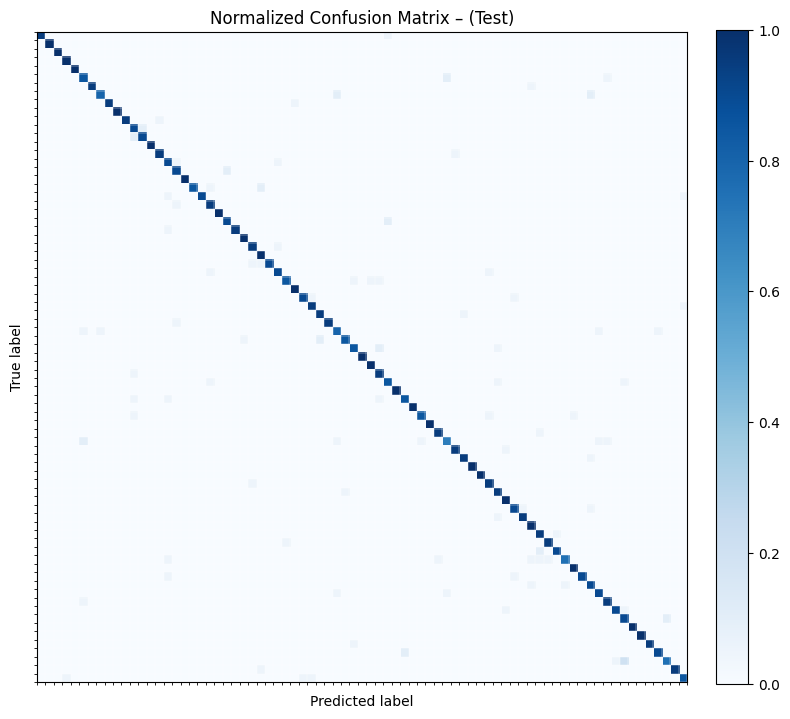

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



cm_norm = confusion_matrix(
    truths,
    preds,

    normalize="true",
)

fig, ax = plt.subplots(figsize=(8, 8))

disp = ConfusionMatrixDisplay(cm_norm)
disp.plot(
    include_values=False,
    cmap="Blues",
    ax=ax,
    colorbar=False,
)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-0.5, cm_norm.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, cm_norm.shape[0], 1), minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=0.3)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Normalized Confusion Matrix – (Test)")

im = ax.images[0]
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## BERT (CLS pooling)

preprocessing

In [ ]:
from transformers import  DataCollatorWithPadding
from datasets import  DatasetDict

model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)



def preprocessing(data):
  return tokenizer(data["text"], truncation=True,max_length=64)

ds = DatasetDict({"train": train_data, "validation": valid_data, "test": test_data})
enc = ds.map(preprocessing, batched=True, remove_columns=["text"])
collator = DataCollatorWithPadding(tokenizer)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/10003 [00:00<?, ? examples/s]

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

dataloaders

In [ ]:
import torch
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(enc["train"], batch_size=64, shuffle=True,  collate_fn=collator, pin_memory=True)
valid_loader = DataLoader(enc["validation"], batch_size=64, shuffle=False, collate_fn=collator, pin_memory=True)
test_loader  = DataLoader(enc["test"], batch_size=64, shuffle=False, collate_fn=collator, pin_memory=True)


building the model and training it for epoch 15. Then we will do hyperparameters tuning

In [ ]:
from transformers import get_linear_schedule_with_warmup


model_name =  "bert-base-uncased"
model = Model(model_name, num_labels, pooling="cls").to(device)
print(device)
loss_function=nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
epochs= 15
total_steps = epochs * len(train_loader)
warmup_steps= int(total_steps*0.06)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

cuda


training

In [ ]:
train(model,epochs,train_loader,valid_loader,optimizer,scheduler,loss_function,device)

100%|██████████| 25/25 [00:04<00:00,  5.65it/s]


Epoch: 1, Train loss: 3.898, Val loss: 2.411
Train rec: 0.162, Val rec: 0.626
Train f1: 0.190, Val f1: 0.591
Train prec: 0.383, Val prec: 0.714


100%|██████████| 25/25 [00:04<00:00,  5.90it/s]


Epoch: 2, Train loss: 1.500, Val loss: 0.729
Train rec: 0.752, Val rec: 0.854
Train f1: 0.751, Val f1: 0.848
Train prec: 0.786, Val prec: 0.873


100%|██████████| 25/25 [00:04<00:00,  5.98it/s]


Epoch: 3, Train loss: 0.601, Val loss: 0.438
Train rec: 0.893, Val rec: 0.899
Train f1: 0.895, Val f1: 0.899
Train prec: 0.902, Val prec: 0.908


100%|██████████| 25/25 [00:04<00:00,  5.99it/s]


Epoch: 4, Train loss: 0.341, Val loss: 0.361
Train rec: 0.939, Val rec: 0.909
Train f1: 0.940, Val f1: 0.909
Train prec: 0.942, Val prec: 0.917


100%|██████████| 25/25 [00:04<00:00,  6.05it/s]


Epoch: 5, Train loss: 0.215, Val loss: 0.303
Train rec: 0.962, Val rec: 0.920
Train f1: 0.962, Val f1: 0.920
Train prec: 0.963, Val prec: 0.925


100%|██████████| 25/25 [00:04<00:00,  6.05it/s]


Epoch: 6, Train loss: 0.147, Val loss: 0.301
Train rec: 0.975, Val rec: 0.923
Train f1: 0.975, Val f1: 0.923
Train prec: 0.976, Val prec: 0.929


100%|██████████| 25/25 [00:04<00:00,  6.01it/s]


Epoch: 7, Train loss: 0.103, Val loss: 0.317
Train rec: 0.983, Val rec: 0.926
Train f1: 0.983, Val f1: 0.926
Train prec: 0.984, Val prec: 0.932


100%|██████████| 25/25 [00:04<00:00,  5.98it/s]


Epoch: 8, Train loss: 0.071, Val loss: 0.327
Train rec: 0.989, Val rec: 0.923
Train f1: 0.989, Val f1: 0.923
Train prec: 0.989, Val prec: 0.931


100%|██████████| 25/25 [00:04<00:00,  6.03it/s]


Epoch: 9, Train loss: 0.050, Val loss: 0.319
Train rec: 0.993, Val rec: 0.920
Train f1: 0.993, Val f1: 0.920
Train prec: 0.993, Val prec: 0.926


100%|██████████| 25/25 [00:04<00:00,  5.98it/s]


Epoch: 10, Train loss: 0.038, Val loss: 0.328
Train rec: 0.997, Val rec: 0.922
Train f1: 0.997, Val f1: 0.922
Train prec: 0.997, Val prec: 0.929


100%|██████████| 25/25 [00:04<00:00,  5.95it/s]


Epoch: 11, Train loss: 0.026, Val loss: 0.332
Train rec: 0.998, Val rec: 0.929
Train f1: 0.998, Val f1: 0.928
Train prec: 0.998, Val prec: 0.933


100%|██████████| 25/25 [00:04<00:00,  5.97it/s]


Epoch: 12, Train loss: 0.022, Val loss: 0.328
Train rec: 0.999, Val rec: 0.928
Train f1: 0.999, Val f1: 0.928
Train prec: 0.998, Val prec: 0.932


100%|██████████| 25/25 [00:04<00:00,  5.93it/s]


Epoch: 13, Train loss: 0.018, Val loss: 0.344
Train rec: 0.999, Val rec: 0.926
Train f1: 0.999, Val f1: 0.926
Train prec: 0.999, Val prec: 0.931


100%|██████████| 25/25 [00:04<00:00,  5.98it/s]


Epoch: 14, Train loss: 0.016, Val loss: 0.334
Train rec: 0.999, Val rec: 0.926
Train f1: 0.999, Val f1: 0.926
Train prec: 0.999, Val prec: 0.931


100%|██████████| 25/25 [00:04<00:00,  5.92it/s]


Epoch: 15, Train loss: 0.014, Val loss: 0.336
Train rec: 1.000, Val rec: 0.925
Train f1: 1.000, Val f1: 0.925
Train prec: 1.000, Val prec: 0.930


(0.9253246753246755, 0.9250441633303204, 0.930264315285503)

Testing

In [ ]:
preds,truths=test(model,test_loader,device)

  recall: 0.943, f1-score: 0.943, precision: 0.945


finetuning hyperparameters

In [ ]:
search_space = {
    "lr": [1e-5, 2e-5, 3e-5],
    "weight_decay": [0.0, 0.01],
    "warmup_ratio": [0.0, 0.06, 0.1],
    "batch_size": [64,128, 256],
    "epochs": [4],  # because of limited resources
}

configs = []
for lr, wd, wr, bs, ep in itertools.product(
    search_space["lr"],
    search_space["weight_decay"],
    search_space["warmup_ratio"],
    search_space["batch_size"],
    search_space["epochs"],
):
    configs.append({
        "lr": lr,
        "weight_decay": wd,
        "warmup_ratio": wr,
        "batch_size": bs,
        "epochs": ep,
    })

print("Total configs:", len(configs))

all_results = []
best_result = None

for i, cfg in enumerate(configs, 1):
    print("=" * 80)
    print(f"Running config {i}/{len(configs)}: {cfg}")
    # data loaders
    train_loader = DataLoader(enc["train"], batch_size=cfg['batch_size'], shuffle=True,  collate_fn=collator, pin_memory=True)
    valid_loader = DataLoader(enc["validation"], batch_size=cfg['batch_size'], shuffle=False, collate_fn=collator, pin_memory=True)
    test_loader  = DataLoader(enc["test"], batch_size=cfg['batch_size'], shuffle=False, collate_fn=collator, pin_memory=True)

    # training
    result = run_experiment(cfg,model_name,"cls", train_loader, valid_loader, num_labels, device)
    all_results.append(result)

    if best_result is None or result["best_val_f1"] > best_result["best_val_f1"]:
        best_result = result
        print(f"--> New best F1: {best_result['best_val_f1']:.4f}")

print("\n===== SEARCH DONE =====")
print("Best config:", best_result["config"])
print(
    f"Best val acc: {best_result['best_val_acc']:.4f} | "
    f"Best val macro-F1: {best_result['best_val_f1']:.4f}"
)



Total configs: 54
Running config 1/54: {'lr': 1e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.0, 'batch_size': 64, 'epochs': 4}
[CONFIG] lr=1e-05 | wd=0.0 | warmup=0.0 | epochs=4


100%|██████████| 25/25 [00:03<00:00,  6.59it/s]


Epoch: 1, Train loss: 3.797, Val loss: 2.798
Train rec: 0.207, Val rec: 0.562
Train f1: 0.213, Val f1: 0.522
Train prec: 0.364, Val prec: 0.626


100%|██████████| 25/25 [00:03<00:00,  6.86it/s]


Epoch: 2, Train loss: 2.396, Val loss: 1.732
Train rec: 0.614, Val rec: 0.723
Train f1: 0.595, Val f1: 0.697
Train prec: 0.699, Val prec: 0.761


100%|██████████| 25/25 [00:03<00:00,  6.84it/s]


Epoch: 3, Train loss: 1.697, Val loss: 1.321
Train rec: 0.735, Val rec: 0.774
Train f1: 0.728, Val f1: 0.753
Train prec: 0.790, Val prec: 0.786


100%|██████████| 25/25 [00:03<00:00,  6.77it/s]


Epoch: 4, Train loss: 1.429, Val loss: 1.216
Train rec: 0.784, Val rec: 0.784
Train f1: 0.780, Val f1: 0.764
Train prec: 0.829, Val prec: 0.793
--> New best F1: 0.7935
Running config 2/54: {'lr': 1e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.0, 'batch_size': 128, 'epochs': 4}
[CONFIG] lr=1e-05 | wd=0.0 | warmup=0.0 | epochs=4


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch: 1, Train loss: 4.053, Val loss: 3.543
Train rec: 0.103, Val rec: 0.358
Train f1: 0.098, Val f1: 0.315
Train prec: 0.242, Val prec: 0.428


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch: 2, Train loss: 3.184, Val loss: 2.632
Train rec: 0.455, Val rec: 0.605
Train f1: 0.440, Val f1: 0.567
Train prec: 0.542, Val prec: 0.638


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch: 3, Train loss: 2.548, Val loss: 2.159
Train rec: 0.616, Val rec: 0.673
Train f1: 0.603, Val f1: 0.638
Train prec: 0.691, Val prec: 0.692


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch: 4, Train loss: 2.260, Val loss: 2.018
Train rec: 0.670, Val rec: 0.692
Train f1: 0.659, Val f1: 0.658
Train prec: 0.736, Val prec: 0.705
Running config 3/54: {'lr': 1e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.0, 'batch_size': 256, 'epochs': 4}
[CONFIG] lr=1e-05 | wd=0.0 | warmup=0.0 | epochs=4


100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 1, Train loss: 4.221, Val loss: 3.939
Train rec: 0.042, Val rec: 0.148
Train f1: 0.028, Val f1: 0.111
Train prec: 0.049, Val prec: 0.143


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 2, Train loss: 3.761, Val loss: 3.388
Train rec: 0.206, Val rec: 0.395
Train f1: 0.184, Val f1: 0.353
Train prec: 0.320, Val prec: 0.460


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 3, Train loss: 3.348, Val loss: 3.035
Train rec: 0.387, Val rec: 0.497
Train f1: 0.371, Val f1: 0.460
Train prec: 0.477, Val prec: 0.532


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 4, Train loss: 3.128, Val loss: 2.917
Train rec: 0.465, Val rec: 0.527
Train f1: 0.449, Val f1: 0.490
Train prec: 0.575, Val prec: 0.547
Running config 4/54: {'lr': 1e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'batch_size': 64, 'epochs': 4}
[CONFIG] lr=1e-05 | wd=0.0 | warmup=0.06 | epochs=4


100%|██████████| 25/25 [00:03<00:00,  6.86it/s]


Epoch: 1, Train loss: 3.912, Val loss: 2.961
Train rec: 0.175, Val rec: 0.536
Train f1: 0.183, Val f1: 0.490
Train prec: 0.314, Val prec: 0.572


100%|██████████| 25/25 [00:03<00:00,  6.86it/s]


Epoch: 2, Train loss: 2.499, Val loss: 1.790
Train rec: 0.599, Val rec: 0.706
Train f1: 0.583, Val f1: 0.684
Train prec: 0.667, Val prec: 0.732


100%|██████████| 25/25 [00:03<00:00,  6.82it/s]


Epoch: 3, Train loss: 1.736, Val loss: 1.356
Train rec: 0.728, Val rec: 0.768
Train f1: 0.720, Val f1: 0.744
Train prec: 0.765, Val prec: 0.770


100%|██████████| 25/25 [00:03<00:00,  6.86it/s]


Epoch: 4, Train loss: 1.448, Val loss: 1.239
Train rec: 0.773, Val rec: 0.782
Train f1: 0.767, Val f1: 0.762
Train prec: 0.790, Val prec: 0.781
Running config 5/54: {'lr': 1e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'batch_size': 128, 'epochs': 4}
[CONFIG] lr=1e-05 | wd=0.0 | warmup=0.06 | epochs=4


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch: 1, Train loss: 4.139, Val loss: 3.592
Train rec: 0.087, Val rec: 0.373
Train f1: 0.083, Val f1: 0.328
Train prec: 0.165, Val prec: 0.443


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch: 2, Train loss: 3.203, Val loss: 2.592
Train rec: 0.444, Val rec: 0.606
Train f1: 0.428, Val f1: 0.571
Train prec: 0.528, Val prec: 0.680


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch: 3, Train loss: 2.517, Val loss: 2.099
Train rec: 0.621, Val rec: 0.686
Train f1: 0.609, Val f1: 0.657
Train prec: 0.702, Val prec: 0.738


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch: 4, Train loss: 2.217, Val loss: 1.960
Train rec: 0.676, Val rec: 0.698
Train f1: 0.666, Val f1: 0.671
Train prec: 0.742, Val prec: 0.746
Running config 6/54: {'lr': 1e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'batch_size': 256, 'epochs': 4}
[CONFIG] lr=1e-05 | wd=0.0 | warmup=0.06 | epochs=4


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 1, Train loss: 4.272, Val loss: 4.054
Train rec: 0.034, Val rec: 0.123
Train f1: 0.024, Val f1: 0.086
Train prec: 0.067, Val prec: 0.148


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 2, Train loss: 3.800, Val loss: 3.450
Train rec: 0.217, Val rec: 0.410
Train f1: 0.200, Val f1: 0.365
Train prec: 0.292, Val prec: 0.449


100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 3, Train loss: 3.335, Val loss: 3.051
Train rec: 0.419, Val rec: 0.529
Train f1: 0.403, Val f1: 0.492
Train prec: 0.487, Val prec: 0.565


100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 4, Train loss: 3.101, Val loss: 2.922
Train rec: 0.500, Val rec: 0.566
Train f1: 0.483, Val f1: 0.526
Train prec: 0.552, Val prec: 0.586
Running config 7/54: {'lr': 1e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 64, 'epochs': 4}
[CONFIG] lr=1e-05 | wd=0.0 | warmup=0.1 | epochs=4


100%|██████████| 25/25 [00:03<00:00,  6.82it/s]


Epoch: 1, Train loss: 3.960, Val loss: 3.010
Train rec: 0.154, Val rec: 0.525
Train f1: 0.162, Val f1: 0.493
Train prec: 0.289, Val prec: 0.588


100%|██████████| 25/25 [00:03<00:00,  6.87it/s]


Epoch: 2, Train loss: 2.508, Val loss: 1.799
Train rec: 0.590, Val rec: 0.706
Train f1: 0.578, Val f1: 0.674
Train prec: 0.655, Val prec: 0.704


100%|██████████| 25/25 [00:03<00:00,  6.84it/s]


Epoch: 3, Train loss: 1.717, Val loss: 1.338
Train rec: 0.723, Val rec: 0.773
Train f1: 0.711, Val f1: 0.747
Train prec: 0.746, Val prec: 0.772


100%|██████████| 25/25 [00:03<00:00,  6.80it/s]


Epoch: 4, Train loss: 1.414, Val loss: 1.222
Train rec: 0.775, Val rec: 0.788
Train f1: 0.768, Val f1: 0.763
Train prec: 0.808, Val prec: 0.782
Running config 8/54: {'lr': 1e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 128, 'epochs': 4}
[CONFIG] lr=1e-05 | wd=0.0 | warmup=0.1 | epochs=4


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch: 1, Train loss: 4.177, Val loss: 3.701
Train rec: 0.062, Val rec: 0.297
Train f1: 0.058, Val f1: 0.255
Train prec: 0.166, Val prec: 0.349


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch: 2, Train loss: 3.257, Val loss: 2.638
Train rec: 0.413, Val rec: 0.575
Train f1: 0.394, Val f1: 0.540
Train prec: 0.509, Val prec: 0.618


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch: 3, Train loss: 2.513, Val loss: 2.128
Train rec: 0.599, Val rec: 0.642
Train f1: 0.585, Val f1: 0.612
Train prec: 0.667, Val prec: 0.663


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch: 4, Train loss: 2.192, Val loss: 1.976
Train rec: 0.654, Val rec: 0.662
Train f1: 0.641, Val f1: 0.630
Train prec: 0.734, Val prec: 0.696
Running config 9/54: {'lr': 1e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 256, 'epochs': 4}
[CONFIG] lr=1e-05 | wd=0.0 | warmup=0.1 | epochs=4


100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 1, Train loss: 4.250, Val loss: 3.976
Train rec: 0.032, Val rec: 0.132
Train f1: 0.021, Val f1: 0.090
Train prec: 0.073, Val prec: 0.151


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 2, Train loss: 3.764, Val loss: 3.363
Train rec: 0.208, Val rec: 0.412
Train f1: 0.184, Val f1: 0.369
Train prec: 0.292, Val prec: 0.479


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 3, Train loss: 3.296, Val loss: 2.952
Train rec: 0.426, Val rec: 0.540
Train f1: 0.404, Val f1: 0.503
Train prec: 0.511, Val prec: 0.607


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 4, Train loss: 3.047, Val loss: 2.816
Train rec: 0.501, Val rec: 0.570
Train f1: 0.481, Val f1: 0.535
Train prec: 0.582, Val prec: 0.611
Running config 10/54: {'lr': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.0, 'batch_size': 64, 'epochs': 4}
[CONFIG] lr=1e-05 | wd=0.01 | warmup=0.0 | epochs=4


100%|██████████| 25/25 [00:03<00:00,  6.82it/s]


Epoch: 1, Train loss: 3.875, Val loss: 2.964
Train rec: 0.186, Val rec: 0.512
Train f1: 0.180, Val f1: 0.470
Train prec: 0.335, Val prec: 0.571


100%|██████████| 25/25 [00:03<00:00,  6.75it/s]


Epoch: 2, Train loss: 2.528, Val loss: 1.851
Train rec: 0.583, Val rec: 0.706
Train f1: 0.567, Val f1: 0.675
Train prec: 0.644, Val prec: 0.722


100%|██████████| 25/25 [00:03<00:00,  6.78it/s]


Epoch: 3, Train loss: 1.788, Val loss: 1.420
Train rec: 0.719, Val rec: 0.768
Train f1: 0.709, Val f1: 0.741
Train prec: 0.760, Val prec: 0.762


100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Epoch: 4, Train loss: 1.504, Val loss: 1.303
Train rec: 0.763, Val rec: 0.771
Train f1: 0.755, Val f1: 0.746
Train prec: 0.793, Val prec: 0.763
Running config 11/54: {'lr': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.0, 'batch_size': 128, 'epochs': 4}
[CONFIG] lr=1e-05 | wd=0.01 | warmup=0.0 | epochs=4


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch: 1, Train loss: 4.076, Val loss: 3.545
Train rec: 0.105, Val rec: 0.387
Train f1: 0.095, Val f1: 0.353
Train prec: 0.214, Val prec: 0.437


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch: 2, Train loss: 3.220, Val loss: 2.628
Train rec: 0.449, Val rec: 0.608
Train f1: 0.432, Val f1: 0.565
Train prec: 0.528, Val prec: 0.629


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch: 3, Train loss: 2.571, Val loss: 2.158
Train rec: 0.607, Val rec: 0.666
Train f1: 0.585, Val f1: 0.627
Train prec: 0.667, Val prec: 0.684


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch: 4, Train loss: 2.269, Val loss: 2.020
Train rec: 0.660, Val rec: 0.684
Train f1: 0.642, Val f1: 0.647
Train prec: 0.687, Val prec: 0.695
Running config 12/54: {'lr': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.0, 'batch_size': 256, 'epochs': 4}
[CONFIG] lr=1e-05 | wd=0.01 | warmup=0.0 | epochs=4


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 1, Train loss: 4.218, Val loss: 3.934
Train rec: 0.043, Val rec: 0.169
Train f1: 0.035, Val f1: 0.130
Train prec: 0.081, Val prec: 0.238


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 2, Train loss: 3.744, Val loss: 3.361
Train rec: 0.250, Val rec: 0.453
Train f1: 0.234, Val f1: 0.413
Train prec: 0.351, Val prec: 0.517


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 3, Train loss: 3.319, Val loss: 2.988
Train rec: 0.454, Val rec: 0.560
Train f1: 0.439, Val f1: 0.525
Train prec: 0.526, Val prec: 0.590


100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 4, Train loss: 3.091, Val loss: 2.864
Train rec: 0.531, Val rec: 0.587
Train f1: 0.516, Val f1: 0.551
Train prec: 0.581, Val prec: 0.604
Running config 13/54: {'lr': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'batch_size': 64, 'epochs': 4}
[CONFIG] lr=1e-05 | wd=0.01 | warmup=0.06 | epochs=4


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Epoch: 1, Train loss: 3.929, Val loss: 2.945
Train rec: 0.165, Val rec: 0.521
Train f1: 0.174, Val f1: 0.485
Train prec: 0.315, Val prec: 0.564


100%|██████████| 25/25 [00:03<00:00,  6.84it/s]


Epoch: 2, Train loss: 2.475, Val loss: 1.771
Train rec: 0.598, Val rec: 0.712
Train f1: 0.583, Val f1: 0.681
Train prec: 0.658, Val prec: 0.724


100%|██████████| 25/25 [00:03<00:00,  6.85it/s]


Epoch: 3, Train loss: 1.714, Val loss: 1.336
Train rec: 0.730, Val rec: 0.775
Train f1: 0.721, Val f1: 0.756
Train prec: 0.773, Val prec: 0.789


100%|██████████| 25/25 [00:03<00:00,  6.89it/s]


Epoch: 4, Train loss: 1.427, Val loss: 1.221
Train rec: 0.780, Val rec: 0.790
Train f1: 0.774, Val f1: 0.772
Train prec: 0.810, Val prec: 0.797
--> New best F1: 0.7965
Running config 14/54: {'lr': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'batch_size': 128, 'epochs': 4}
[CONFIG] lr=1e-05 | wd=0.01 | warmup=0.06 | epochs=4


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch: 1, Train loss: 4.093, Val loss: 3.500
Train rec: 0.098, Val rec: 0.422
Train f1: 0.103, Val f1: 0.386
Train prec: 0.208, Val prec: 0.447


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch: 2, Train loss: 3.119, Val loss: 2.489
Train rec: 0.487, Val rec: 0.637
Train f1: 0.473, Val f1: 0.599
Train prec: 0.550, Val prec: 0.637


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch: 3, Train loss: 2.422, Val loss: 2.011
Train rec: 0.638, Val rec: 0.698
Train f1: 0.623, Val f1: 0.663
Train prec: 0.693, Val prec: 0.702


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch: 4, Train loss: 2.121, Val loss: 1.878
Train rec: 0.687, Val rec: 0.708
Train f1: 0.674, Val f1: 0.676
Train prec: 0.738, Val prec: 0.723
Running config 15/54: {'lr': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'batch_size': 256, 'epochs': 4}
[CONFIG] lr=1e-05 | wd=0.01 | warmup=0.06 | epochs=4


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 1, Train loss: 4.242, Val loss: 3.998
Train rec: 0.033, Val rec: 0.135
Train f1: 0.023, Val f1: 0.113
Train prec: 0.076, Val prec: 0.187


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 2, Train loss: 3.764, Val loss: 3.379
Train rec: 0.224, Val rec: 0.445
Train f1: 0.205, Val f1: 0.405
Train prec: 0.336, Val prec: 0.496


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 3, Train loss: 3.302, Val loss: 2.992
Train rec: 0.436, Val rec: 0.559
Train f1: 0.417, Val f1: 0.518
Train prec: 0.499, Val prec: 0.572


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 4, Train loss: 3.062, Val loss: 2.865
Train rec: 0.522, Val rec: 0.588
Train f1: 0.503, Val f1: 0.548
Train prec: 0.588, Val prec: 0.604
Running config 16/54: {'lr': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'batch_size': 64, 'epochs': 4}
[CONFIG] lr=1e-05 | wd=0.01 | warmup=0.1 | epochs=4


100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Epoch: 1, Train loss: 3.988, Val loss: 3.039
Train rec: 0.146, Val rec: 0.542
Train f1: 0.154, Val f1: 0.499
Train prec: 0.295, Val prec: 0.584


100%|██████████| 25/25 [00:03<00:00,  6.90it/s]


Epoch: 2, Train loss: 2.492, Val loss: 1.736
Train rec: 0.609, Val rec: 0.713
Train f1: 0.595, Val f1: 0.688
Train prec: 0.662, Val prec: 0.737


100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Epoch: 3, Train loss: 1.666, Val loss: 1.292
Train rec: 0.742, Val rec: 0.775
Train f1: 0.736, Val f1: 0.755
Train prec: 0.766, Val prec: 0.788


100%|██████████| 25/25 [00:03<00:00,  6.79it/s]


Epoch: 4, Train loss: 1.371, Val loss: 1.177
Train rec: 0.783, Val rec: 0.788
Train f1: 0.778, Val f1: 0.770
Train prec: 0.811, Val prec: 0.795
Running config 17/54: {'lr': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'batch_size': 128, 'epochs': 4}
[CONFIG] lr=1e-05 | wd=0.01 | warmup=0.1 | epochs=4


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch: 1, Train loss: 4.173, Val loss: 3.676
Train rec: 0.068, Val rec: 0.301
Train f1: 0.063, Val f1: 0.271
Train prec: 0.133, Val prec: 0.372


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch: 2, Train loss: 3.273, Val loss: 2.618
Train rec: 0.430, Val rec: 0.603
Train f1: 0.413, Val f1: 0.558
Train prec: 0.497, Val prec: 0.633


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch: 3, Train loss: 2.540, Val loss: 2.104
Train rec: 0.611, Val rec: 0.673
Train f1: 0.590, Val f1: 0.637
Train prec: 0.660, Val prec: 0.684


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch: 4, Train loss: 2.221, Val loss: 1.961
Train rec: 0.662, Val rec: 0.691
Train f1: 0.646, Val f1: 0.655
Train prec: 0.711, Val prec: 0.697
Running config 18/54: {'lr': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'batch_size': 256, 'epochs': 4}
[CONFIG] lr=1e-05 | wd=0.01 | warmup=0.1 | epochs=4


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 1, Train loss: 4.289, Val loss: 4.071
Train rec: 0.031, Val rec: 0.128
Train f1: 0.024, Val f1: 0.080
Train prec: 0.042, Val prec: 0.140


100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 2, Train loss: 3.800, Val loss: 3.472
Train rec: 0.207, Val rec: 0.382
Train f1: 0.182, Val f1: 0.330
Train prec: 0.290, Val prec: 0.428


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 3, Train loss: 3.342, Val loss: 3.075
Train rec: 0.387, Val rec: 0.491
Train f1: 0.365, Val f1: 0.448
Train prec: 0.498, Val prec: 0.556


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 4, Train loss: 3.097, Val loss: 2.943
Train rec: 0.471, Val rec: 0.515
Train f1: 0.449, Val f1: 0.471
Train prec: 0.565, Val prec: 0.577
Running config 19/54: {'lr': 2e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.0, 'batch_size': 64, 'epochs': 4}
[CONFIG] lr=2e-05 | wd=0.0 | warmup=0.0 | epochs=4


100%|██████████| 25/25 [00:03<00:00,  6.87it/s]


Epoch: 1, Train loss: 3.110, Val loss: 1.623
Train rec: 0.395, Val rec: 0.731
Train f1: 0.406, Val f1: 0.702
Train prec: 0.540, Val prec: 0.758


100%|██████████| 25/25 [00:03<00:00,  6.77it/s]


Epoch: 2, Train loss: 1.246, Val loss: 0.779
Train rec: 0.790, Val rec: 0.853
Train f1: 0.790, Val f1: 0.845
Train prec: 0.824, Val prec: 0.862


100%|██████████| 25/25 [00:03<00:00,  6.82it/s]


Epoch: 3, Train loss: 0.711, Val loss: 0.572
Train rec: 0.886, Val rec: 0.890
Train f1: 0.889, Val f1: 0.888
Train prec: 0.902, Val prec: 0.901


100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Epoch: 4, Train loss: 0.541, Val loss: 0.520
Train rec: 0.916, Val rec: 0.898
Train f1: 0.919, Val f1: 0.897
Train prec: 0.925, Val prec: 0.907
--> New best F1: 0.9072
Running config 20/54: {'lr': 2e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.0, 'batch_size': 128, 'epochs': 4}
[CONFIG] lr=2e-05 | wd=0.0 | warmup=0.0 | epochs=4


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch: 1, Train loss: 3.651, Val loss: 2.533
Train rec: 0.251, Val rec: 0.609
Train f1: 0.255, Val f1: 0.573
Train prec: 0.371, Val prec: 0.671


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch: 2, Train loss: 2.088, Val loss: 1.444
Train rec: 0.658, Val rec: 0.751
Train f1: 0.649, Val f1: 0.728
Train prec: 0.716, Val prec: 0.761


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch: 3, Train loss: 1.364, Val loss: 1.058
Train rec: 0.780, Val rec: 0.812
Train f1: 0.776, Val f1: 0.799
Train prec: 0.816, Val prec: 0.831


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch: 4, Train loss: 1.097, Val loss: 0.955
Train rec: 0.818, Val rec: 0.820
Train f1: 0.818, Val f1: 0.809
Train prec: 0.844, Val prec: 0.835
Running config 21/54: {'lr': 2e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.0, 'batch_size': 256, 'epochs': 4}
[CONFIG] lr=2e-05 | wd=0.0 | warmup=0.0 | epochs=4


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 1, Train loss: 3.973, Val loss: 3.240
Train rec: 0.138, Val rec: 0.458
Train f1: 0.135, Val f1: 0.407
Train prec: 0.264, Val prec: 0.481


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 2, Train loss: 2.891, Val loss: 2.185
Train rec: 0.533, Val rec: 0.659
Train f1: 0.512, Val f1: 0.621
Train prec: 0.636, Val prec: 0.693


100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 3, Train loss: 2.156, Val loss: 1.709
Train rec: 0.680, Val rec: 0.729
Train f1: 0.666, Val f1: 0.701
Train prec: 0.746, Val prec: 0.756


100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 4, Train loss: 1.842, Val loss: 1.574
Train rec: 0.734, Val rec: 0.754
Train f1: 0.726, Val f1: 0.730
Train prec: 0.781, Val prec: 0.780
Running config 22/54: {'lr': 2e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'batch_size': 64, 'epochs': 4}
[CONFIG] lr=2e-05 | wd=0.0 | warmup=0.06 | epochs=4


100%|██████████| 25/25 [00:03<00:00,  6.72it/s]


Epoch: 1, Train loss: 3.398, Val loss: 1.799
Train rec: 0.319, Val rec: 0.688
Train f1: 0.328, Val f1: 0.653
Train prec: 0.449, Val prec: 0.693


100%|██████████| 25/25 [00:03<00:00,  6.78it/s]


Epoch: 2, Train loss: 1.312, Val loss: 0.801
Train rec: 0.773, Val rec: 0.836
Train f1: 0.769, Val f1: 0.827
Train prec: 0.808, Val prec: 0.845


100%|██████████| 25/25 [00:03<00:00,  6.85it/s]


Epoch: 3, Train loss: 0.719, Val loss: 0.576
Train rec: 0.880, Val rec: 0.884
Train f1: 0.883, Val f1: 0.882
Train prec: 0.897, Val prec: 0.896


100%|██████████| 25/25 [00:03<00:00,  6.82it/s]


Epoch: 4, Train loss: 0.546, Val loss: 0.521
Train rec: 0.912, Val rec: 0.889
Train f1: 0.915, Val f1: 0.888
Train prec: 0.921, Val prec: 0.901
Running config 23/54: {'lr': 2e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'batch_size': 128, 'epochs': 4}
[CONFIG] lr=2e-05 | wd=0.0 | warmup=0.06 | epochs=4


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch: 1, Train loss: 3.794, Val loss: 2.609
Train rec: 0.212, Val rec: 0.600
Train f1: 0.233, Val f1: 0.559
Train prec: 0.353, Val prec: 0.626


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch: 2, Train loss: 2.100, Val loss: 1.371
Train rec: 0.672, Val rec: 0.763
Train f1: 0.656, Val f1: 0.738
Train prec: 0.713, Val prec: 0.772


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch: 3, Train loss: 1.316, Val loss: 0.986
Train rec: 0.789, Val rec: 0.816
Train f1: 0.785, Val f1: 0.805
Train prec: 0.823, Val prec: 0.835


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch: 4, Train loss: 1.042, Val loss: 0.890
Train rec: 0.833, Val rec: 0.834
Train f1: 0.834, Val f1: 0.826
Train prec: 0.855, Val prec: 0.844
Running config 24/54: {'lr': 2e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'batch_size': 256, 'epochs': 4}
[CONFIG] lr=2e-05 | wd=0.0 | warmup=0.06 | epochs=4


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 1, Train loss: 4.095, Val loss: 3.464
Train rec: 0.099, Val rec: 0.384
Train f1: 0.094, Val f1: 0.338
Train prec: 0.180, Val prec: 0.451


100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 2, Train loss: 3.055, Val loss: 2.360
Train rec: 0.497, Val rec: 0.656
Train f1: 0.486, Val f1: 0.625
Train prec: 0.579, Val prec: 0.671


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 3, Train loss: 2.258, Val loss: 1.827
Train rec: 0.669, Val rec: 0.723
Train f1: 0.656, Val f1: 0.694
Train prec: 0.694, Val prec: 0.714


100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 4, Train loss: 1.926, Val loss: 1.682
Train rec: 0.713, Val rec: 0.738
Train f1: 0.700, Val f1: 0.709
Train prec: 0.738, Val prec: 0.724
Running config 25/54: {'lr': 2e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 64, 'epochs': 4}
[CONFIG] lr=2e-05 | wd=0.0 | warmup=0.1 | epochs=4


100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Epoch: 1, Train loss: 3.470, Val loss: 1.805
Train rec: 0.291, Val rec: 0.708
Train f1: 0.307, Val f1: 0.678
Train prec: 0.438, Val prec: 0.722


100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Epoch: 2, Train loss: 1.326, Val loss: 0.793
Train rec: 0.782, Val rec: 0.845
Train f1: 0.780, Val f1: 0.838
Train prec: 0.815, Val prec: 0.853


100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Epoch: 3, Train loss: 0.705, Val loss: 0.558
Train rec: 0.884, Val rec: 0.895
Train f1: 0.887, Val f1: 0.894
Train prec: 0.898, Val prec: 0.905


100%|██████████| 25/25 [00:03<00:00,  6.78it/s]


Epoch: 4, Train loss: 0.527, Val loss: 0.511
Train rec: 0.921, Val rec: 0.898
Train f1: 0.923, Val f1: 0.897
Train prec: 0.928, Val prec: 0.906
Running config 26/54: {'lr': 2e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 128, 'epochs': 4}
[CONFIG] lr=2e-05 | wd=0.0 | warmup=0.1 | epochs=4


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch: 1, Train loss: 3.914, Val loss: 2.837
Train rec: 0.166, Val rec: 0.548
Train f1: 0.169, Val f1: 0.503
Train prec: 0.348, Val prec: 0.563


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch: 2, Train loss: 2.219, Val loss: 1.460
Train rec: 0.652, Val rec: 0.753
Train f1: 0.643, Val f1: 0.728
Train prec: 0.731, Val prec: 0.785


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch: 3, Train loss: 1.363, Val loss: 1.027
Train rec: 0.790, Val rec: 0.823
Train f1: 0.787, Val f1: 0.809
Train prec: 0.828, Val prec: 0.835


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch: 4, Train loss: 1.065, Val loss: 0.916
Train rec: 0.836, Val rec: 0.838
Train f1: 0.835, Val f1: 0.827
Train prec: 0.871, Val prec: 0.847
Running config 27/54: {'lr': 2e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 256, 'epochs': 4}
[CONFIG] lr=2e-05 | wd=0.0 | warmup=0.1 | epochs=4


100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 1, Train loss: 4.129, Val loss: 3.521
Train rec: 0.079, Val rec: 0.347
Train f1: 0.078, Val f1: 0.309
Train prec: 0.173, Val prec: 0.398


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 2, Train loss: 3.071, Val loss: 2.361
Train rec: 0.482, Val rec: 0.661
Train f1: 0.472, Val f1: 0.631
Train prec: 0.585, Val prec: 0.694


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 3, Train loss: 2.239, Val loss: 1.798
Train rec: 0.679, Val rec: 0.736
Train f1: 0.669, Val f1: 0.708
Train prec: 0.732, Val prec: 0.739


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 4, Train loss: 1.879, Val loss: 1.641
Train rec: 0.738, Val rec: 0.751
Train f1: 0.731, Val f1: 0.726
Train prec: 0.774, Val prec: 0.759
Running config 28/54: {'lr': 2e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.0, 'batch_size': 64, 'epochs': 4}
[CONFIG] lr=2e-05 | wd=0.01 | warmup=0.0 | epochs=4


100%|██████████| 25/25 [00:03<00:00,  6.89it/s]


Epoch: 1, Train loss: 3.180, Val loss: 1.639
Train rec: 0.389, Val rec: 0.729
Train f1: 0.393, Val f1: 0.705
Train prec: 0.500, Val prec: 0.769


100%|██████████| 25/25 [00:03<00:00,  6.88it/s]


Epoch: 2, Train loss: 1.285, Val loss: 0.800
Train rec: 0.790, Val rec: 0.850
Train f1: 0.791, Val f1: 0.843
Train prec: 0.819, Val prec: 0.855


100%|██████████| 25/25 [00:03<00:00,  6.73it/s]


Epoch: 3, Train loss: 0.736, Val loss: 0.574
Train rec: 0.878, Val rec: 0.877
Train f1: 0.879, Val f1: 0.871
Train prec: 0.894, Val prec: 0.878


100%|██████████| 25/25 [00:03<00:00,  6.81it/s]


Epoch: 4, Train loss: 0.565, Val loss: 0.520
Train rec: 0.911, Val rec: 0.885
Train f1: 0.913, Val f1: 0.881
Train prec: 0.922, Val prec: 0.898
Running config 29/54: {'lr': 2e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.0, 'batch_size': 128, 'epochs': 4}
[CONFIG] lr=2e-05 | wd=0.01 | warmup=0.0 | epochs=4


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch: 1, Train loss: 3.591, Val loss: 2.428
Train rec: 0.277, Val rec: 0.633
Train f1: 0.272, Val f1: 0.594
Train prec: 0.361, Val prec: 0.662


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch: 2, Train loss: 2.006, Val loss: 1.362
Train rec: 0.682, Val rec: 0.773
Train f1: 0.670, Val f1: 0.754
Train prec: 0.731, Val prec: 0.775


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch: 3, Train loss: 1.300, Val loss: 1.005
Train rec: 0.794, Val rec: 0.819
Train f1: 0.792, Val f1: 0.806
Train prec: 0.817, Val prec: 0.829


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch: 4, Train loss: 1.050, Val loss: 0.911
Train rec: 0.836, Val rec: 0.836
Train f1: 0.836, Val f1: 0.825
Train prec: 0.874, Val prec: 0.844
Running config 30/54: {'lr': 2e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.0, 'batch_size': 256, 'epochs': 4}
[CONFIG] lr=2e-05 | wd=0.01 | warmup=0.0 | epochs=4


100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 1, Train loss: 4.025, Val loss: 3.437
Train rec: 0.131, Val rec: 0.452
Train f1: 0.132, Val f1: 0.415
Train prec: 0.259, Val prec: 0.475


100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 2, Train loss: 2.997, Val loss: 2.391
Train rec: 0.528, Val rec: 0.631
Train f1: 0.502, Val f1: 0.585
Train prec: 0.550, Val prec: 0.652


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 3, Train loss: 2.263, Val loss: 1.898
Train rec: 0.661, Val rec: 0.701
Train f1: 0.639, Val f1: 0.667
Train prec: 0.709, Val prec: 0.703


100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 4, Train loss: 1.944, Val loss: 1.759
Train rec: 0.716, Val rec: 0.721
Train f1: 0.701, Val f1: 0.690
Train prec: 0.760, Val prec: 0.724
Running config 31/54: {'lr': 2e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'batch_size': 64, 'epochs': 4}
[CONFIG] lr=2e-05 | wd=0.01 | warmup=0.06 | epochs=4


100%|██████████| 25/25 [00:03<00:00,  6.75it/s]


Epoch: 1, Train loss: 3.387, Val loss: 1.774
Train rec: 0.312, Val rec: 0.706
Train f1: 0.326, Val f1: 0.672
Train prec: 0.442, Val prec: 0.707


100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Epoch: 2, Train loss: 1.321, Val loss: 0.794
Train rec: 0.784, Val rec: 0.839
Train f1: 0.781, Val f1: 0.831
Train prec: 0.814, Val prec: 0.847


100%|██████████| 25/25 [00:03<00:00,  6.84it/s]


Epoch: 3, Train loss: 0.719, Val loss: 0.569
Train rec: 0.885, Val rec: 0.879
Train f1: 0.888, Val f1: 0.878
Train prec: 0.899, Val prec: 0.893


100%|██████████| 25/25 [00:03<00:00,  6.84it/s]


Epoch: 4, Train loss: 0.545, Val loss: 0.515
Train rec: 0.914, Val rec: 0.891
Train f1: 0.916, Val f1: 0.891
Train prec: 0.923, Val prec: 0.902
Running config 32/54: {'lr': 2e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'batch_size': 128, 'epochs': 4}
[CONFIG] lr=2e-05 | wd=0.01 | warmup=0.06 | epochs=4


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch: 1, Train loss: 3.795, Val loss: 2.639
Train rec: 0.200, Val rec: 0.572
Train f1: 0.207, Val f1: 0.527
Train prec: 0.323, Val prec: 0.647


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch: 2, Train loss: 2.089, Val loss: 1.389
Train rec: 0.655, Val rec: 0.753
Train f1: 0.641, Val f1: 0.722
Train prec: 0.717, Val prec: 0.759


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch: 3, Train loss: 1.306, Val loss: 1.004
Train rec: 0.787, Val rec: 0.825
Train f1: 0.782, Val f1: 0.815
Train prec: 0.822, Val prec: 0.837


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch: 4, Train loss: 1.042, Val loss: 0.906
Train rec: 0.833, Val rec: 0.842
Train f1: 0.832, Val f1: 0.834
Train prec: 0.852, Val prec: 0.850
Running config 33/54: {'lr': 2e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'batch_size': 256, 'epochs': 4}
[CONFIG] lr=2e-05 | wd=0.01 | warmup=0.06 | epochs=4


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 1, Train loss: 4.069, Val loss: 3.419
Train rec: 0.112, Val rec: 0.427
Train f1: 0.116, Val f1: 0.384
Train prec: 0.210, Val prec: 0.485


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 2, Train loss: 3.000, Val loss: 2.304
Train rec: 0.531, Val rec: 0.673
Train f1: 0.507, Val f1: 0.636
Train prec: 0.584, Val prec: 0.703


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 3, Train loss: 2.214, Val loss: 1.771
Train rec: 0.679, Val rec: 0.734
Train f1: 0.662, Val f1: 0.709
Train prec: 0.728, Val prec: 0.738


100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 4, Train loss: 1.868, Val loss: 1.621
Train rec: 0.737, Val rec: 0.745
Train f1: 0.724, Val f1: 0.720
Train prec: 0.763, Val prec: 0.740
Running config 34/54: {'lr': 2e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'batch_size': 64, 'epochs': 4}
[CONFIG] lr=2e-05 | wd=0.01 | warmup=0.1 | epochs=4


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Epoch: 1, Train loss: 3.519, Val loss: 1.877
Train rec: 0.274, Val rec: 0.704
Train f1: 0.295, Val f1: 0.670
Train prec: 0.436, Val prec: 0.716


100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Epoch: 2, Train loss: 1.353, Val loss: 0.794
Train rec: 0.764, Val rec: 0.840
Train f1: 0.759, Val f1: 0.831
Train prec: 0.793, Val prec: 0.849


100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Epoch: 3, Train loss: 0.709, Val loss: 0.579
Train rec: 0.878, Val rec: 0.881
Train f1: 0.881, Val f1: 0.878
Train prec: 0.899, Val prec: 0.894


100%|██████████| 25/25 [00:03<00:00,  6.77it/s]


Epoch: 4, Train loss: 0.529, Val loss: 0.518
Train rec: 0.911, Val rec: 0.890
Train f1: 0.914, Val f1: 0.888
Train prec: 0.923, Val prec: 0.902
Running config 35/54: {'lr': 2e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'batch_size': 128, 'epochs': 4}
[CONFIG] lr=2e-05 | wd=0.01 | warmup=0.1 | epochs=4


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch: 1, Train loss: 3.890, Val loss: 2.794
Train rec: 0.167, Val rec: 0.550
Train f1: 0.167, Val f1: 0.517
Train prec: 0.310, Val prec: 0.596


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch: 2, Train loss: 2.189, Val loss: 1.443
Train rec: 0.645, Val rec: 0.756
Train f1: 0.634, Val f1: 0.731
Train prec: 0.713, Val prec: 0.761


100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch: 3, Train loss: 1.338, Val loss: 1.015
Train rec: 0.785, Val rec: 0.823
Train f1: 0.780, Val f1: 0.809
Train prec: 0.823, Val prec: 0.832


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch: 4, Train loss: 1.053, Val loss: 0.910
Train rec: 0.831, Val rec: 0.829
Train f1: 0.828, Val f1: 0.815
Train prec: 0.855, Val prec: 0.836
Running config 36/54: {'lr': 2e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'batch_size': 256, 'epochs': 4}
[CONFIG] lr=2e-05 | wd=0.01 | warmup=0.1 | epochs=4


100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 1, Train loss: 4.159, Val loss: 3.578
Train rec: 0.065, Val rec: 0.368
Train f1: 0.062, Val f1: 0.327
Train prec: 0.141, Val prec: 0.441


100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 2, Train loss: 3.146, Val loss: 2.415
Train rec: 0.486, Val rec: 0.667
Train f1: 0.475, Val f1: 0.636
Train prec: 0.560, Val prec: 0.695


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 3, Train loss: 2.297, Val loss: 1.833
Train rec: 0.673, Val rec: 0.745
Train f1: 0.656, Val f1: 0.716
Train prec: 0.706, Val prec: 0.741


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 4, Train loss: 1.925, Val loss: 1.667
Train rec: 0.730, Val rec: 0.755
Train f1: 0.717, Val f1: 0.729
Train prec: 0.783, Val prec: 0.769
Running config 37/54: {'lr': 3e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.0, 'batch_size': 64, 'epochs': 4}
[CONFIG] lr=3e-05 | wd=0.0 | warmup=0.0 | epochs=4


100%|██████████| 25/25 [00:03<00:00,  6.82it/s]


Epoch: 1, Train loss: 2.610, Val loss: 1.059
Train rec: 0.484, Val rec: 0.795
Train f1: 0.493, Val f1: 0.777
Train prec: 0.593, Val prec: 0.808


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Epoch: 2, Train loss: 0.777, Val loss: 0.500
Train rec: 0.860, Val rec: 0.892
Train f1: 0.865, Val f1: 0.891
Train prec: 0.880, Val prec: 0.902


100%|██████████| 25/25 [00:03<00:00,  6.82it/s]


Epoch: 3, Train loss: 0.410, Val loss: 0.391
Train rec: 0.926, Val rec: 0.912
Train f1: 0.928, Val f1: 0.912
Train prec: 0.932, Val prec: 0.920


100%|██████████| 25/25 [00:03<00:00,  6.80it/s]


Epoch: 4, Train loss: 0.292, Val loss: 0.362
Train rec: 0.951, Val rec: 0.916
Train f1: 0.952, Val f1: 0.916
Train prec: 0.954, Val prec: 0.924
--> New best F1: 0.9239
Running config 38/54: {'lr': 3e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.0, 'batch_size': 128, 'epochs': 4}
[CONFIG] lr=3e-05 | wd=0.0 | warmup=0.0 | epochs=4


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch: 1, Train loss: 3.322, Val loss: 1.814
Train rec: 0.330, Val rec: 0.705
Train f1: 0.334, Val f1: 0.668
Train prec: 0.454, Val prec: 0.696


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch: 2, Train loss: 1.402, Val loss: 0.839
Train rec: 0.768, Val rec: 0.838
Train f1: 0.766, Val f1: 0.831
Train prec: 0.806, Val prec: 0.854


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch: 3, Train loss: 0.785, Val loss: 0.599
Train rec: 0.873, Val rec: 0.876
Train f1: 0.877, Val f1: 0.874
Train prec: 0.891, Val prec: 0.886


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch: 4, Train loss: 0.596, Val loss: 0.538
Train rec: 0.907, Val rec: 0.884
Train f1: 0.911, Val f1: 0.883
Train prec: 0.917, Val prec: 0.894
Running config 39/54: {'lr': 3e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.0, 'batch_size': 256, 'epochs': 4}
[CONFIG] lr=3e-05 | wd=0.0 | warmup=0.0 | epochs=4


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 1, Train loss: 3.791, Val loss: 2.817
Train rec: 0.225, Val rec: 0.592
Train f1: 0.224, Val f1: 0.567
Train prec: 0.347, Val prec: 0.648


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 2, Train loss: 2.353, Val loss: 1.611
Train rec: 0.655, Val rec: 0.744
Train f1: 0.645, Val f1: 0.718
Train prec: 0.699, Val prec: 0.755


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 3, Train loss: 1.536, Val loss: 1.152
Train rec: 0.771, Val rec: 0.795
Train f1: 0.764, Val f1: 0.778
Train prec: 0.816, Val prec: 0.802


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 4, Train loss: 1.225, Val loss: 1.031
Train rec: 0.818, Val rec: 0.815
Train f1: 0.816, Val f1: 0.801
Train prec: 0.849, Val prec: 0.814
Running config 40/54: {'lr': 3e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'batch_size': 64, 'epochs': 4}
[CONFIG] lr=3e-05 | wd=0.0 | warmup=0.06 | epochs=4


100%|██████████| 25/25 [00:03<00:00,  6.85it/s]


Epoch: 1, Train loss: 2.963, Val loss: 1.213
Train rec: 0.406, Val rec: 0.751
Train f1: 0.417, Val f1: 0.720
Train prec: 0.524, Val prec: 0.738


100%|██████████| 25/25 [00:03<00:00,  6.80it/s]


Epoch: 2, Train loss: 0.848, Val loss: 0.504
Train rec: 0.843, Val rec: 0.890
Train f1: 0.847, Val f1: 0.890
Train prec: 0.868, Val prec: 0.901


100%|██████████| 25/25 [00:03<00:00,  6.75it/s]


Epoch: 3, Train loss: 0.425, Val loss: 0.381
Train rec: 0.925, Val rec: 0.909
Train f1: 0.927, Val f1: 0.910
Train prec: 0.930, Val prec: 0.917


100%|██████████| 25/25 [00:03<00:00,  6.81it/s]


Epoch: 4, Train loss: 0.298, Val loss: 0.349
Train rec: 0.949, Val rec: 0.917
Train f1: 0.951, Val f1: 0.917
Train prec: 0.954, Val prec: 0.925
--> New best F1: 0.9250
Running config 41/54: {'lr': 3e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'batch_size': 128, 'epochs': 4}
[CONFIG] lr=3e-05 | wd=0.0 | warmup=0.06 | epochs=4


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch: 1, Train loss: 3.490, Val loss: 1.992
Train rec: 0.298, Val rec: 0.694
Train f1: 0.308, Val f1: 0.659
Train prec: 0.426, Val prec: 0.692


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch: 2, Train loss: 1.440, Val loss: 0.865
Train rec: 0.762, Val rec: 0.827
Train f1: 0.757, Val f1: 0.813
Train prec: 0.789, Val prec: 0.827


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch: 3, Train loss: 0.774, Val loss: 0.614
Train rec: 0.865, Val rec: 0.876
Train f1: 0.868, Val f1: 0.873
Train prec: 0.891, Val prec: 0.892


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch: 4, Train loss: 0.574, Val loss: 0.550
Train rec: 0.910, Val rec: 0.885
Train f1: 0.913, Val f1: 0.884
Train prec: 0.920, Val prec: 0.899
Running config 42/54: {'lr': 3e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'batch_size': 256, 'epochs': 4}
[CONFIG] lr=3e-05 | wd=0.0 | warmup=0.06 | epochs=4


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 1, Train loss: 3.926, Val loss: 2.919
Train rec: 0.157, Val rec: 0.540
Train f1: 0.166, Val f1: 0.497
Train prec: 0.343, Val prec: 0.595


100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 2, Train loss: 2.389, Val loss: 1.651
Train rec: 0.615, Val rec: 0.718
Train f1: 0.599, Val f1: 0.688
Train prec: 0.662, Val prec: 0.737


100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 3, Train loss: 1.545, Val loss: 1.185
Train rec: 0.756, Val rec: 0.797
Train f1: 0.747, Val f1: 0.780
Train prec: 0.791, Val prec: 0.807


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 4, Train loss: 1.232, Val loss: 1.071
Train rec: 0.807, Val rec: 0.815
Train f1: 0.804, Val f1: 0.800
Train prec: 0.827, Val prec: 0.817
Running config 43/54: {'lr': 3e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 64, 'epochs': 4}
[CONFIG] lr=3e-05 | wd=0.0 | warmup=0.1 | epochs=4


100%|██████████| 25/25 [00:03<00:00,  6.73it/s]


Epoch: 1, Train loss: 3.120, Val loss: 1.240
Train rec: 0.365, Val rec: 0.772
Train f1: 0.388, Val f1: 0.747
Train prec: 0.483, Val prec: 0.778


100%|██████████| 25/25 [00:03<00:00,  6.80it/s]


Epoch: 2, Train loss: 0.865, Val loss: 0.520
Train rec: 0.840, Val rec: 0.890
Train f1: 0.841, Val f1: 0.889
Train prec: 0.867, Val prec: 0.903


100%|██████████| 25/25 [00:03<00:00,  6.82it/s]


Epoch: 3, Train loss: 0.422, Val loss: 0.401
Train rec: 0.924, Val rec: 0.912
Train f1: 0.926, Val f1: 0.913
Train prec: 0.930, Val prec: 0.921


100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Epoch: 4, Train loss: 0.292, Val loss: 0.365
Train rec: 0.951, Val rec: 0.915
Train f1: 0.952, Val f1: 0.915
Train prec: 0.955, Val prec: 0.923
Running config 44/54: {'lr': 3e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 128, 'epochs': 4}
[CONFIG] lr=3e-05 | wd=0.0 | warmup=0.1 | epochs=4


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch: 1, Train loss: 3.658, Val loss: 2.112
Train rec: 0.251, Val rec: 0.671
Train f1: 0.264, Val f1: 0.631
Train prec: 0.400, Val prec: 0.683


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch: 2, Train loss: 1.518, Val loss: 0.878
Train rec: 0.747, Val rec: 0.850
Train f1: 0.742, Val f1: 0.841
Train prec: 0.797, Val prec: 0.858


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch: 3, Train loss: 0.783, Val loss: 0.606
Train rec: 0.871, Val rec: 0.880
Train f1: 0.873, Val f1: 0.876
Train prec: 0.891, Val prec: 0.896


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch: 4, Train loss: 0.571, Val loss: 0.540
Train rec: 0.909, Val rec: 0.892
Train f1: 0.911, Val f1: 0.890
Train prec: 0.919, Val prec: 0.903
Running config 45/54: {'lr': 3e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 256, 'epochs': 4}
[CONFIG] lr=3e-05 | wd=0.0 | warmup=0.1 | epochs=4


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 1, Train loss: 4.010, Val loss: 3.031
Train rec: 0.137, Val rec: 0.519
Train f1: 0.148, Val f1: 0.470
Train prec: 0.269, Val prec: 0.544


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 2, Train loss: 2.493, Val loss: 1.627
Train rec: 0.610, Val rec: 0.745
Train f1: 0.593, Val f1: 0.718
Train prec: 0.692, Val prec: 0.756


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 3, Train loss: 1.558, Val loss: 1.119
Train rec: 0.758, Val rec: 0.794
Train f1: 0.751, Val f1: 0.775
Train prec: 0.824, Val prec: 0.807


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 4, Train loss: 1.200, Val loss: 0.984
Train rec: 0.813, Val rec: 0.817
Train f1: 0.812, Val f1: 0.801
Train prec: 0.857, Val prec: 0.822
Running config 46/54: {'lr': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.0, 'batch_size': 64, 'epochs': 4}
[CONFIG] lr=3e-05 | wd=0.01 | warmup=0.0 | epochs=4


100%|██████████| 25/25 [00:03<00:00,  6.84it/s]


Epoch: 1, Train loss: 2.625, Val loss: 1.026
Train rec: 0.488, Val rec: 0.799
Train f1: 0.493, Val f1: 0.784
Train prec: 0.564, Val prec: 0.816


100%|██████████| 25/25 [00:03<00:00,  6.85it/s]


Epoch: 2, Train loss: 0.765, Val loss: 0.510
Train rec: 0.861, Val rec: 0.889
Train f1: 0.864, Val f1: 0.889
Train prec: 0.879, Val prec: 0.902


100%|██████████| 25/25 [00:03<00:00,  6.76it/s]


Epoch: 3, Train loss: 0.412, Val loss: 0.408
Train rec: 0.927, Val rec: 0.902
Train f1: 0.928, Val f1: 0.902
Train prec: 0.932, Val prec: 0.912


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Epoch: 4, Train loss: 0.295, Val loss: 0.375
Train rec: 0.951, Val rec: 0.910
Train f1: 0.952, Val f1: 0.910
Train prec: 0.954, Val prec: 0.918
Running config 47/54: {'lr': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.0, 'batch_size': 128, 'epochs': 4}
[CONFIG] lr=3e-05 | wd=0.01 | warmup=0.0 | epochs=4


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch: 1, Train loss: 3.248, Val loss: 1.837
Train rec: 0.354, Val rec: 0.674
Train f1: 0.364, Val f1: 0.637
Train prec: 0.495, Val prec: 0.674


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch: 2, Train loss: 1.393, Val loss: 0.892
Train rec: 0.764, Val rec: 0.829
Train f1: 0.759, Val f1: 0.820
Train prec: 0.805, Val prec: 0.838


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch: 3, Train loss: 0.786, Val loss: 0.630
Train rec: 0.870, Val rec: 0.873
Train f1: 0.873, Val f1: 0.871
Train prec: 0.892, Val prec: 0.888


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch: 4, Train loss: 0.601, Val loss: 0.571
Train rec: 0.905, Val rec: 0.886
Train f1: 0.909, Val f1: 0.884
Train prec: 0.917, Val prec: 0.896
Running config 48/54: {'lr': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.0, 'batch_size': 256, 'epochs': 4}
[CONFIG] lr=3e-05 | wd=0.01 | warmup=0.0 | epochs=4


100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 1, Train loss: 3.753, Val loss: 2.769
Train rec: 0.214, Val rec: 0.519
Train f1: 0.205, Val f1: 0.470
Train prec: 0.322, Val prec: 0.569


100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 2, Train loss: 2.299, Val loss: 1.608
Train rec: 0.627, Val rec: 0.727
Train f1: 0.613, Val f1: 0.695
Train prec: 0.687, Val prec: 0.746


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 3, Train loss: 1.514, Val loss: 1.180
Train rec: 0.759, Val rec: 0.792
Train f1: 0.752, Val f1: 0.776
Train prec: 0.810, Val prec: 0.815


100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 4, Train loss: 1.214, Val loss: 1.066
Train rec: 0.811, Val rec: 0.813
Train f1: 0.807, Val f1: 0.802
Train prec: 0.843, Val prec: 0.828
Running config 49/54: {'lr': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'batch_size': 64, 'epochs': 4}
[CONFIG] lr=3e-05 | wd=0.01 | warmup=0.06 | epochs=4


100%|██████████| 25/25 [00:03<00:00,  6.86it/s]


Epoch: 1, Train loss: 2.963, Val loss: 1.200
Train rec: 0.396, Val rec: 0.768
Train f1: 0.407, Val f1: 0.746
Train prec: 0.521, Val prec: 0.799


100%|██████████| 25/25 [00:03<00:00,  6.79it/s]


Epoch: 2, Train loss: 0.835, Val loss: 0.524
Train rec: 0.852, Val rec: 0.885
Train f1: 0.856, Val f1: 0.885
Train prec: 0.873, Val prec: 0.902


100%|██████████| 25/25 [00:03<00:00,  6.75it/s]


Epoch: 3, Train loss: 0.416, Val loss: 0.390
Train rec: 0.926, Val rec: 0.913
Train f1: 0.928, Val f1: 0.913
Train prec: 0.932, Val prec: 0.921


100%|██████████| 25/25 [00:03<00:00,  6.75it/s]


Epoch: 4, Train loss: 0.288, Val loss: 0.365
Train rec: 0.951, Val rec: 0.918
Train f1: 0.952, Val f1: 0.917
Train prec: 0.954, Val prec: 0.925
Running config 50/54: {'lr': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'batch_size': 128, 'epochs': 4}
[CONFIG] lr=3e-05 | wd=0.01 | warmup=0.06 | epochs=4


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch: 1, Train loss: 3.523, Val loss: 2.029
Train rec: 0.262, Val rec: 0.629
Train f1: 0.274, Val f1: 0.596
Train prec: 0.438, Val prec: 0.682


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch: 2, Train loss: 1.520, Val loss: 0.913
Train rec: 0.734, Val rec: 0.821
Train f1: 0.729, Val f1: 0.809
Train prec: 0.785, Val prec: 0.835


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch: 3, Train loss: 0.837, Val loss: 0.638
Train rec: 0.858, Val rec: 0.870
Train f1: 0.859, Val f1: 0.866
Train prec: 0.884, Val prec: 0.883


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch: 4, Train loss: 0.621, Val loss: 0.575
Train rec: 0.901, Val rec: 0.879
Train f1: 0.903, Val f1: 0.876
Train prec: 0.915, Val prec: 0.892
Running config 51/54: {'lr': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'batch_size': 256, 'epochs': 4}
[CONFIG] lr=3e-05 | wd=0.01 | warmup=0.06 | epochs=4


100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 1, Train loss: 3.945, Val loss: 3.026
Train rec: 0.149, Val rec: 0.503
Train f1: 0.153, Val f1: 0.457
Train prec: 0.264, Val prec: 0.551


100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 2, Train loss: 2.485, Val loss: 1.696
Train rec: 0.606, Val rec: 0.713
Train f1: 0.586, Val f1: 0.679
Train prec: 0.671, Val prec: 0.740


100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 3, Train loss: 1.596, Val loss: 1.192
Train rec: 0.747, Val rec: 0.784
Train f1: 0.738, Val f1: 0.765
Train prec: 0.786, Val prec: 0.799


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 4, Train loss: 1.262, Val loss: 1.055
Train rec: 0.802, Val rec: 0.805
Train f1: 0.799, Val f1: 0.789
Train prec: 0.824, Val prec: 0.808
Running config 52/54: {'lr': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'batch_size': 64, 'epochs': 4}
[CONFIG] lr=3e-05 | wd=0.01 | warmup=0.1 | epochs=4


100%|██████████| 25/25 [00:03<00:00,  6.81it/s]


Epoch: 1, Train loss: 3.138, Val loss: 1.244
Train rec: 0.347, Val rec: 0.759
Train f1: 0.369, Val f1: 0.733
Train prec: 0.498, Val prec: 0.765


100%|██████████| 25/25 [00:03<00:00,  6.76it/s]


Epoch: 2, Train loss: 0.861, Val loss: 0.512
Train rec: 0.843, Val rec: 0.893
Train f1: 0.847, Val f1: 0.892
Train prec: 0.866, Val prec: 0.906


100%|██████████| 25/25 [00:03<00:00,  6.79it/s]


Epoch: 3, Train loss: 0.419, Val loss: 0.399
Train rec: 0.924, Val rec: 0.910
Train f1: 0.926, Val f1: 0.910
Train prec: 0.929, Val prec: 0.919


100%|██████████| 25/25 [00:03<00:00,  6.82it/s]


Epoch: 4, Train loss: 0.289, Val loss: 0.363
Train rec: 0.951, Val rec: 0.917
Train f1: 0.952, Val f1: 0.917
Train prec: 0.955, Val prec: 0.924
Running config 53/54: {'lr': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'batch_size': 128, 'epochs': 4}
[CONFIG] lr=3e-05 | wd=0.01 | warmup=0.1 | epochs=4


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch: 1, Train loss: 3.652, Val loss: 2.141
Train rec: 0.249, Val rec: 0.656
Train f1: 0.261, Val f1: 0.623
Train prec: 0.378, Val prec: 0.683


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch: 2, Train loss: 1.534, Val loss: 0.896
Train rec: 0.746, Val rec: 0.829
Train f1: 0.741, Val f1: 0.820
Train prec: 0.786, Val prec: 0.839


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch: 3, Train loss: 0.792, Val loss: 0.606
Train rec: 0.868, Val rec: 0.877
Train f1: 0.870, Val f1: 0.875
Train prec: 0.887, Val prec: 0.890


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch: 4, Train loss: 0.580, Val loss: 0.548
Train rec: 0.906, Val rec: 0.892
Train f1: 0.909, Val f1: 0.890
Train prec: 0.917, Val prec: 0.901
Running config 54/54: {'lr': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'batch_size': 256, 'epochs': 4}
[CONFIG] lr=3e-05 | wd=0.01 | warmup=0.1 | epochs=4


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 1, Train loss: 4.019, Val loss: 3.093
Train rec: 0.128, Val rec: 0.479
Train f1: 0.135, Val f1: 0.446
Train prec: 0.269, Val prec: 0.570


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 2, Train loss: 2.522, Val loss: 1.707
Train rec: 0.591, Val rec: 0.732
Train f1: 0.580, Val f1: 0.704
Train prec: 0.656, Val prec: 0.747


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 3, Train loss: 1.600, Val loss: 1.193
Train rec: 0.750, Val rec: 0.783
Train f1: 0.739, Val f1: 0.763
Train prec: 0.774, Val prec: 0.785


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]

Epoch: 4, Train loss: 1.250, Val loss: 1.063
Train rec: 0.799, Val rec: 0.801
Train f1: 0.792, Val f1: 0.783
Train prec: 0.834, Val prec: 0.806

===== SEARCH DONE =====
Best config: {'lr': 3e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'batch_size': 64, 'epochs': 4}
Best val acc: 0.9169 | Best val macro-F1: 0.9250


training the best configuration for 15epochs

In [ ]:
best_cfg =  {'lr': 3e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'batch_size': 64, 'epochs':15}

final_result = run_experiment(best_cfg,model_name,"cls", train_loader, valid_loader, num_labels, device, return_model=True)
best_model = final_result["model"]

[CONFIG] lr=3e-05 | wd=0.0 | warmup=0.06 | epochs=15


100%|██████████| 25/25 [00:04<00:00,  5.97it/s]


Epoch: 1, Train loss: 3.597, Val loss: 1.688
Train rec: 0.244, Val rec: 0.688
Train f1: 0.262, Val f1: 0.655
Train prec: 0.393, Val prec: 0.703


100%|██████████| 25/25 [00:04<00:00,  5.96it/s]


Epoch: 2, Train loss: 0.989, Val loss: 0.488
Train rec: 0.814, Val rec: 0.896
Train f1: 0.818, Val f1: 0.896
Train prec: 0.842, Val prec: 0.910


100%|██████████| 25/25 [00:04<00:00,  6.00it/s]


Epoch: 3, Train loss: 0.378, Val loss: 0.352
Train rec: 0.924, Val rec: 0.911
Train f1: 0.926, Val f1: 0.911
Train prec: 0.929, Val prec: 0.920


100%|██████████| 25/25 [00:04<00:00,  5.95it/s]


Epoch: 4, Train loss: 0.207, Val loss: 0.323
Train rec: 0.960, Val rec: 0.913
Train f1: 0.960, Val f1: 0.913
Train prec: 0.962, Val prec: 0.922


100%|██████████| 25/25 [00:04<00:00,  6.00it/s]


Epoch: 5, Train loss: 0.122, Val loss: 0.347
Train rec: 0.977, Val rec: 0.915
Train f1: 0.977, Val f1: 0.914
Train prec: 0.978, Val prec: 0.923


100%|██████████| 25/25 [00:04<00:00,  5.96it/s]


Epoch: 6, Train loss: 0.070, Val loss: 0.350
Train rec: 0.988, Val rec: 0.924
Train f1: 0.988, Val f1: 0.923
Train prec: 0.988, Val prec: 0.931


100%|██████████| 25/25 [00:04<00:00,  5.99it/s]


Epoch: 7, Train loss: 0.046, Val loss: 0.334
Train rec: 0.993, Val rec: 0.925
Train f1: 0.993, Val f1: 0.924
Train prec: 0.993, Val prec: 0.930


100%|██████████| 25/25 [00:04<00:00,  5.94it/s]


Epoch: 8, Train loss: 0.027, Val loss: 0.338
Train rec: 0.996, Val rec: 0.926
Train f1: 0.996, Val f1: 0.926
Train prec: 0.996, Val prec: 0.932


100%|██████████| 25/25 [00:04<00:00,  5.98it/s]


Epoch: 9, Train loss: 0.018, Val loss: 0.376
Train rec: 0.998, Val rec: 0.925
Train f1: 0.998, Val f1: 0.925
Train prec: 0.998, Val prec: 0.931


100%|██████████| 25/25 [00:04<00:00,  5.98it/s]


Epoch: 10, Train loss: 0.012, Val loss: 0.386
Train rec: 0.999, Val rec: 0.923
Train f1: 0.999, Val f1: 0.922
Train prec: 0.999, Val prec: 0.928


100%|██████████| 25/25 [00:04<00:00,  5.98it/s]


Epoch: 11, Train loss: 0.009, Val loss: 0.395
Train rec: 1.000, Val rec: 0.923
Train f1: 1.000, Val f1: 0.923
Train prec: 1.000, Val prec: 0.929


100%|██████████| 25/25 [00:04<00:00,  5.93it/s]


Epoch: 12, Train loss: 0.007, Val loss: 0.393
Train rec: 1.000, Val rec: 0.927
Train f1: 1.000, Val f1: 0.926
Train prec: 1.000, Val prec: 0.932


100%|██████████| 25/25 [00:04<00:00,  6.01it/s]


Epoch: 13, Train loss: 0.007, Val loss: 0.399
Train rec: 1.000, Val rec: 0.927
Train f1: 1.000, Val f1: 0.926
Train prec: 1.000, Val prec: 0.932


100%|██████████| 25/25 [00:04<00:00,  5.96it/s]


Epoch: 14, Train loss: 0.006, Val loss: 0.402
Train rec: 1.000, Val rec: 0.923
Train f1: 1.000, Val f1: 0.923
Train prec: 1.000, Val prec: 0.929


100%|██████████| 25/25 [00:04<00:00,  5.97it/s]


Epoch: 15, Train loss: 0.006, Val loss: 0.403
Train rec: 1.000, Val rec: 0.923
Train f1: 1.000, Val f1: 0.922
Train prec: 1.000, Val prec: 0.928


testing the best configuration

In [ ]:
preds,truths=test(best_model,test_loader,device)

  recall: 0.945, f1-score: 0.945, precision: 0.947


confusion matrix

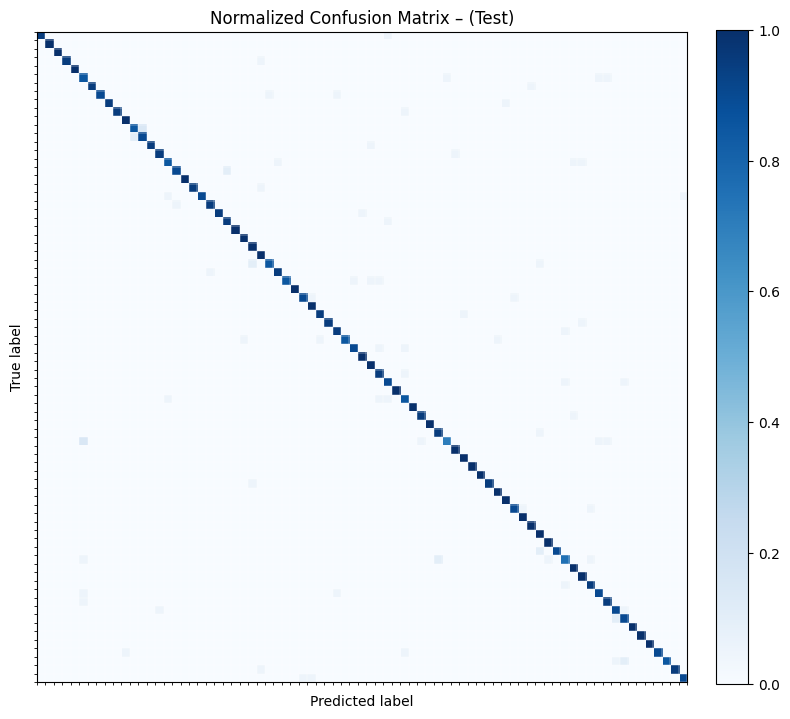

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np



cm_norm = confusion_matrix(
    truths,
    preds,

    normalize="true",
)

fig, ax = plt.subplots(figsize=(8, 8))

disp = ConfusionMatrixDisplay(cm_norm)
disp.plot(
    include_values=False,
    cmap="Blues",
    ax=ax,
    colorbar=False,
)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-0.5, cm_norm.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, cm_norm.shape[0], 1), minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=0.3)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Normalized Confusion Matrix – (Test)")

im = ax.images[0]
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## BERT (mean pooling) with CLS-tuned hyperparameters:

Train and evaluate this variant to know the effect of the pooling strategy while keeping all other training settings fixed.

In [ ]:
# using the same best configuration used for bert with cls
best_cfg =  {'lr': 3e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'batch_size': 64, 'epochs':15}
best_cfg["epochs"] = 15

final_result = run_experiment(best_cfg,model_name,"avg", train_loader, valid_loader, num_labels, device, return_model=True)
best_model = final_result["model"]

[CONFIG] lr=3e-05 | wd=0.0 | warmup=0.06 | epochs=15


100%|██████████| 25/25 [00:04<00:00,  6.07it/s]


Epoch: 1, Train loss: 3.507, Val loss: 1.576
Train rec: 0.260, Val rec: 0.684
Train f1: 0.285, Val f1: 0.648
Train prec: 0.437, Val prec: 0.695


100%|██████████| 25/25 [00:04<00:00,  5.97it/s]


Epoch: 2, Train loss: 0.903, Val loss: 0.516
Train rec: 0.821, Val rec: 0.895
Train f1: 0.825, Val f1: 0.895
Train prec: 0.848, Val prec: 0.904


100%|██████████| 25/25 [00:04<00:00,  6.05it/s]


Epoch: 3, Train loss: 0.365, Val loss: 0.388
Train rec: 0.927, Val rec: 0.904
Train f1: 0.928, Val f1: 0.904
Train prec: 0.929, Val prec: 0.913


100%|██████████| 25/25 [00:04<00:00,  5.95it/s]


Epoch: 4, Train loss: 0.207, Val loss: 0.374
Train rec: 0.958, Val rec: 0.914
Train f1: 0.958, Val f1: 0.913
Train prec: 0.959, Val prec: 0.923


100%|██████████| 25/25 [00:04<00:00,  6.02it/s]


Epoch: 5, Train loss: 0.126, Val loss: 0.374
Train rec: 0.975, Val rec: 0.918
Train f1: 0.975, Val f1: 0.918
Train prec: 0.976, Val prec: 0.924


100%|██████████| 25/25 [00:04<00:00,  5.95it/s]


Epoch: 6, Train loss: 0.075, Val loss: 0.368
Train rec: 0.985, Val rec: 0.925
Train f1: 0.985, Val f1: 0.925
Train prec: 0.986, Val prec: 0.930


100%|██████████| 25/25 [00:04<00:00,  6.07it/s]


Epoch: 7, Train loss: 0.044, Val loss: 0.381
Train rec: 0.994, Val rec: 0.925
Train f1: 0.994, Val f1: 0.925
Train prec: 0.994, Val prec: 0.934


100%|██████████| 25/25 [00:04<00:00,  6.01it/s]


Epoch: 8, Train loss: 0.029, Val loss: 0.334
Train rec: 0.995, Val rec: 0.929
Train f1: 0.995, Val f1: 0.929
Train prec: 0.995, Val prec: 0.934


100%|██████████| 25/25 [00:04<00:00,  5.95it/s]


Epoch: 9, Train loss: 0.020, Val loss: 0.408
Train rec: 0.998, Val rec: 0.928
Train f1: 0.998, Val f1: 0.928
Train prec: 0.998, Val prec: 0.933


100%|██████████| 25/25 [00:04<00:00,  6.00it/s]


Epoch: 10, Train loss: 0.012, Val loss: 0.415
Train rec: 0.999, Val rec: 0.925
Train f1: 0.999, Val f1: 0.925
Train prec: 0.999, Val prec: 0.930


100%|██████████| 25/25 [00:04<00:00,  5.97it/s]


Epoch: 11, Train loss: 0.009, Val loss: 0.411
Train rec: 0.999, Val rec: 0.926
Train f1: 0.999, Val f1: 0.926
Train prec: 0.999, Val prec: 0.931


100%|██████████| 25/25 [00:04<00:00,  6.00it/s]


Epoch: 12, Train loss: 0.008, Val loss: 0.415
Train rec: 0.999, Val rec: 0.923
Train f1: 0.999, Val f1: 0.922
Train prec: 0.999, Val prec: 0.927


100%|██████████| 25/25 [00:04<00:00,  5.92it/s]


Epoch: 13, Train loss: 0.007, Val loss: 0.418
Train rec: 0.999, Val rec: 0.927
Train f1: 0.999, Val f1: 0.926
Train prec: 0.999, Val prec: 0.931


100%|██████████| 25/25 [00:04<00:00,  5.93it/s]


Epoch: 14, Train loss: 0.006, Val loss: 0.422
Train rec: 1.000, Val rec: 0.927
Train f1: 1.000, Val f1: 0.926
Train prec: 1.000, Val prec: 0.931


100%|██████████| 25/25 [00:04<00:00,  6.00it/s]


Epoch: 15, Train loss: 0.005, Val loss: 0.421
Train rec: 1.000, Val rec: 0.927
Train f1: 1.000, Val f1: 0.926
Train prec: 1.000, Val prec: 0.931


testing

In [ ]:
preds,truths=test(best_model,test_loader,device)

  recall: 0.940, f1-score: 0.940, precision: 0.943


confusion matrix

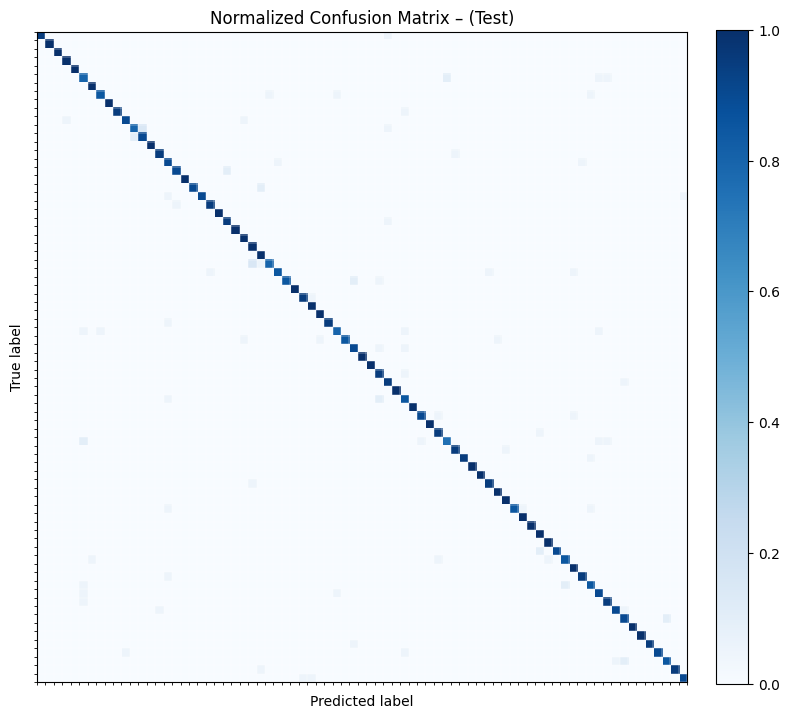

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np



cm_norm = confusion_matrix(
    truths,
    preds,

    normalize="true",
)

fig, ax = plt.subplots(figsize=(8, 8))

disp = ConfusionMatrixDisplay(cm_norm)
disp.plot(
    include_values=False,
    cmap="Blues",
    ax=ax,
    colorbar=False,
)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-0.5, cm_norm.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, cm_norm.shape[0], 1), minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=0.3)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Normalized Confusion Matrix – (Test)")

im = ax.images[0]
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## Final Performance Summary


*  **BERT (CLS pooling)** → best overall, macro-F1 ≈ 0.945 : Most expensive( largest model, longest training and inference) + CLS provides a focused global representation.
*   **BERT (mean pooling)** → second, macro-F1 ≈ 0.940:
Same cost as BERT (CLS), but slightly worse because averaging dilutes important tokens.
* **DistilBERT (CLS pooling)** → third, macro-F1 ≈ 0.930: Cheaper (smaller model, faster and lighter), but reduced depth yields slightly weaker representations.



